# 1. Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/Research

/content/drive/My Drive/Research


# 2. Import Libraries

In [ ]:
# Install necessary libraries
!pip install networkx
!pip install torch
!pip install torch-geometric
!pip install joblib
!pip install opencv-python-headless

import os
from glob import glob
from PIL import Image
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.utils import subgraph
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import kneighbors_graph

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

# 3. Load Dataset

In [ ]:
df = pd.read_csv("HAM10000_metadata.csv")

In [ ]:
df

lesion_id      image_id     dx dx_type   age     sex localization  \
0      HAM_0000118  ISIC_0027419    bkl   histo  80.0    male        scalp   
1      HAM_0000118  ISIC_0025030    bkl   histo  80.0    male        scalp   
2      HAM_0002730  ISIC_0026769    bkl   histo  80.0    male        scalp   
3      HAM_0002730  ISIC_0025661    bkl   histo  80.0    male        scalp   
4      HAM_0001466  ISIC_0031633    bkl   histo  75.0    male          ear   
...            ...           ...    ...     ...   ...     ...          ...   
10010  HAM_0002867  ISIC_0033084  akiec   histo  40.0    male      abdomen   
10011  HAM_0002867  ISIC_0033550  akiec   histo  40.0    male      abdomen   
10012  HAM_0002867  ISIC_0033536  akiec   histo  40.0    male      abdomen   
10013  HAM_0000239  ISIC_0032854  akiec   histo  80.0    male         face   
10014  HAM_0003521  ISIC_0032258    mel   histo  70.0  female         back   

            dataset  
0      vidir_modern  
1      vidir_modern  
2      vidir_modern  
3      vidir_modern  
4      vidir_modern  
...             ...  
10010  vidir_modern  
10011  vidir_modern  
10012  vidir_modern  
10013  vidir_modern  
10014  vidir_modern  

[10015 rows x 8 columns]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
 7   dataset       10015 non-null  object 
dtypes: float64(1), object(7)
memory usage: 626.1+ KB


Age column indicate missing values

In [ ]:
# Check for unique entries in each column
unique_counts = df.nunique()

print("\nUnique entries in each column:")
print(unique_counts)


Unique entries in each column:
lesion_id        7470
image_id        10015
dx                  7
dx_type             4
age                18
sex                 3
localization       15
dataset             4
dtype: int64


In [ ]:
df['dataset'].unique()

array(['vidir_modern', 'rosendahl', 'vienna_dias', 'vidir_molemax'],
      dtype=object)

In [ ]:
df['age'].unique()

array([80., 75., 60., 70., 55., 85., 65., 40., 50., 45., 35.,  0., 30.,
       nan,  5., 25., 20., 10., 15.])

In [ ]:
df['sex'].unique()

array(['male', 'female', 'unknown'], dtype=object)

In [ ]:
df['localization'].unique()

array(['scalp', 'ear', 'face', 'back', 'trunk', 'chest',
       'upper extremity', 'abdomen', 'unknown', 'lower extremity',
       'genital', 'neck', 'hand', 'foot', 'acral'], dtype=object)

## Column Description


* lesion_id: Has 7470 unique inputs, implies that there are repeated lesions with multiple images   
* image_id: Has 10015 inputs, indicate that each image has its own unique id.
* The patients include 18 different ages, 3 different sexes (male, female and unknown).
* The disease located in 15 different locations (scalp, ear, face, back, trunk, chest, upper extremity, abdomen, unknown, lower extremity, genital, neck, hand, foot, and acral)



In [ ]:
# Checking for missing data in metadata
missing_data = df.isnull().sum()
print(missing_data)


lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dataset          0
dtype: int64


lesion_id       0.000000
image_id        0.000000
dx              0.000000
dx_type         0.000000
age             0.569146
sex             0.000000
localization    0.000000
dataset         0.000000
dtype: float64


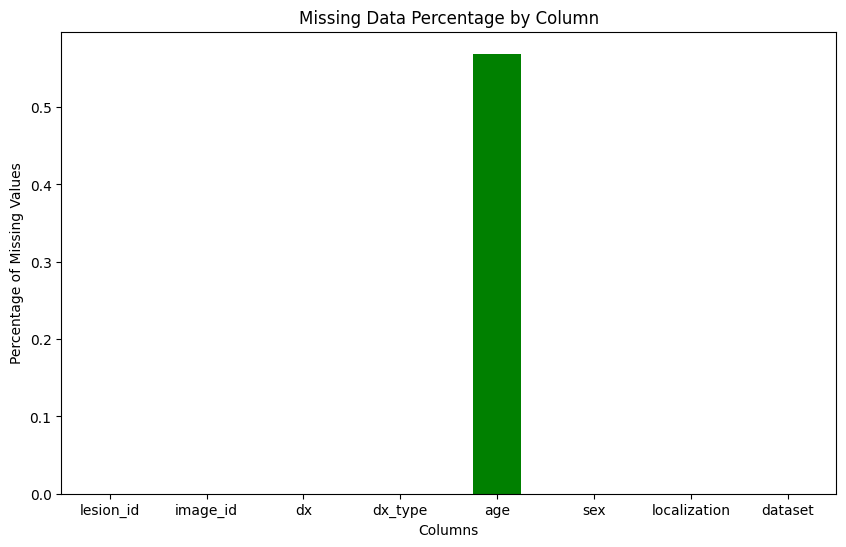

In [ ]:
# Calculate the percentage of missing values for each column
missing_data = df.isnull().sum()
total_entries = len(df)
missing_percentage = (missing_data / total_entries) * 100

print(missing_percentage)

# Create a bar chart of missing value percentages
plt.figure(figsize=(10, 6))
missing_percentage.plot(kind='bar', color='green')
plt.title('Missing Data Percentage by Column')
plt.xlabel('Columns')
plt.ylabel('Percentage of Missing Values')
plt.xticks(rotation=0)
plt.show()


In [ ]:
# Define categorical and numerical columns
categorical_columns = ['lesion_id', 'image_id', 'dx', 'dx_type', 'sex', 'localization']
numerical_columns = ['age']

In [ ]:
# Calculate the value counts for the 'localization' column
localization_counts = df['localization'].value_counts()
print(localization_counts)

localization
back               2192
lower extremity    2077
trunk              1404
upper extremity    1118
abdomen            1022
face                745
chest               407
foot                319
unknown             234
neck                168
scalp               128
hand                 90
ear                  56
genital              48
acral                 7
Name: count, dtype: int64


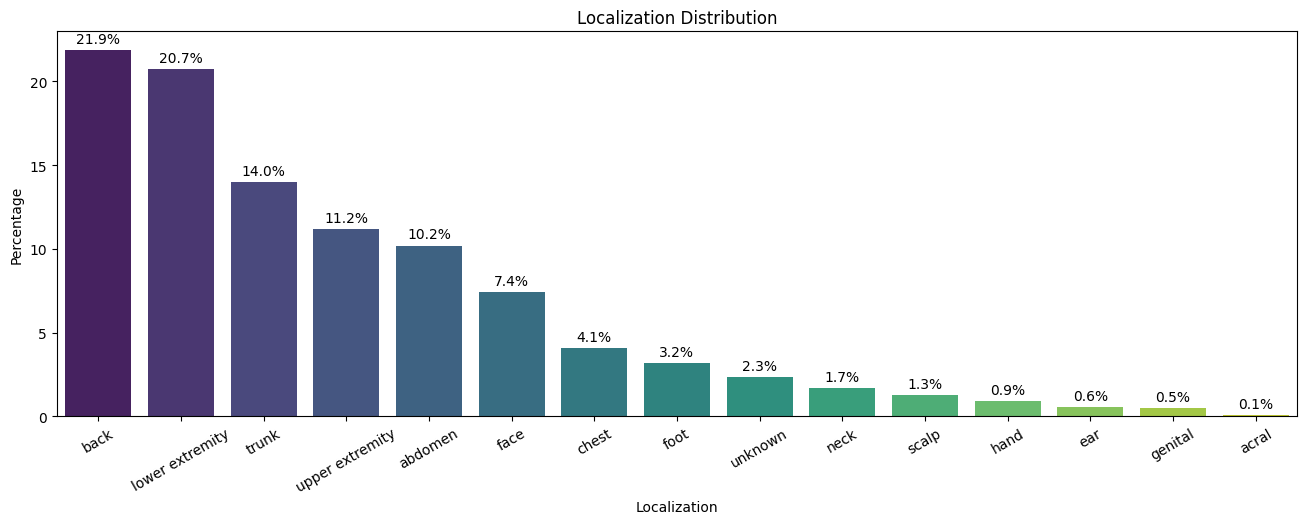

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming df is your DataFrame
# df = pd.read_csv('your_data.csv')

# Calculate the value counts and percentages for the 'localization' column
localization_counts = df['Region_Of_Disease'].value_counts()
localization_percentages = (localization_counts / localization_counts.sum()) * 100

plt.figure(figsize=(16, 5))
ax = sns.barplot(x=localization_percentages.index, y=localization_percentages.values, palette='viridis')
plt.title('Localization Distribution')
plt.xlabel('Localization')
plt.ylabel('Percentage')
plt.xticks(rotation=30)

# Annotate the bars with the percentage values
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.1f}%', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()


In [ ]:
# Distribution of value count for Sex in the dataset
for column in categorical_columns:
    df['sex'].value_counts()

df['sex'].value_counts()

sex
male       5406
female     4552
unknown      57
Name: count, dtype: int64

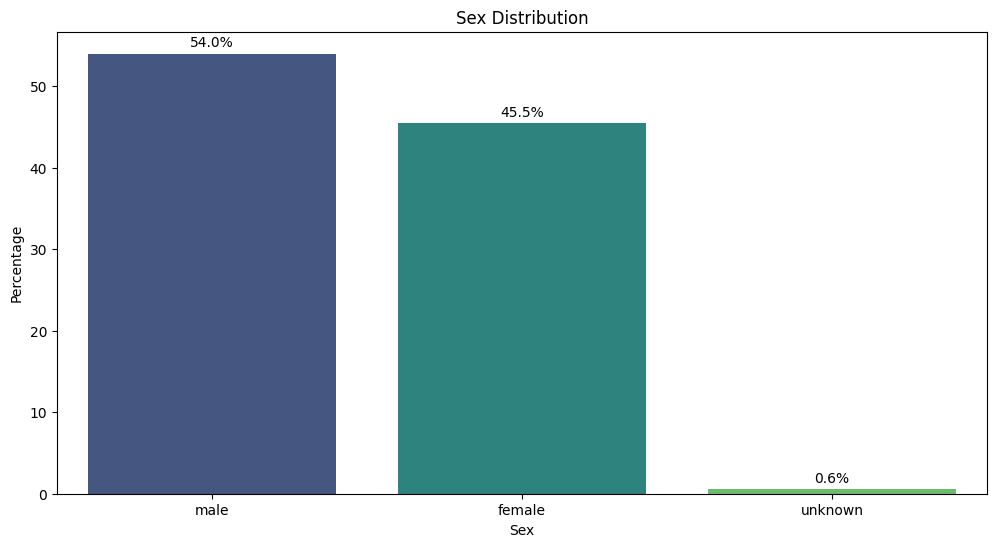

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame
# df = pd.read_csv('your_data.csv')

# Calculate the value counts and percentages for the 'sex' column
sex_counts = df['Sex'].value_counts()
sex_percentages = (sex_counts / sex_counts.sum()) * 100

# Plot the percentage counts for the 'sex' column
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=sex_percentages.index, y=sex_percentages.values, palette='viridis')

# Add title and labels
plt.title('Sex Distribution')
plt.xlabel('Sex')
plt.ylabel('Percentage')

# Annotate the bars with the percentage values
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.1f}%', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()


In [ ]:
# Distribution of value count for Type of disease
for column in categorical_columns:
    df['dx'].value_counts()

df['dx'].value_counts()

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

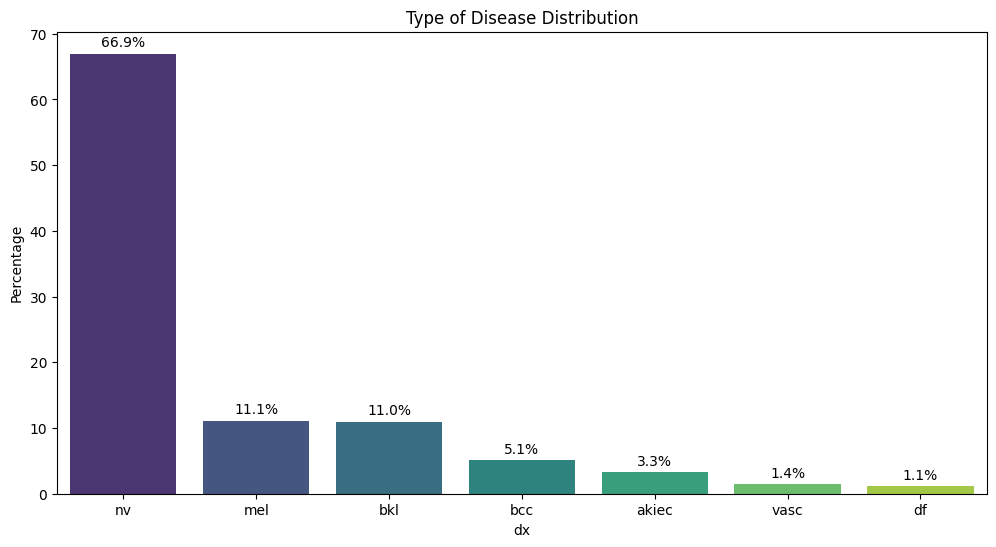

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame
# df = pd.read_csv('your_data.csv')

# Calculate the value counts and percentages for the 'dx' column
dx_counts = df['Diagnosis'].value_counts()
dx_percentages = (dx_counts / dx_counts.sum()) * 100

# Plot the percentage counts for the 'dx' column
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=dx_percentages.index, y=dx_percentages.values, palette='viridis')

# Add title and labels
plt.title('Type of Disease Distribution')
plt.xlabel('dx')
plt.ylabel('Percentage')

# Annotate the bars with the percentage values
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.1f}%', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()


In [ ]:
# Distribution of value count for Confirmation method of disease
for column in categorical_columns:
    df['dx_type'].value_counts()

df['dx_type'].value_counts()

dx_type
histo        5340
follow_up    3704
consensus     902
confocal       69
Name: count, dtype: int64

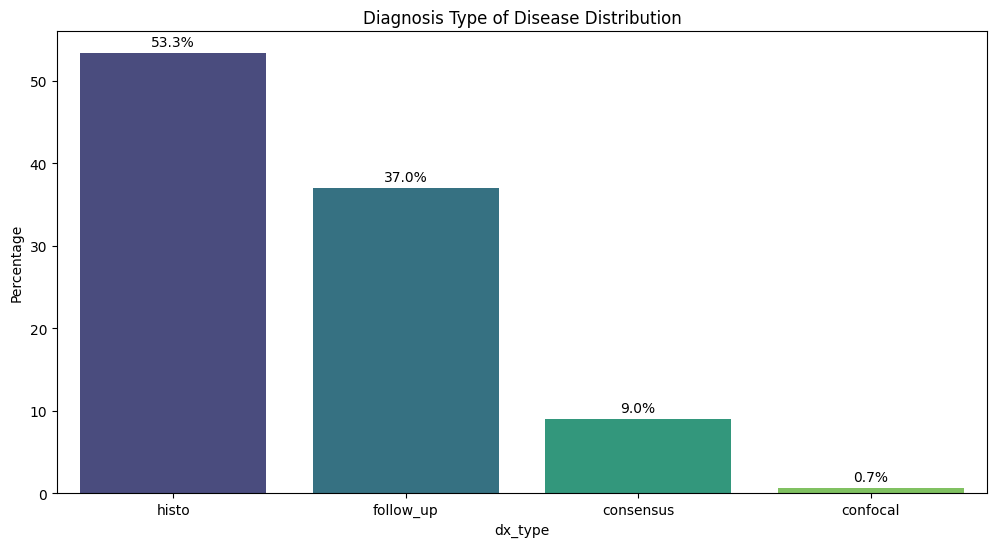

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame
# df = pd.read_csv('your_data.csv')

# Calculate the value counts and percentages for the 'dx_type' column
dx_type_counts = df['Confirmation_Method'].value_counts()
dx_type_percentages = (dx_type_counts / dx_type_counts.sum()) * 100

# Plot the percentage counts for the 'dx_type' column
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=dx_type_percentages.index, y=dx_type_percentages.values, palette='viridis')

# Add title and labels
plt.title('Diagnosis Type of Disease Distribution')
plt.xlabel('dx_type')
plt.ylabel('Percentage')

# Annotate the bars with the percentage values
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.1f}%', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()


<ipython-input-65-7ad53d3ca765>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='age', palette='coolwarm')


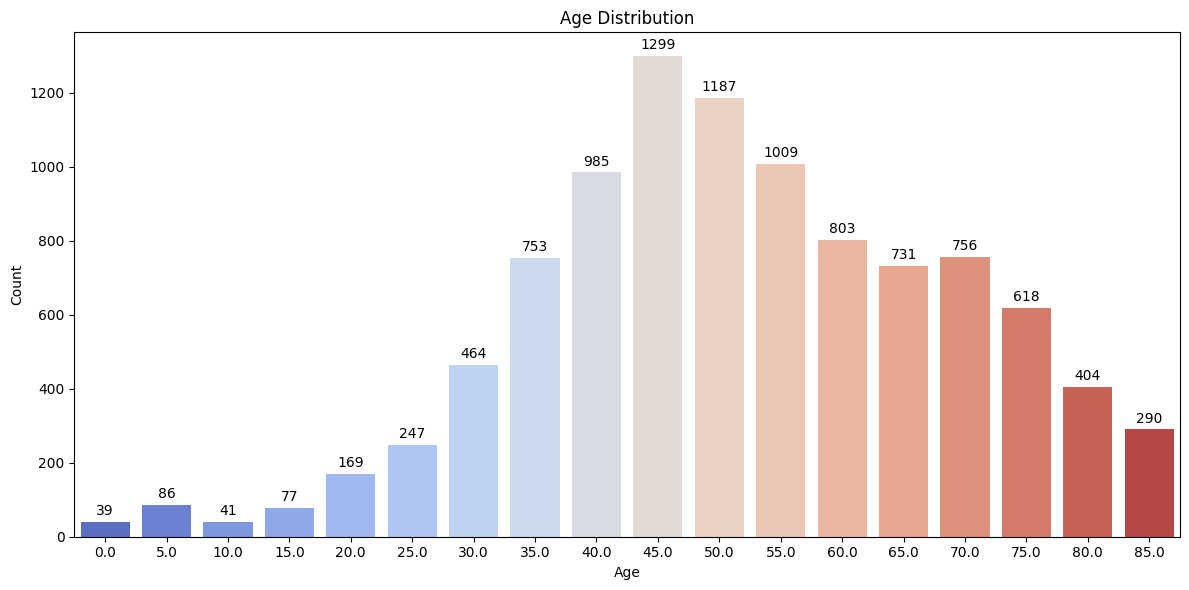

In [ ]:

# Calculate the value counts for the 'age' column, including NaN values
age_counts = df['age'].value_counts(dropna=False)


# Plot the value counts for the 'age' column
plt.figure(figsize=(12, 6))  # Adjusting the figure size for better visibility
sns.countplot(data=df, x='age', palette='coolwarm')

# Add title and labels
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')

# Rotate x-axis labels for better readability
plt.xticks(rotation=0)

# Annotate the bars with the count values as integers
for p in plt.gca().patches:
    height = p.get_height()
    plt.gca().annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2., height),
                       ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 5),
                       textcoords='offset points')

plt.tight_layout()
plt.show()

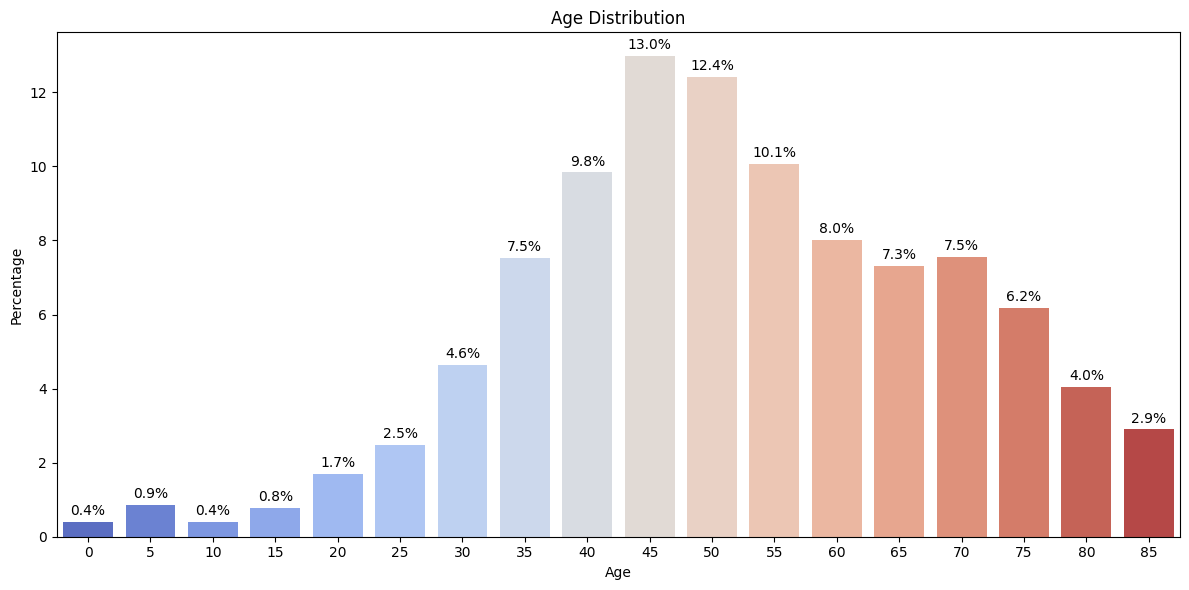

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame
# df = pd.read_csv('your_data.csv')

# Calculate the value counts for the 'Age' column, including NaN values
age_counts = df['Age'].value_counts(dropna=False).sort_index()
age_percentages = (age_counts / age_counts.sum()) * 100

# Plot the value counts for the 'Age' column
plt.figure(figsize=(12, 6))  # Adjusting the figure size for better visibility
ax = sns.barplot(x=age_percentages.index, y=age_percentages.values, palette='coolwarm')

# Add title and labels
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Percentage')

# Rotate x-axis labels for better readability
plt.xticks(rotation=0)

# Annotate the bars with the percentage values
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.1f}%', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.tight_layout()
plt.show()


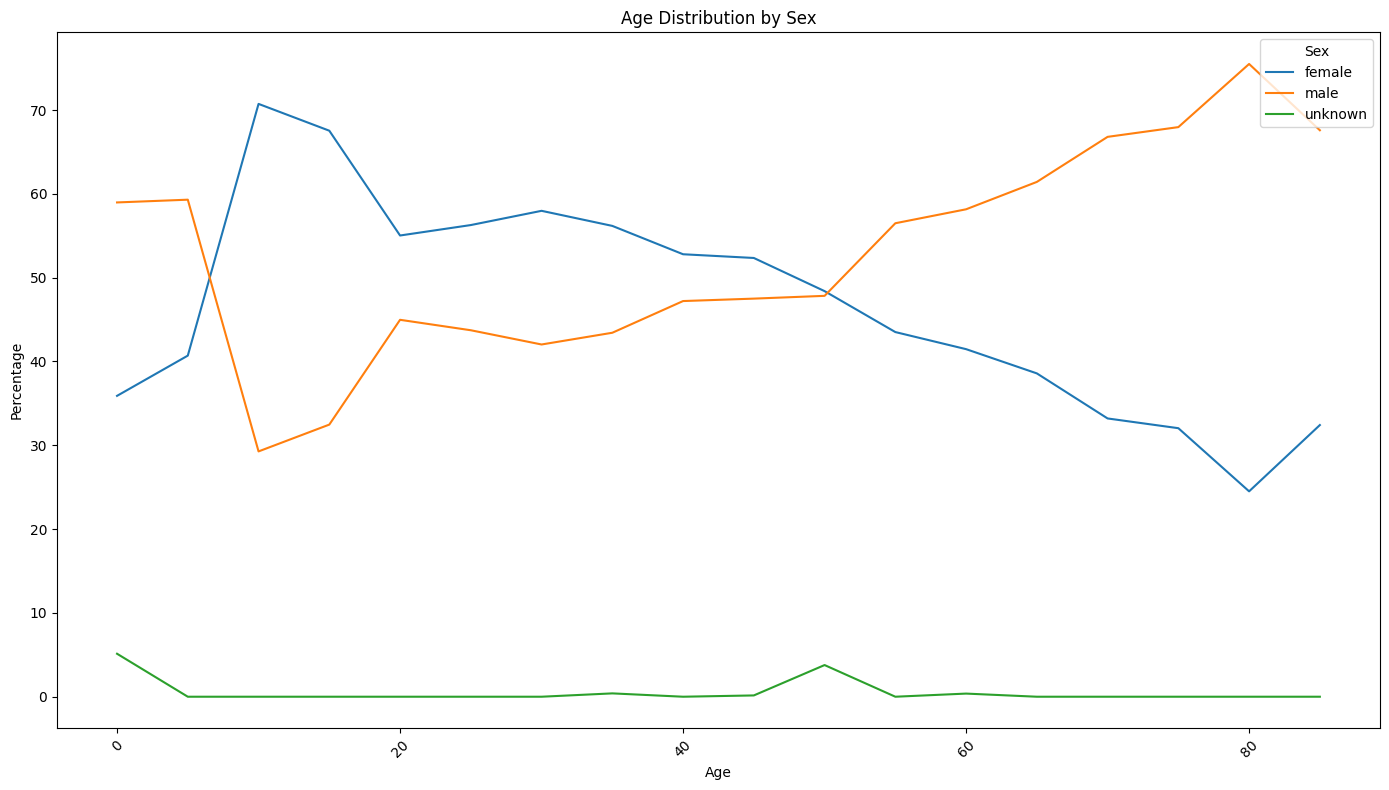

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
import numpy as np

# Assuming df is your DataFrame
# df = pd.read_csv('your_data.csv')

# Calculate the percentages for 'Age' and 'Sex' columns
age_sex_counts = df.groupby(['Age', 'Sex']).size().unstack().fillna(0).sort_index()
age_sex_percentages = age_sex_counts.apply(lambda x: (x / x.sum()) * 100, axis=1)

# Melt the DataFrame for easier plotting with seaborn
df_melted = age_sex_percentages.reset_index().melt(id_vars='Age', value_vars=age_sex_percentages.columns)
df_melted.columns = ['Age', 'Sex', 'Percentage']

# Plot the percentage distribution for each age and sex category as a line graph
plt.figure(figsize=(14, 8))  # Adjusting the figure size for better visibility

# Create a line plot
for sex in df_melted['Sex'].unique():
    df_sex = df_melted[df_melted['Sex'] == sex]
    x = df_sex['Age']
    y = df_sex['Percentage']



    plt.plot(x, y, label=sex)

# Add title and labels
plt.title('Age Distribution by Sex')
plt.xlabel('Age')
plt.ylabel('Percentage')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

plt.legend(title='Sex', loc='upper right')

plt.tight_layout()
plt.show()


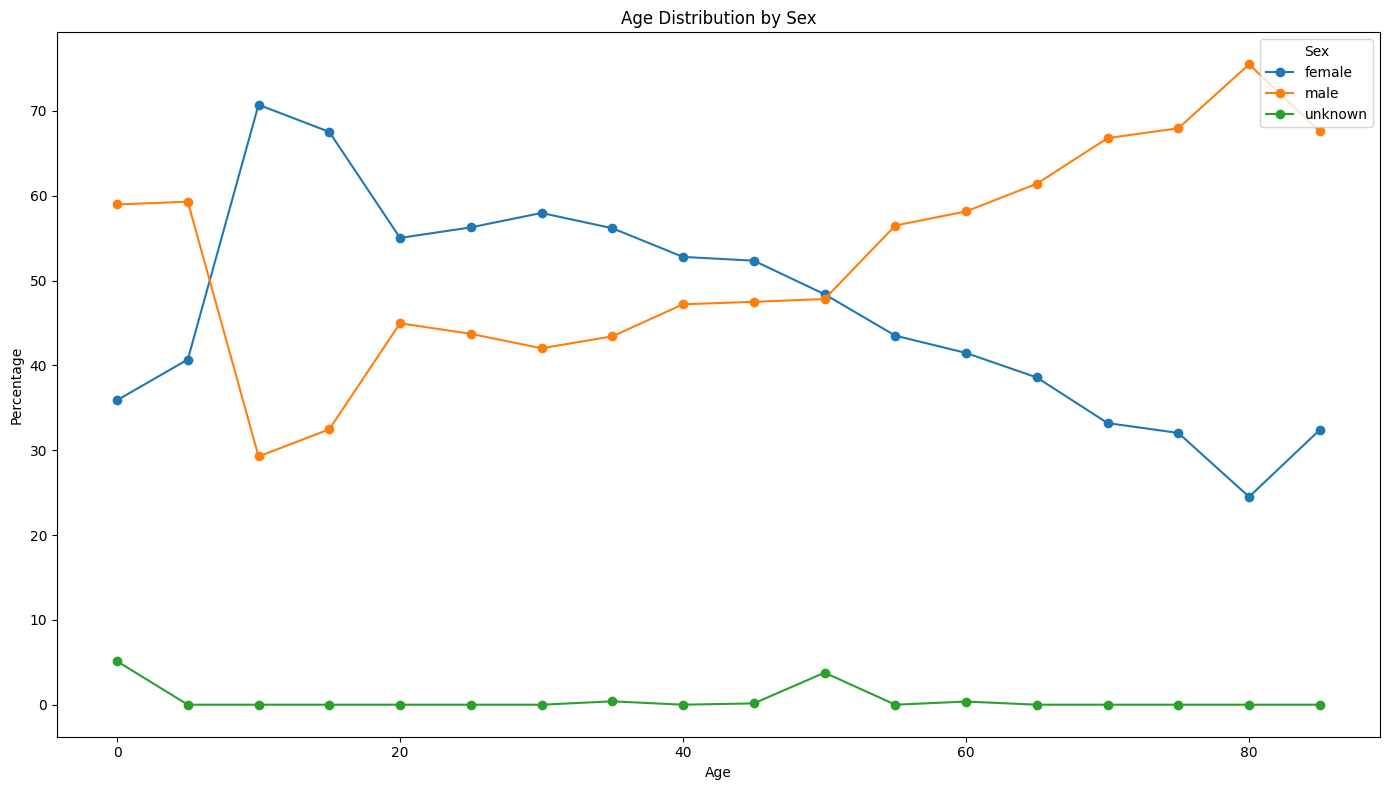

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame
# df = pd.read_csv('your_data.csv')

# Calculate the percentages for 'Age' and 'Sex' columns
age_sex_counts = df.groupby(['Age', 'Sex']).size().unstack().fillna(0).sort_index()
age_sex_percentages = age_sex_counts.apply(lambda x: (x / x.sum()) * 100, axis=1)

# Melt the DataFrame for easier plotting with seaborn
df_melted = age_sex_percentages.reset_index().melt(id_vars='Age', value_vars=age_sex_percentages.columns)
df_melted.columns = ['Age', 'Sex', 'Percentage']

# Plot the percentage distribution for each age and sex category as a line graph
plt.figure(figsize=(14, 8))  # Adjusting the figure size for better visibility

# Create a line plot with dots
for sex in df_melted['Sex'].unique():
    df_sex = df_melted[df_melted['Sex'] == sex]
    x = df_sex['Age']
    y = df_sex['Percentage']

    plt.plot(x, y, marker='o', label=sex)

# Add title and labels
plt.title('Age Distribution by Sex')
plt.xlabel('Age')
plt.ylabel('Percentage')

# Rotate x-axis labels for better readability
plt.xticks(rotation=0)

plt.legend(title='Sex', loc='upper right')

plt.tight_layout()
plt.show()


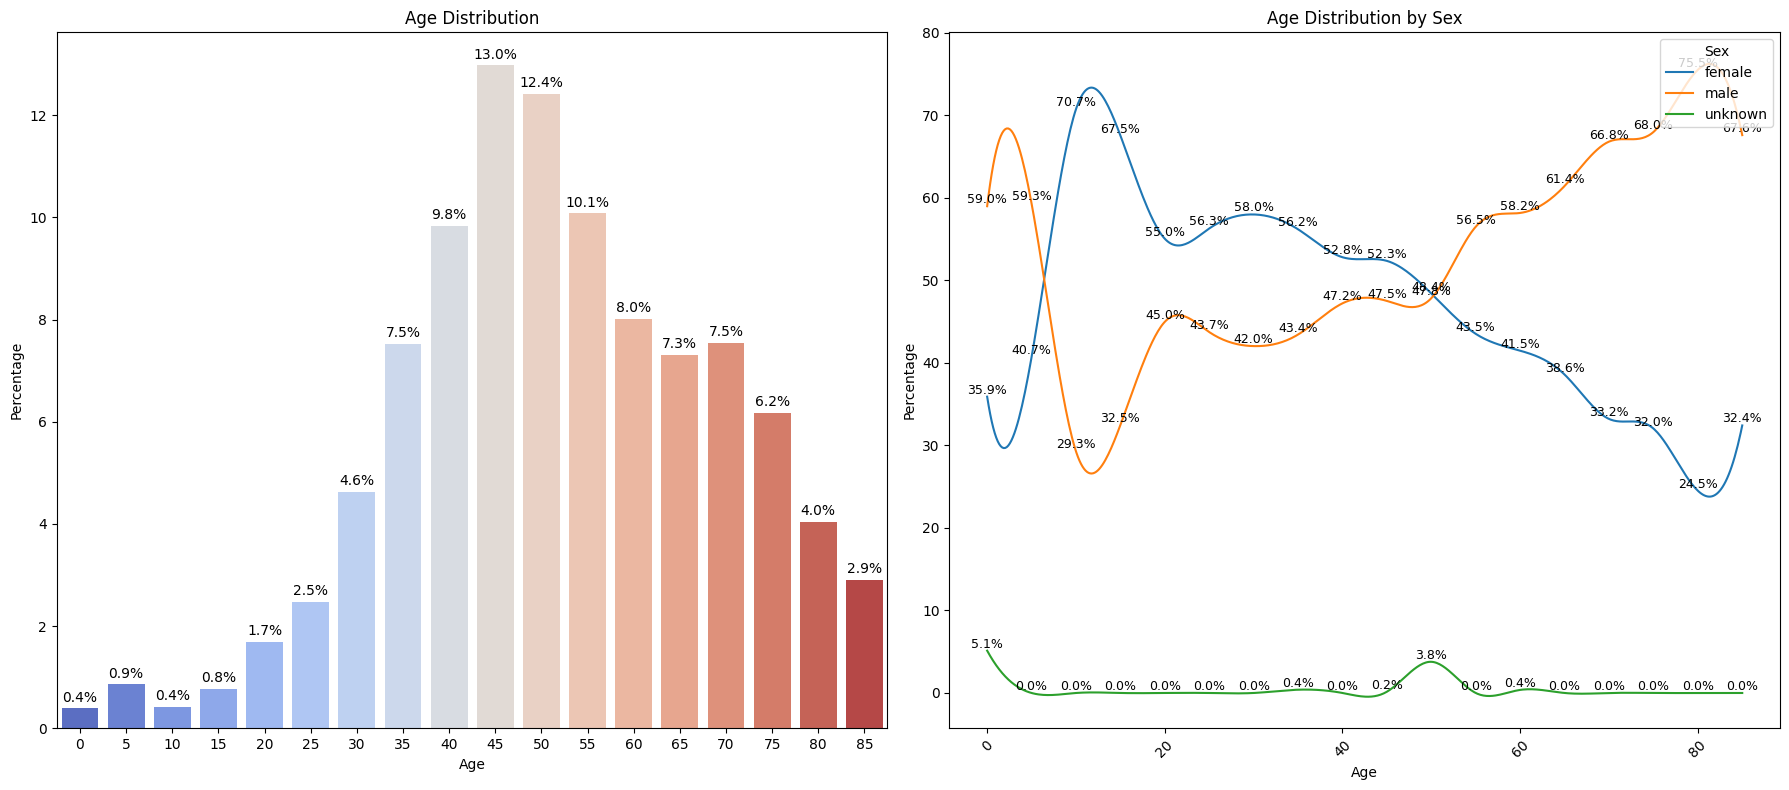

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
import numpy as np

# Assuming df is your DataFrame
# df = pd.read_csv('your_data.csv')

# Calculate the value counts for the 'Age' column, including NaN values
age_counts = df['Age'].value_counts(dropna=False).sort_index()
age_percentages = (age_counts / age_counts.sum()) * 100

# Calculate the percentages for 'Age' and 'Sex' columns
age_sex_counts = df.groupby(['Age', 'Sex']).size().unstack().fillna(0).sort_index()
age_sex_percentages = age_sex_counts.apply(lambda x: (x / x.sum()) * 100, axis=1)

# Melt the DataFrame for easier plotting with seaborn
df_melted = age_sex_percentages.reset_index().melt(id_vars='Age', value_vars=age_sex_percentages.columns)
df_melted.columns = ['Age', 'Sex', 'Percentage']

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))  # Adjusting the figure size for better visibility

# Plot the bar plot in the first subplot
sns.barplot(x=age_percentages.index, y=age_percentages.values, palette='coolwarm', ax=ax1)
ax1.set_title('Age Distribution')
ax1.set_xlabel('Age')
ax1.set_ylabel('Percentage')

# Annotate the bars with the percentage values
for p in ax1.patches:
    height = p.get_height()
    ax1.annotate(f'{height:.1f}%', (p.get_x() + p.get_width() / 2., height),
                 ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 5),
                 textcoords='offset points')

# Plot the line plot in the second subplot
for sex in df_melted['Sex'].unique():
    df_sex = df_melted[df_melted['Sex'] == sex]
    x = df_sex['Age']
    y = df_sex['Percentage']

    # Create spline interpolation of the data for smooth lines
    x_smooth = np.linspace(x.min(), x.max(), 500)
    spline = make_interp_spline(x, y, k=3)  # k=3 for cubic spline
    y_smooth = spline(x_smooth)

    ax2.plot(x_smooth, y_smooth, label=sex)

    # Annotate each point with the percentage value
    for i in range(len(x)):
        ax2.text(x.iloc[i], y.iloc[i], f'{y.iloc[i]:.1f}%', ha='center', va='bottom', fontsize=9)

ax2.set_title('Age Distribution by Sex')
ax2.set_xlabel('Age')
ax2.set_ylabel('Percentage')

# Rotate x-axis labels for better readability
plt.setp(ax2.get_xticklabels(), rotation=45)

ax2.legend(title='Sex', loc='upper right')

plt.tight_layout()
plt.show()


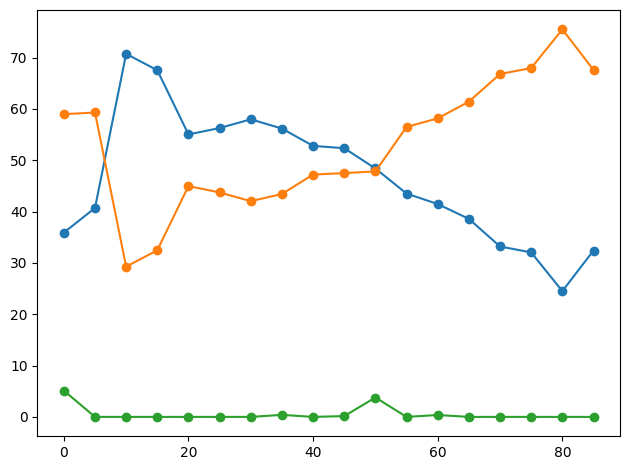

In [ ]:


# Plot the line plot in the second subplot with dots
for sex in df_melted['Sex'].unique():
    df_sex = df_melted[df_melted['Sex'] == sex]
    x = df_sex['Age']
    y = df_sex['Percentage']

    plt.plot(x, y, marker='o', label=sex)


ax2.set_title('Age Distribution by Sex')
ax2.set_xlabel('Age')
ax2.set_ylabel('Percentage')

# Rotate x-axis labels for better readability
plt.setp(ax2.get_xticklabels(), rotation=45)

ax2.legend(title='Sex', loc='upper right')

plt.tight_layout()
plt.show()


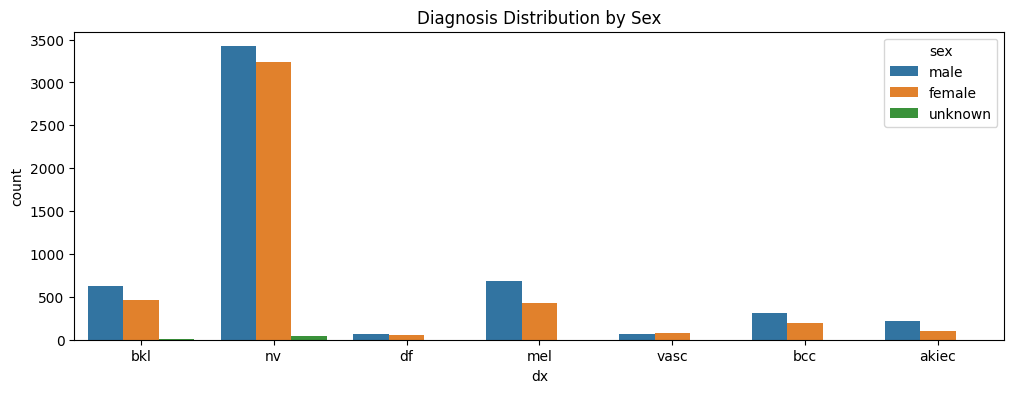

In [ ]:
# Visualizing relationships between categorical columns
plt.figure(figsize=(12, 4))
sns.countplot(data=df, x='dx', hue='sex')
plt.title('Diagnosis Distribution by Sex')
plt.show()

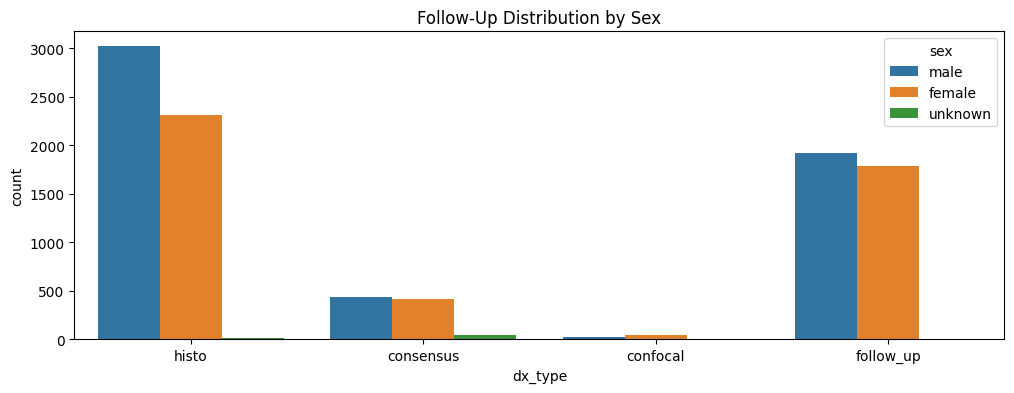

In [ ]:
# Visualizing relationships between categorical columns
plt.figure(figsize=(12, 4))
sns.countplot(data=df, x='dx_type', hue='sex')
plt.title('Follow-Up Distribution by Sex')
plt.show()

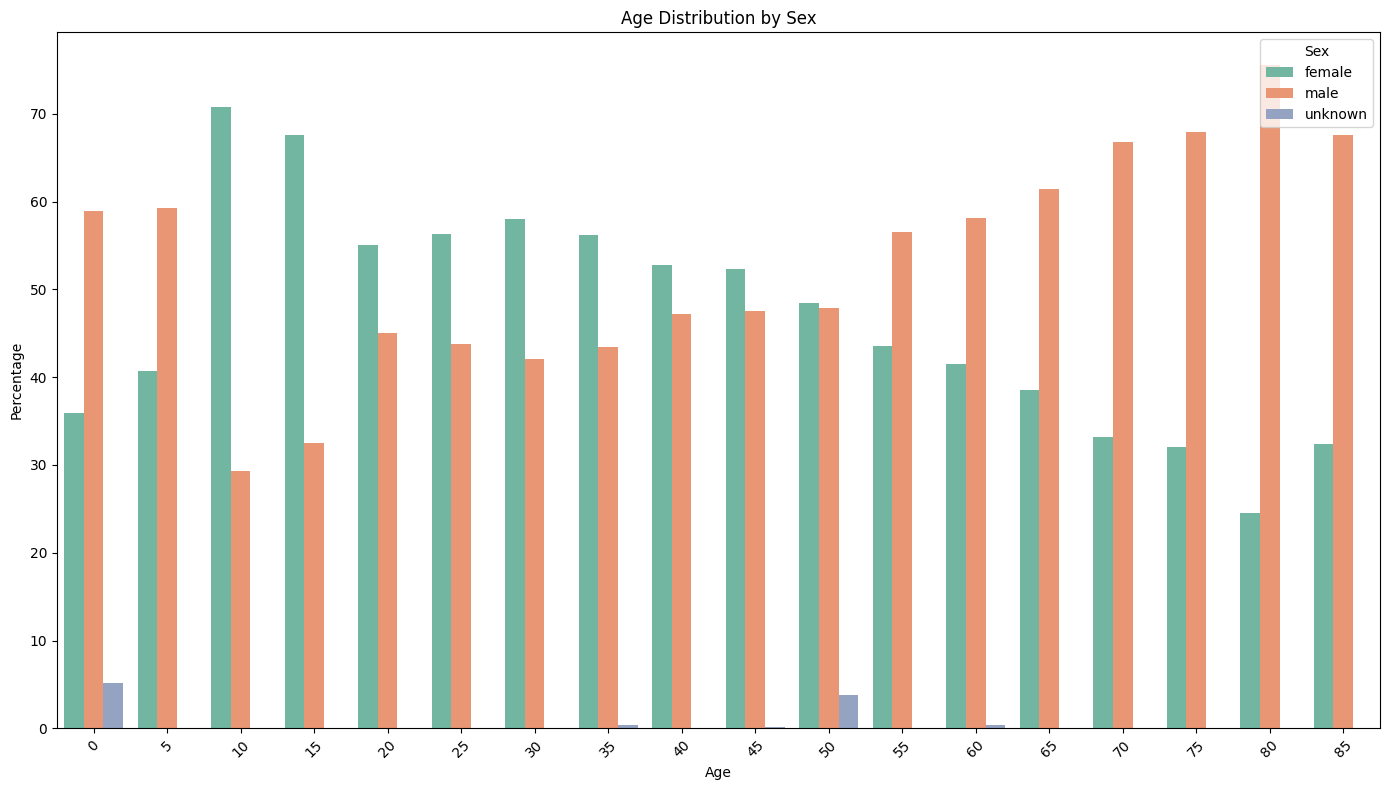

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame
# df = pd.read_csv('your_data.csv')

# Calculate the percentages for 'Age' and 'Sex' columns
age_sex_counts = df.groupby(['Age', 'Sex']).size().unstack().fillna(0).sort_index()
age_sex_percentages = age_sex_counts.apply(lambda x: (x / x.sum()) * 100, axis=1)

# Melt the DataFrame for easier plotting with seaborn
df_melted = age_sex_percentages.reset_index().melt(id_vars='Age', value_vars=age_sex_percentages.columns)
df_melted.columns = ['Age', 'Sex', 'Percentage']

# Plot the percentage distribution for each age and sex category
plt.figure(figsize=(14, 8))  # Adjusting the figure size for better visibility
ax = sns.barplot(data=df_melted, x='Age', y='Percentage', hue='Sex', palette='Set2')

# Add title and labels
plt.title('Age Distribution by Sex')
plt.xlabel('Age')
plt.ylabel('Percentage')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

plt.legend(title='Sex', loc='upper right')

plt.tight_layout()
plt.show()


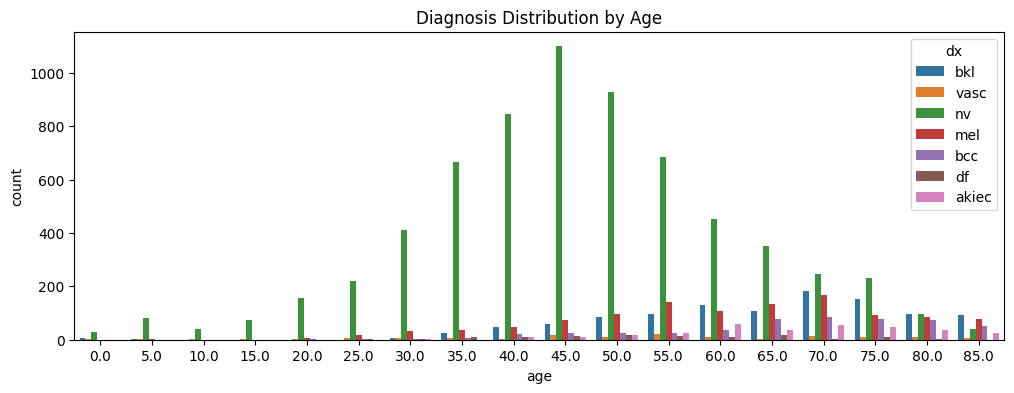

In [ ]:
# Visualizing relationships between categorical columns
plt.figure(figsize=(12, 4))
sns.countplot(data=df, x='age', hue='dx')
plt.title('Diagnosis Distribution by Age')
plt.show()

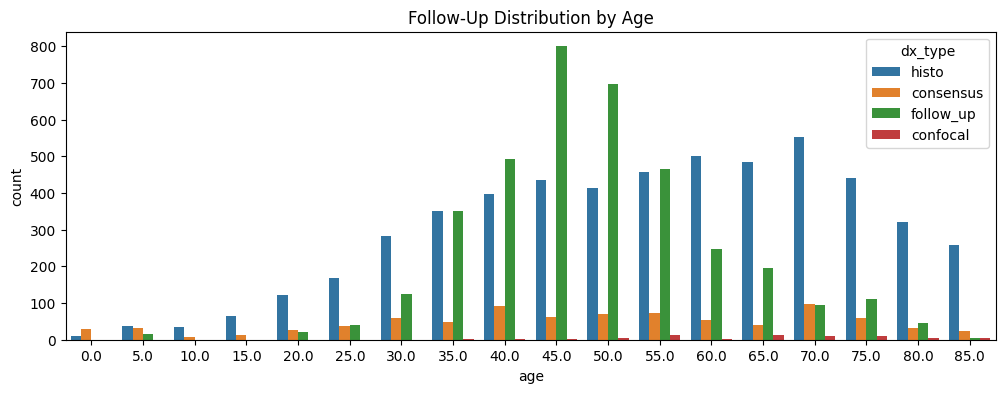

In [ ]:
# Visualizing relationships between categorical columns
plt.figure(figsize=(12, 4))
sns.countplot(data=df, x='age', hue='dx_type')
plt.title('Follow-Up Distribution by Age')
plt.show()

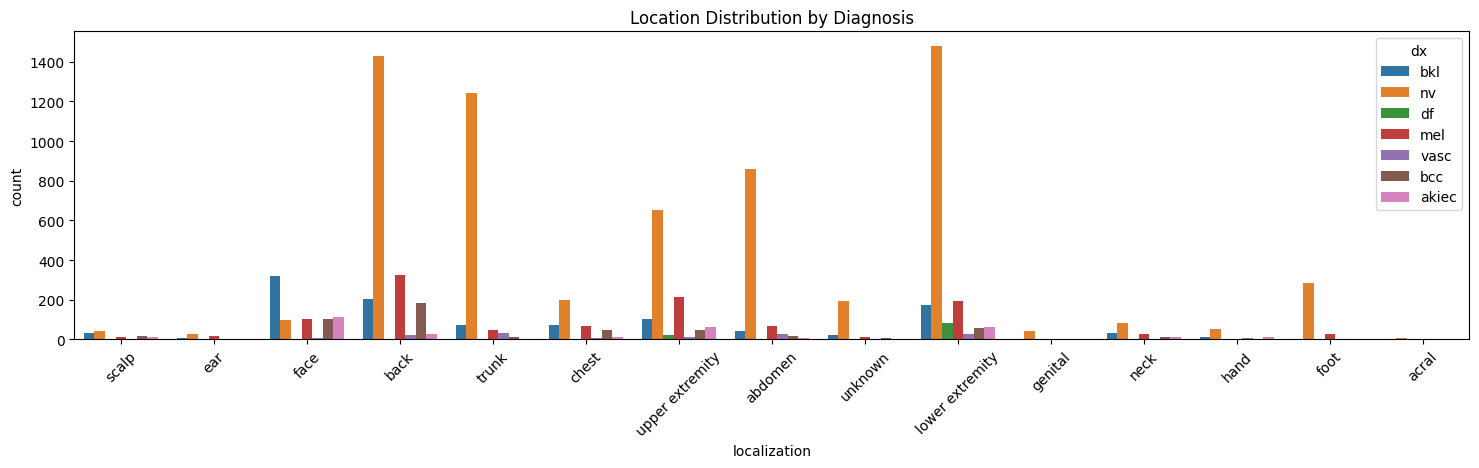

In [ ]:
# Visualizing relationships between categorical columns
plt.figure(figsize=(18, 4))
sns.countplot(data=df, x='localization', hue='dx')Z
plt.xticks(rotation=45)
plt.show()

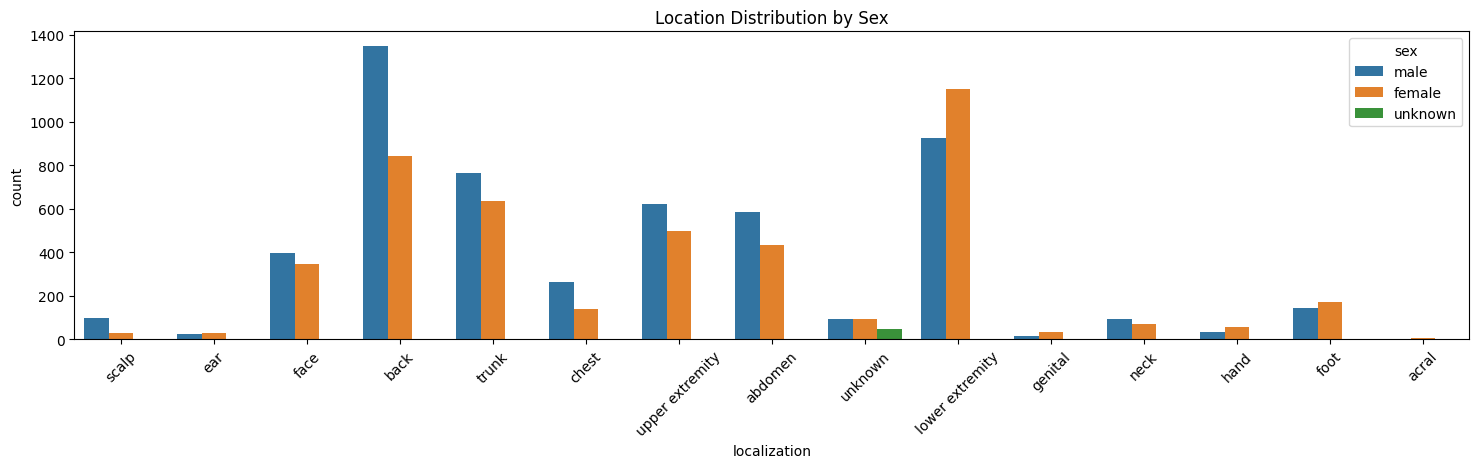

In [ ]:
# Visualizing relationships between categorical columns
plt.figure(figsize=(18, 4))
sns.countplot(data=df, x='localization', hue='sex')
plt.title('Location Distribution by Sex')
plt.xticks(rotation=45)
plt.show()

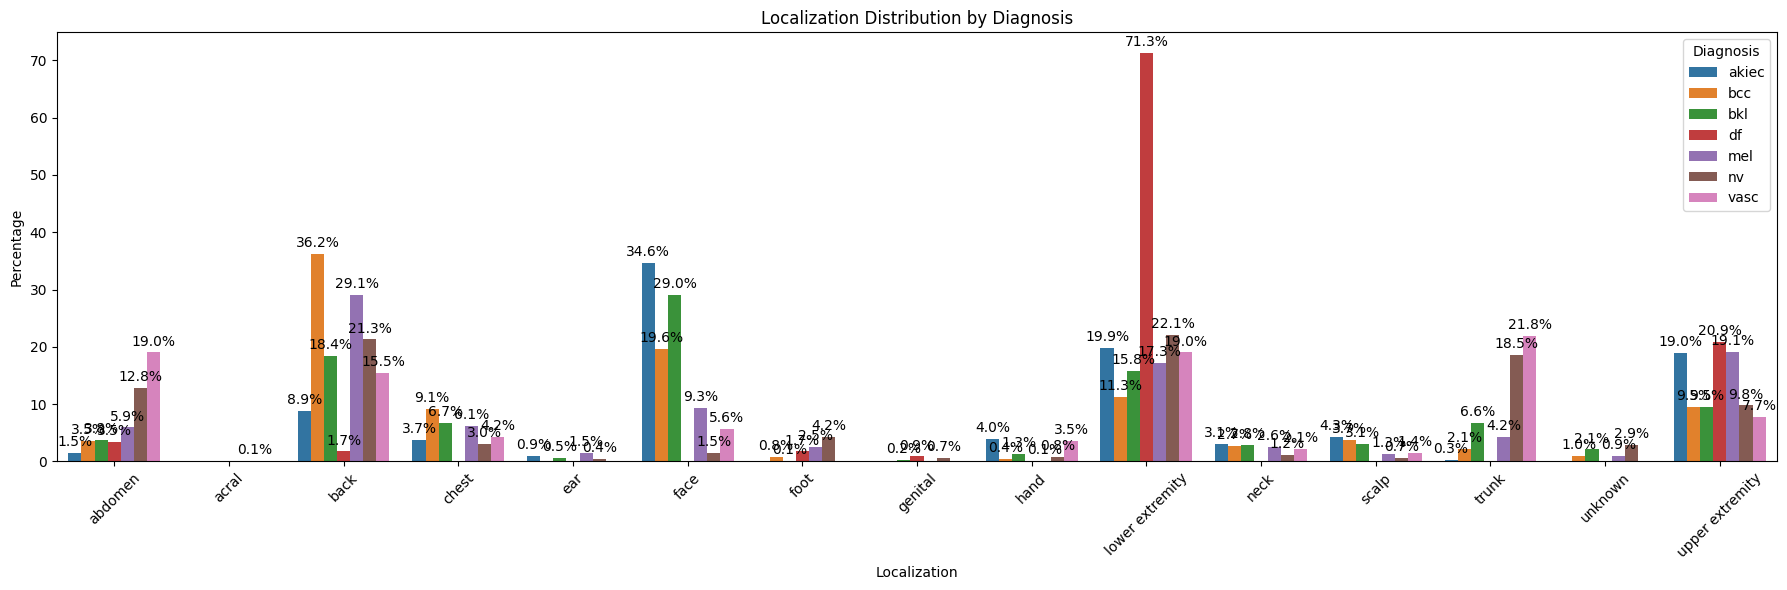

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming df is your DataFrame
# df = pd.read_csv('your_data.csv')

# Calculate the value counts and percentages for 'localization' grouped by 'dx'
localization_dx_counts = df.groupby(['Region_Of_Disease', 'Diagnosis']).size().unstack().fillna(0)
localization_dx_percentages = localization_dx_counts.apply(lambda x: (x / x.sum()) * 100, axis=0).stack().reset_index()
localization_dx_percentages.columns = ['localization', 'dx', 'percentage']

# Plot the percentage distribution for localization by diagnosis
plt.figure(figsize=(18, 6))  # Increased figure size for better visibility
ax = sns.barplot(x='localization', y='percentage', hue='dx', data=localization_dx_percentages, palette='tab10')  # Changed color palette
plt.title('Localization Distribution by Diagnosis')
plt.xlabel('Localization')
plt.ylabel('Percentage')
plt.xticks(rotation=45)  # Adjusted rotation for better readability

# Annotate the bars with the percentage values
for p in ax.patches:
    height = p.get_height()
    if height > 0:  # Only annotate if the percentage is greater than 0
        ax.annotate(f'{height:.1f}%', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 5),
                    textcoords='offset points')

plt.tight_layout()
plt.legend(title='Diagnosis', loc='upper right')
plt.show()


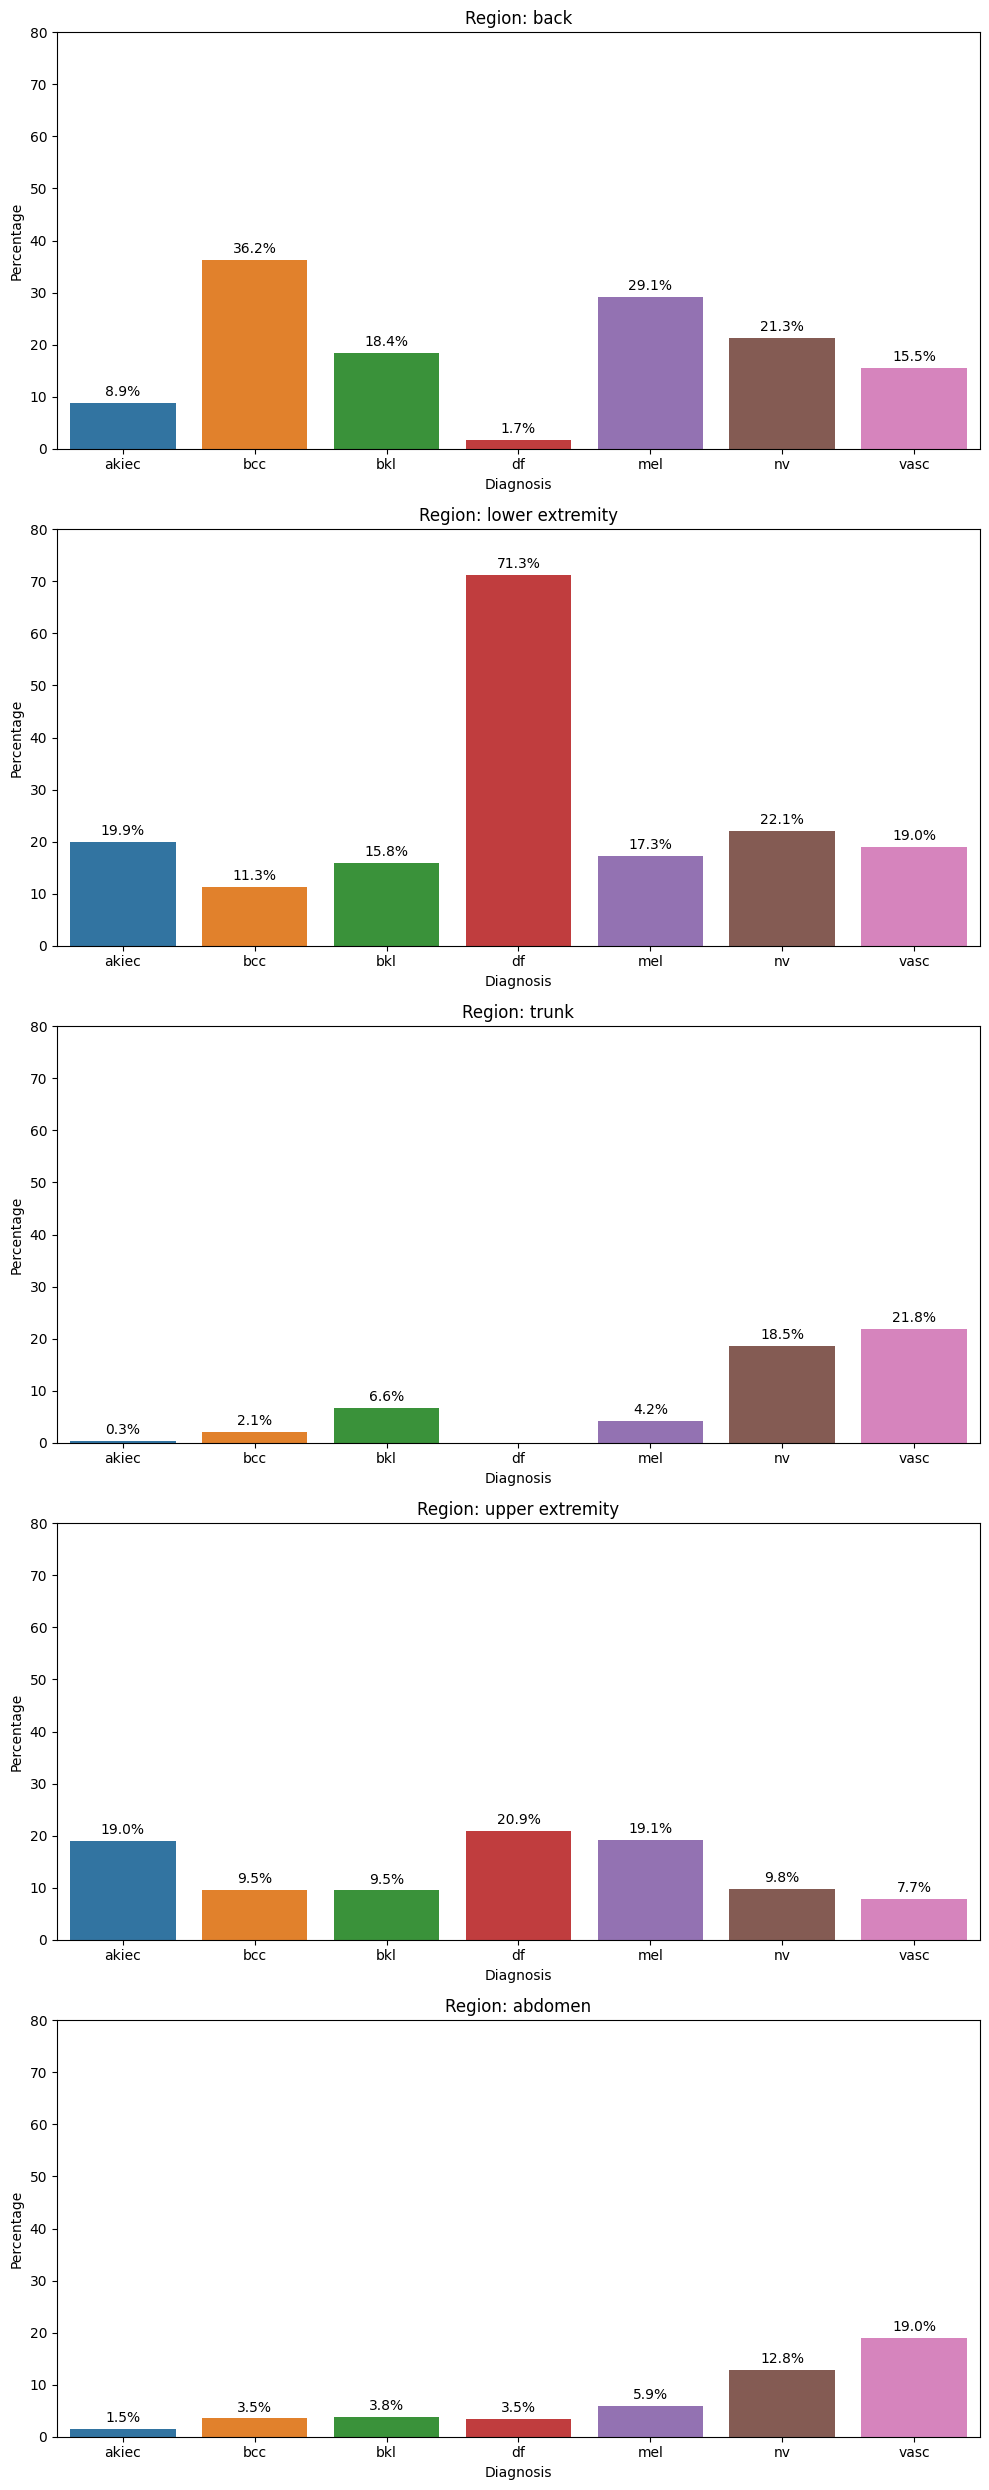

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming df is your DataFrame
# df = pd.read_csv('your_data.csv')

# Calculate the value counts and percentages for 'Region_Of_Disease' grouped by 'Diagnosis'
localization_dx_counts = df.groupby(['Region_Of_Disease', 'Diagnosis']).size().unstack().fillna(0)
localization_dx_percentages = localization_dx_counts.apply(lambda x: (x / x.sum()) * 100, axis=0).stack().reset_index()
localization_dx_percentages.columns = ['Region_Of_Disease', 'Diagnosis', 'percentage']

# Get the top five regions of disease
top_localizations = df['Region_Of_Disease'].value_counts().nlargest(5).index

# Filter the data to include only the top five regions of disease
filtered_data = localization_dx_percentages[localization_dx_percentages['Region_Of_Disease'].isin(top_localizations)]

# Set up the subplots
num_plots = len(top_localizations)
fig, axes = plt.subplots(nrows=num_plots, figsize=(10, num_plots * 5))  # Adjusting the figure size for better visibility

# Create a bar plot for each region of disease
for ax, localization in zip(axes, top_localizations):
    data = filtered_data[filtered_data['Region_Of_Disease'] == localization]
    sns.barplot(x='Diagnosis', y='percentage', data=data, palette='tab10', ax=ax)
    ax.set_title(f'Region: {localization}')
    ax.set_xlabel('Diagnosis')
    ax.set_ylabel('Percentage')
    ax.set_ylim(0, 80)  # Set y-axis limit for better comparison

    # Annotate the bars with the percentage values
    for p in ax.patches:
        height = p.get_height()
        if height > 0:  # Only annotate if the percentage is greater than 0
            ax.annotate(f'{height:.1f}%', (p.get_x() + p.get_width() / 2., height),
                        ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 5),
                        textcoords='offset points')

plt.tight_layout()
plt.show()


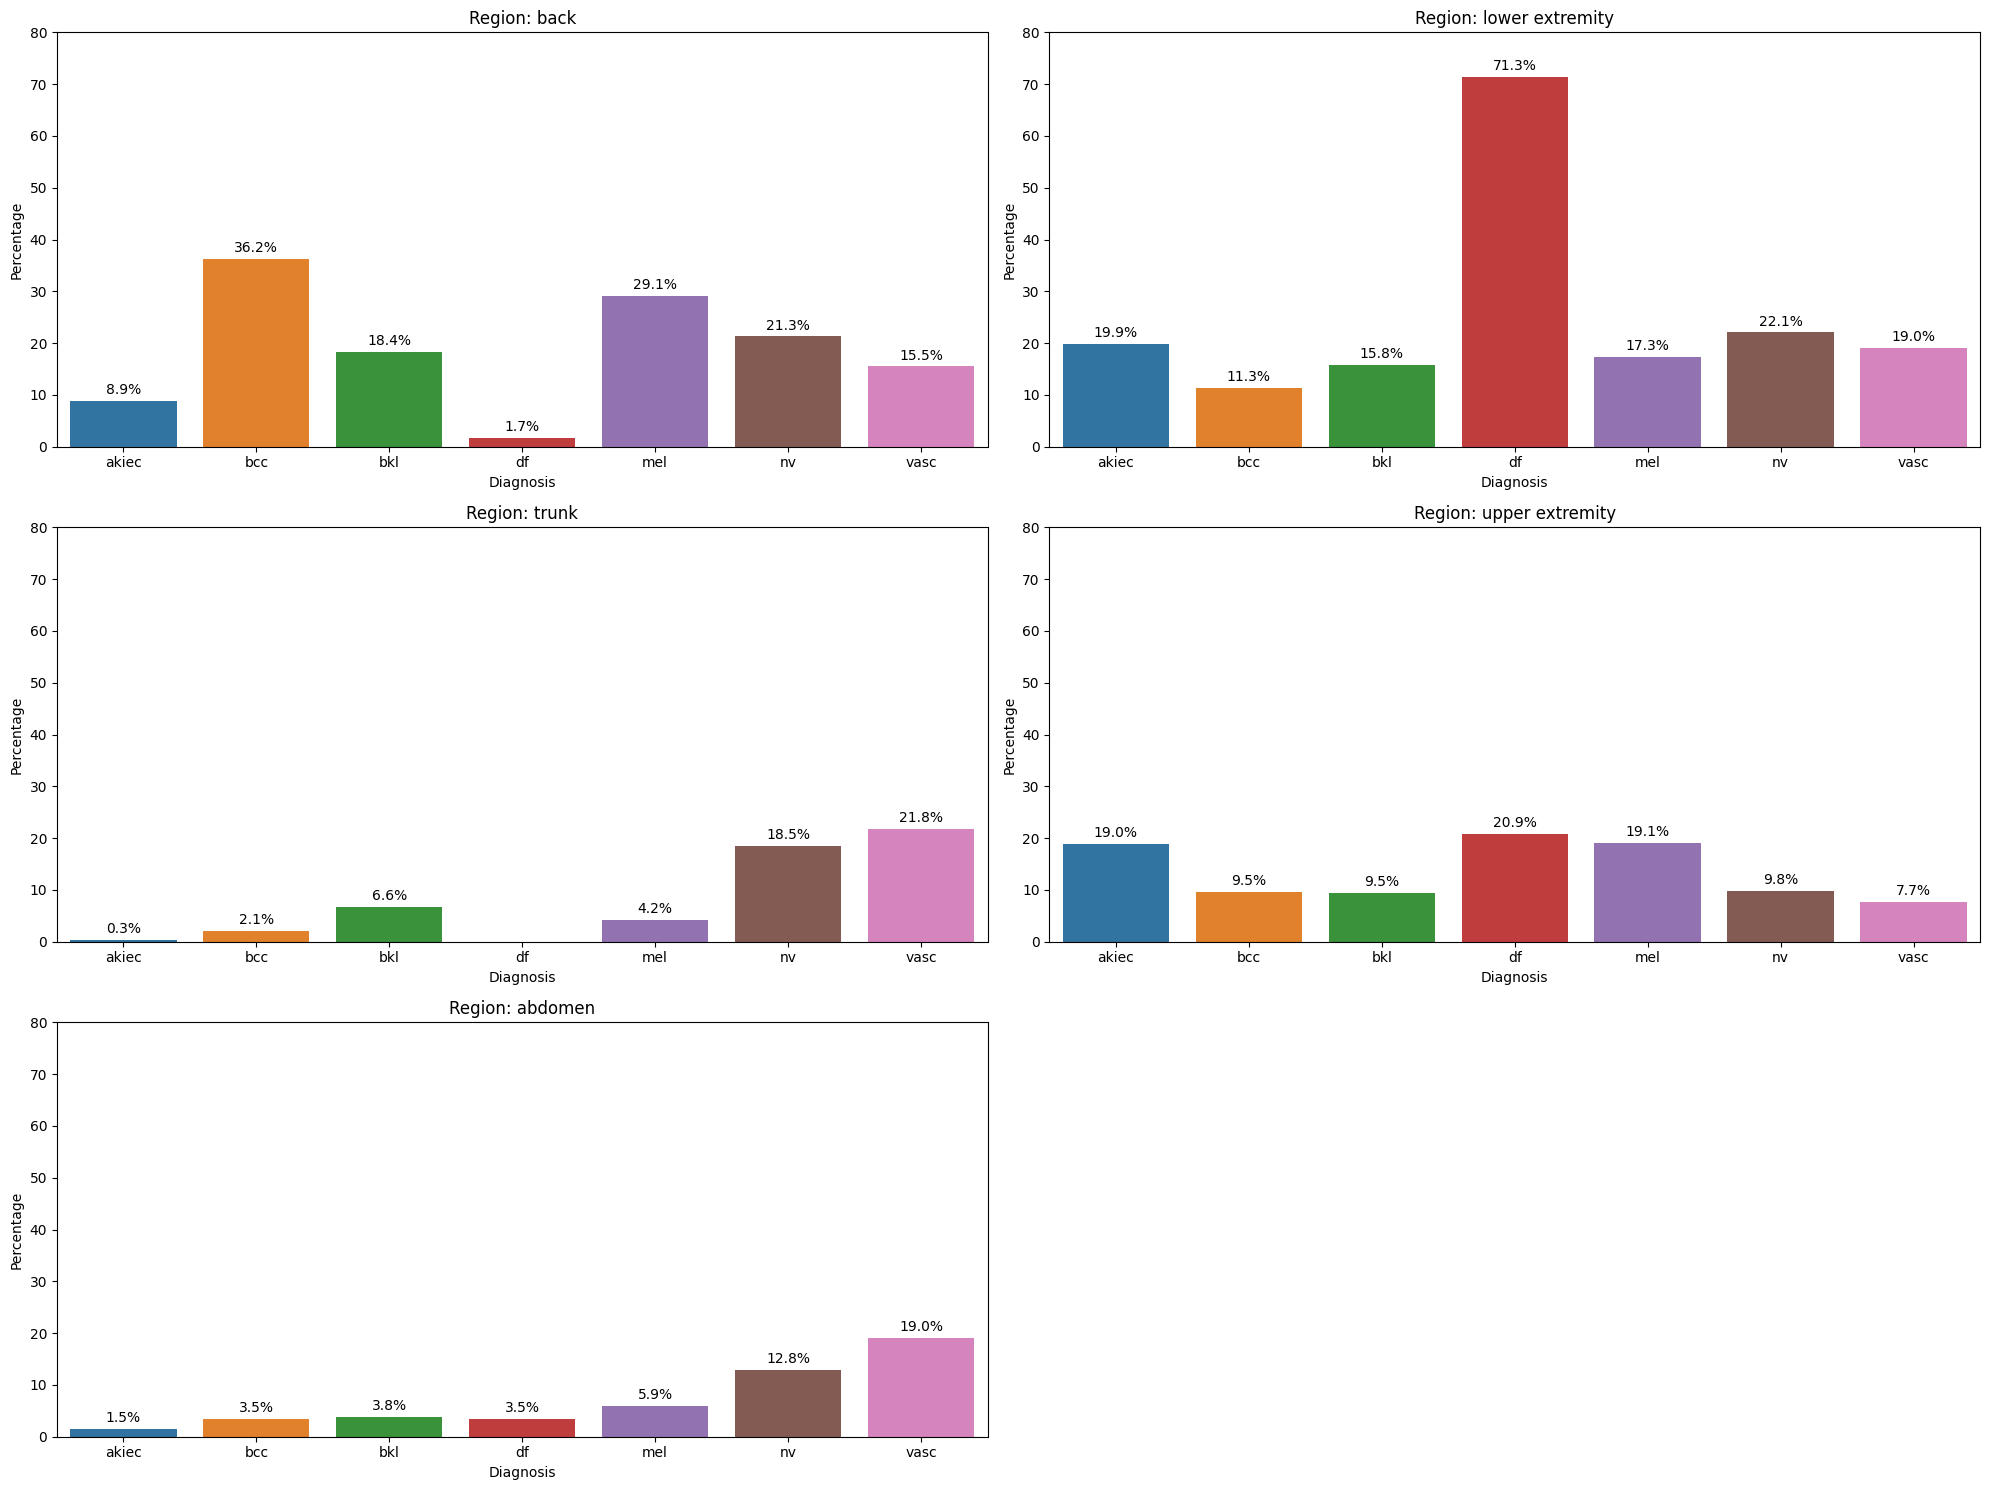

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming df is your DataFrame
# df = pd.read_csv('your_data.csv')

# Calculate the value counts and percentages for 'Region_Of_Disease' grouped by 'Diagnosis'
localization_dx_counts = df.groupby(['Region_Of_Disease', 'Diagnosis']).size().unstack().fillna(0)
localization_dx_percentages = localization_dx_counts.apply(lambda x: (x / x.sum()) * 100, axis=0).stack().reset_index()
localization_dx_percentages.columns = ['Region_Of_Disease', 'Diagnosis', 'percentage']

# Get the top five regions of disease
top_localizations = df['Region_Of_Disease'].value_counts().nlargest(5).index

# Filter the data to include only the top five regions of disease
filtered_data = localization_dx_percentages[localization_dx_percentages['Region_Of_Disease'].isin(top_localizations)]

# Set up the subplots
num_plots = len(top_localizations)
fig, axes = plt.subplots(nrows=(num_plots + 1) // 2, ncols=2, figsize=(20, (num_plots + 1) // 2 * 5))  # Adjusting the figure size for better visibility
axes = axes.flatten()  # Flatten axes array for easy iteration

# Create a bar plot for each region of disease
for ax, localization in zip(axes, top_localizations):
    data = filtered_data[filtered_data['Region_Of_Disease'] == localization]
    sns.barplot(x='Diagnosis', y='percentage', data=data, palette='tab10', ax=ax)
    ax.set_title(f'Region: {localization}')
    ax.set_xlabel('Diagnosis')
    ax.set_ylabel('Percentage')
    ax.set_ylim(0, 80)  # Set y-axis limit for better comparison

    # Annotate the bars with the percentage values
    for p in ax.patches:
        height = p.get_height()
        if height > 0:  # Only annotate if the percentage is greater than 0
            ax.annotate(f'{height:.1f}%', (p.get_x() + p.get_width() / 2., height),
                        ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 5),
                        textcoords='offset points')

# Hide any unused subplots
for ax in axes[num_plots:]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()


<ipython-input-13-17c0938165af>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Diagnosis', y='percentage', data=data, palette='tab10', ax=ax)


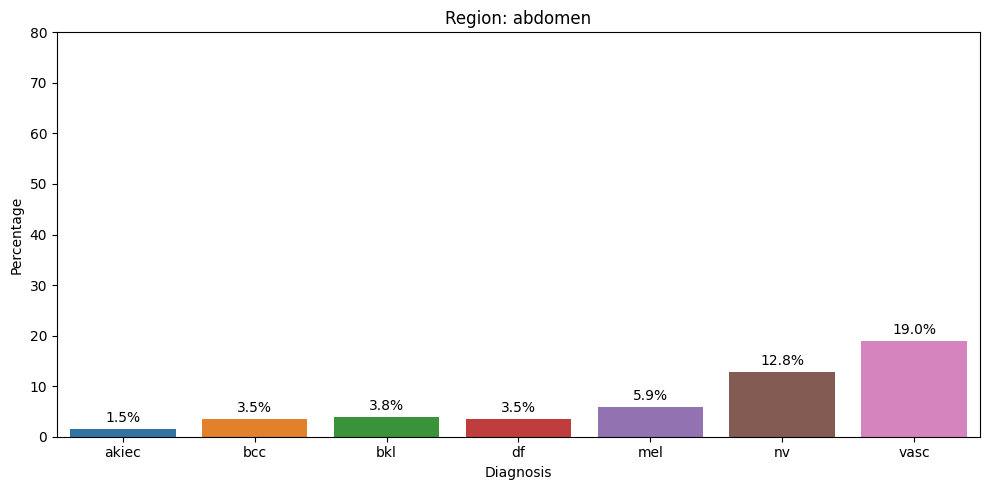

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming df is your DataFrame
# df = pd.read_csv('your_data.csv')

# Calculate the value counts and percentages for 'Region_Of_Disease' grouped by 'Diagnosis'
localization_dx_counts = df.groupby(['Region_Of_Disease', 'Diagnosis']).size().unstack().fillna(0)
localization_dx_percentages = localization_dx_counts.apply(lambda x: (x / x.sum()) * 100, axis=0).stack().reset_index()
localization_dx_percentages.columns = ['Region_Of_Disease', 'Diagnosis', 'percentage']

# Get the top five regions of disease
top_localizations = df['Region_Of_Disease'].value_counts().nlargest(5).index

# Filter the data to include only the top five regions of disease
filtered_data = localization_dx_percentages[localization_dx_percentages['Region_Of_Disease'].isin(top_localizations)]

# Set up the subplot for the last region
fig, ax = plt.subplots(figsize=(10, 5))

# Get the last localization
last_localization = top_localizations[-1]
data = filtered_data[filtered_data['Region_Of_Disease'] == last_localization]

# Create the bar plot for the last region of disease
sns.barplot(x='Diagnosis', y='percentage', data=data, palette='tab10', ax=ax)
ax.set_title(f'Region: {last_localization}')
ax.set_xlabel('Diagnosis')
ax.set_ylabel('Percentage')
ax.set_ylim(0, 80)  # Set y-axis limit for better comparison

# Annotate the bars with the percentage values
for p in ax.patches:
    height = p.get_height()
    if height > 0:  # Only annotate if the percentage is greater than 0
        ax.annotate(f'{height:.1f}%', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 5),
                    textcoords='offset points')

plt.tight_layout()
plt.show()


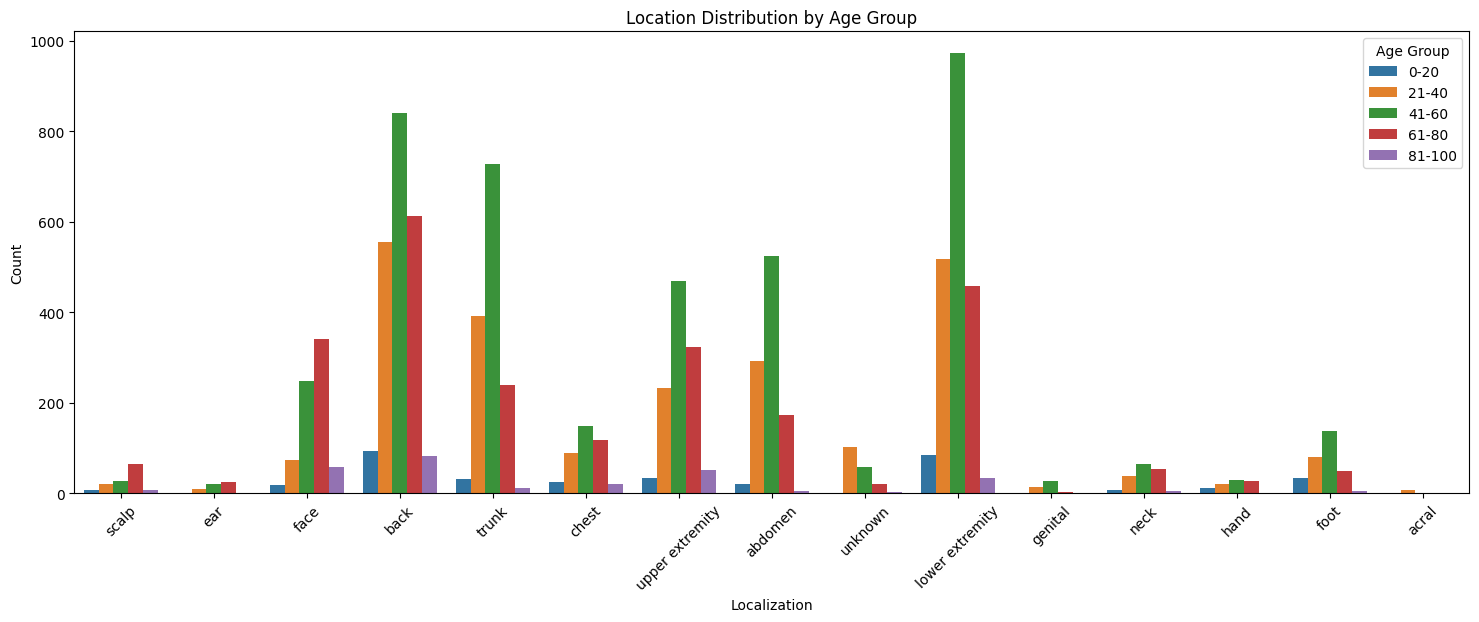

In [ ]:
# Assuming 'age' column contains numerical values, create age groups
age_groups = pd.cut(df['age'], bins=[0, 20, 40, 60, 80, 100], labels=['0-20', '21-40', '41-60', '61-80', '81-100'])

# Add the age groups as a new column in the DataFrame
df['age_group'] = age_groups

# Visualizing relationships between categorical columns and age groups
plt.figure(figsize=(18, 6))
sns.countplot(data=df, x='localization', hue='age_group')
plt.title('Location Distribution by Age Group')
plt.xlabel('Localization')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Age Group')
plt.show()

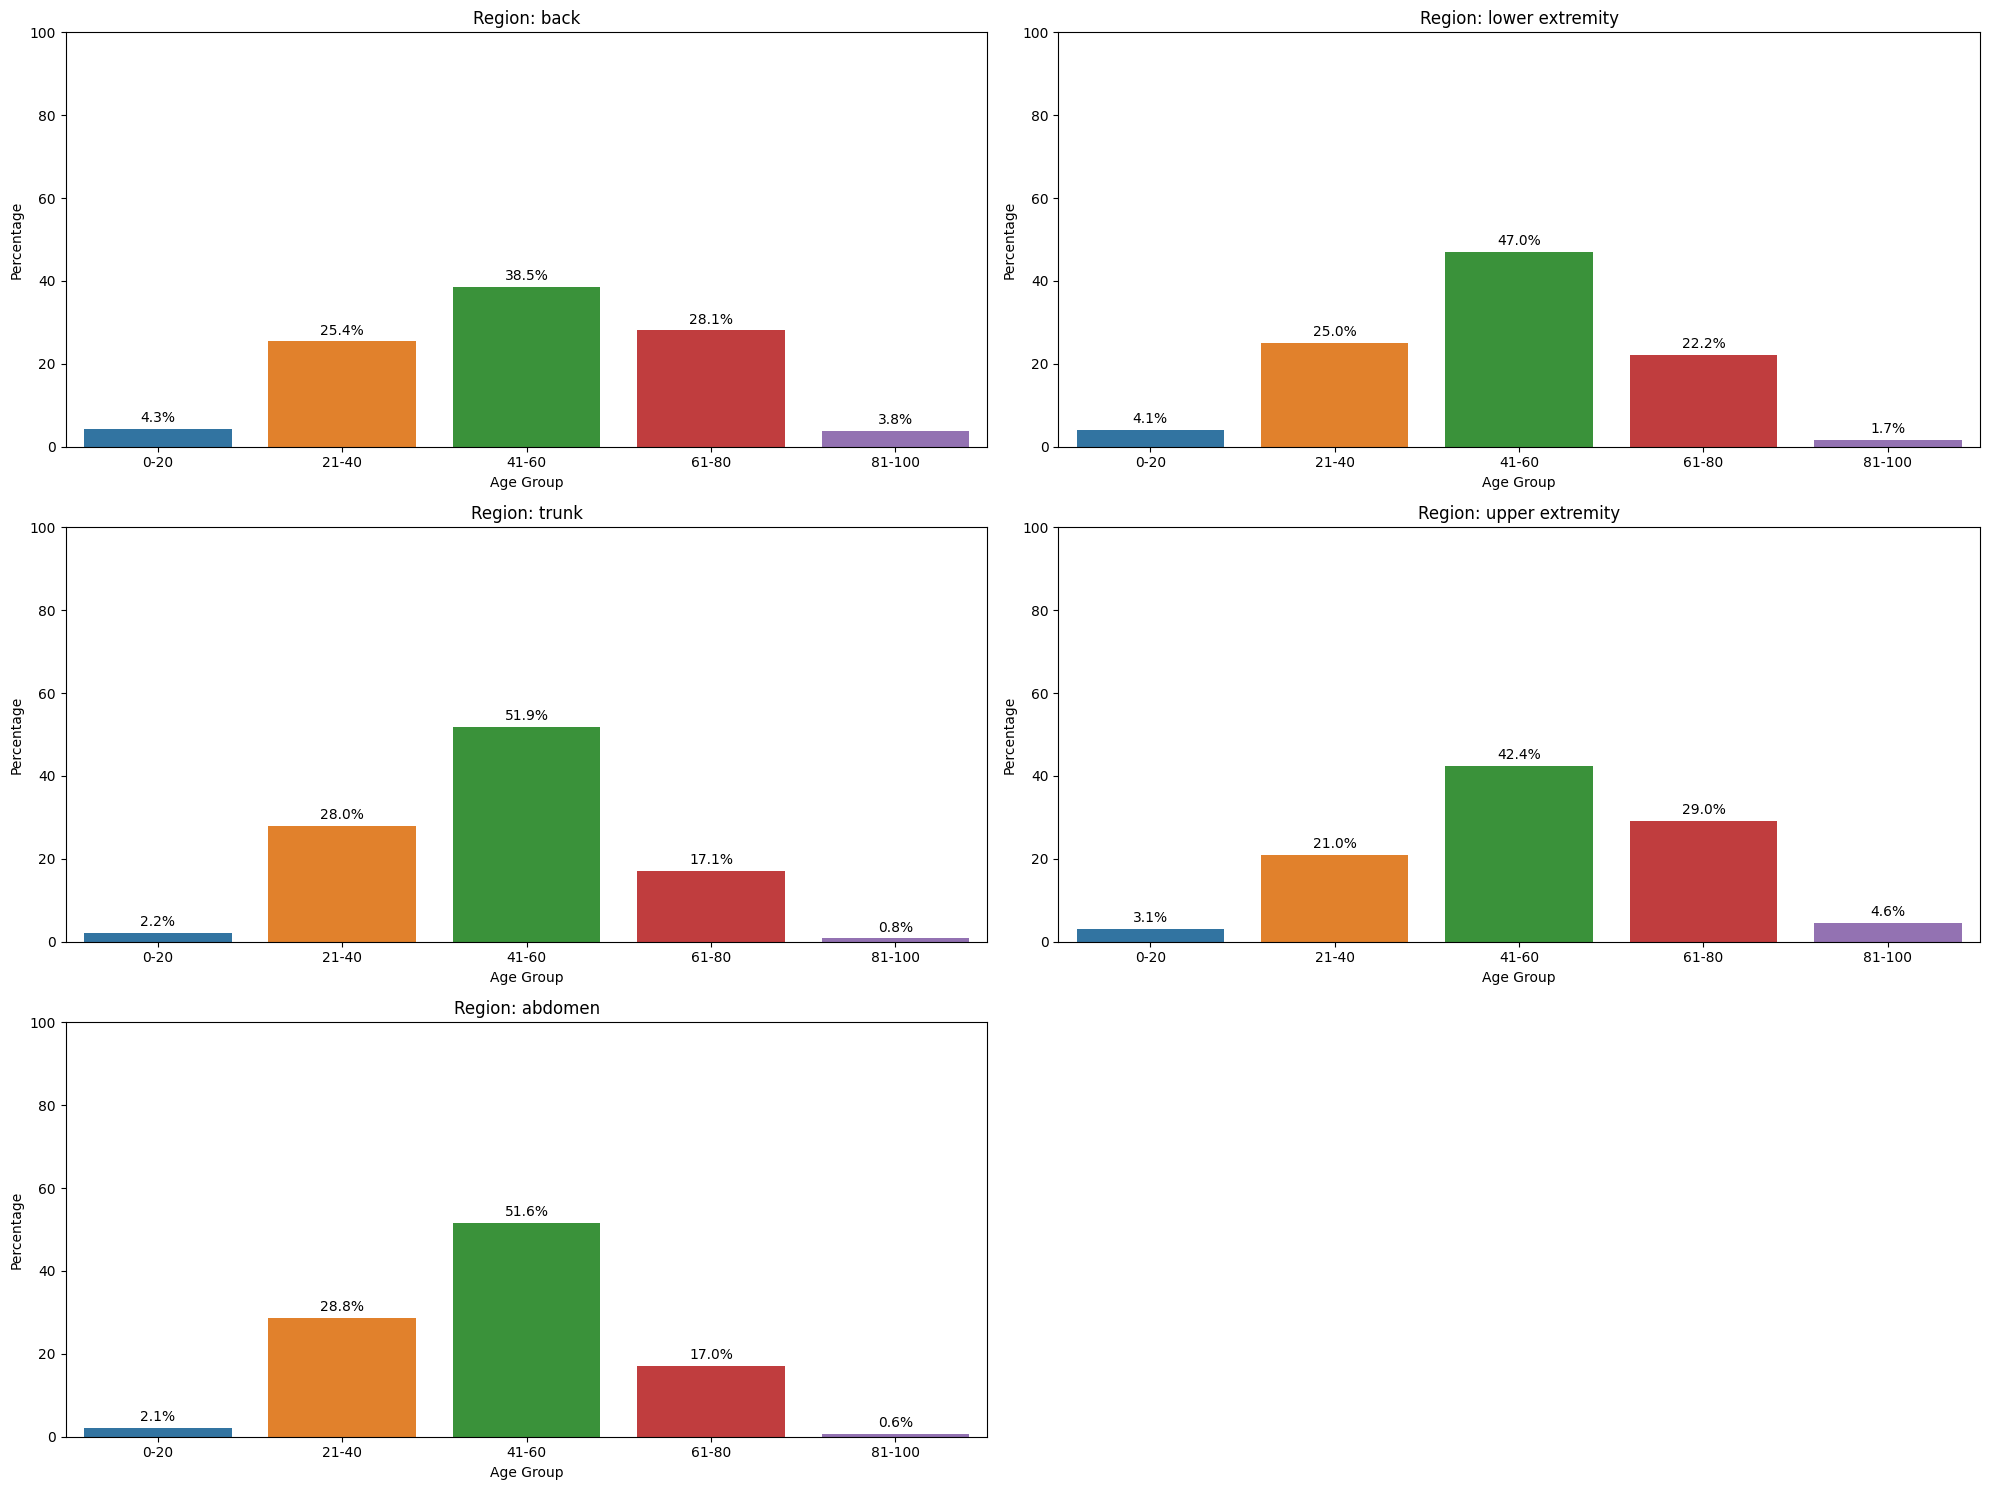

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming df is your DataFrame
# df = pd.read_csv('your_data.csv')

# Assuming 'age' column contains numerical values, create age groups
age_groups = pd.cut(df['Age'], bins=[0, 20, 40, 60, 80, 100], labels=['0-20', '21-40', '41-60', '61-80', '81-100'])

# Add the age groups as a new column in the DataFrame
df['age_group'] = age_groups

# Get the top five localizations
top_localizations = df['Region_Of_Disease'].value_counts().nlargest(5).index

# Filter the data to include only the top five localizations
filtered_data = df[df['Region_Of_Disease'].isin(top_localizations)]

# Set up the subplots
num_plots = len(top_localizations)
fig, axes = plt.subplots(nrows=(num_plots + 1) // 2, ncols=2, figsize=(20, (num_plots + 1) // 2 * 5))  # Adjusting the figure size for better visibility
axes = axes.flatten()  # Flatten axes array for easy iteration

# Create a bar plot for each localization
for ax, localization in zip(axes, top_localizations):
    data = filtered_data[filtered_data['Region_Of_Disease'] == localization]
    age_group_counts = data['age_group'].value_counts(normalize=True) * 100  # Calculate percentages
    sns.barplot(x=age_group_counts.index, y=age_group_counts.values, palette='tab10', ax=ax)
    ax.set_title(f'Region: {localization}')
    ax.set_xlabel('Age Group')
    ax.set_ylabel('Percentage')
    ax.set_ylim(0, 100)  # Set y-axis limit to 100% for better comparison

    # Annotate the bars with the percentage values
    for p in ax.patches:
        height = p.get_height()
        if height > 0:  # Only annotate if the percentage is greater than 0
            ax.annotate(f'{height:.1f}%', (p.get_x() + p.get_width() / 2., height),
                        ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 5),
                        textcoords='offset points')

# Hide any unused subplots
for ax in axes[num_plots:]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()


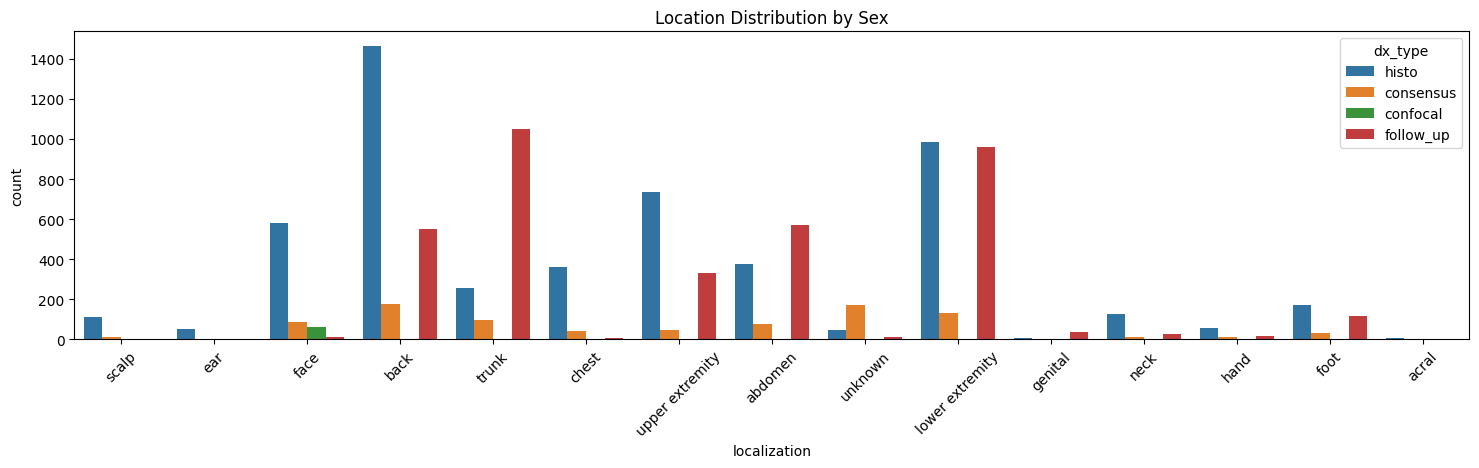

In [ ]:
# Visualizing relationships between categorical columns
plt.figure(figsize=(18, 4))
sns.countplot(data=df, x='localization', hue='dx_type')
plt.title('Location Distribution by Sex')
plt.xticks(rotation=45)
plt.show()

In [ ]:
df.head(5)

lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

        dataset                                               path  \
0  vidir_modern  /content/drive/My Drive/Research/HAM10000_imag...   
1  vidir_modern  /content/drive/My Drive/Research/HAM10000_imag...   
2  vidir_modern  /content/drive/My Drive/Research/HAM10000_imag...   
3  vidir_modern  /content/drive/My Drive/Research/HAM10000_imag...   
4  vidir_modern  /content/drive/My Drive/Research/HAM10000_imag...   

                                               image  
0  [[[191, 152, 192], [194, 154, 193], [196, 152,...  
1  [[[24, 14, 29], [56, 39, 64], [106, 80, 112], ...  
2  [[[190, 136, 150], [199, 145, 161], [200, 141,...  
3  [[[35, 18, 28], [83, 51, 64], [128, 88, 103], ...  
4  [[[155, 110, 135], [188, 139, 168], [210, 157,...

## Handle Missing Value

In [ ]:
# Handle Missing Entries using the median
# Fill missing values in 'age' column with the median age
df['age'].fillna(df['age'].median(), inplace=True)

# Convert 'age' column to integer type
df['age'] = df['age'].astype(int)

In [ ]:
# Rename Columns
df = df.rename(columns={
    'lesion_id': 'Lesion_Id',
    'image_id': 'Image_Id',
    'dx': 'Diagnosis',
    'dx_type': 'Confirmation_Method',
    'age': 'Age',
    'sex': 'Sex',
    'localization': 'Region_Of_Disease',
    'dataset': 'Dataset',
    'age_group': 'Age_Group',
    'path': 'Path',
    'image': 'Image'
})

In [ ]:
print(df.dtypes)


lesion_id       object
image_id        object
dx              object
dx_type         object
age              int64
sex             object
localization    object
dataset         object
path            object
image           object
dtype: object


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Lesion_Id            10015 non-null  object
 1   Image_Id             10015 non-null  object
 2   Diagnosis            10015 non-null  object
 3   Confirmation_Method  10015 non-null  object
 4   Age                  10015 non-null  int64 
 5   Sex                  10015 non-null  object
 6   Region_Of_Disease    10015 non-null  object
 7   Dataset              10015 non-null  object
dtypes: int64(1), object(7)
memory usage: 626.1+ KB


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Lesion_Id            10015 non-null  object
 1   Image_Id             10015 non-null  object
 2   Diagnosis            10015 non-null  object
 3   Confirmation_Method  10015 non-null  object
 4   Age                  10015 non-null  int64 
 5   Sex                  10015 non-null  object
 6   Region_Of_Disease    10015 non-null  object
 7   Dataset              10015 non-null  object
 8   label                10015 non-null  int64 
 9   Path                 10015 non-null  object
 10  Image                10015 non-null  object
dtypes: int64(2), object(9)
memory usage: 860.8+ KB


In [ ]:
# Define the mapping of current values to new values
diagnosis_mapping = {
    'mel': 'Melanoma',
    'bkl': 'Benign Keratosis-Like Lesions',
    'bcc': 'Basal Cell Carcinoma',
    'akiec': 'Actinic Keratoses',
    'vasc': 'Vascular Lesions',
    'df': 'Dermatofibroma',
    'nv': 'Melanocytic Nevi'
}

# Create a new column with the updated diagnosis names
df['Updated_Diagnosis'] = df['Diagnosis'].map(diagnosis_mapping)

In [ ]:
df

Lesion_Id      Image_Id Diagnosis Confirmation_Method  Age     Sex  \
0      HAM_0000118  ISIC_0027419       bkl               histo   80    male   
1      HAM_0000118  ISIC_0025030       bkl               histo   80    male   
2      HAM_0002730  ISIC_0026769       bkl               histo   80    male   
3      HAM_0002730  ISIC_0025661       bkl               histo   80    male   
4      HAM_0001466  ISIC_0031633       bkl               histo   75    male   
...            ...           ...       ...                 ...  ...     ...   
10010  HAM_0002867  ISIC_0033084     akiec               histo   40    male   
10011  HAM_0002867  ISIC_0033550     akiec               histo   40    male   
10012  HAM_0002867  ISIC_0033536     akiec               histo   40    male   
10013  HAM_0000239  ISIC_0032854     akiec               histo   80    male   
10014  HAM_0003521  ISIC_0032258       mel               histo   70  female   

      Region_Of_Disease       Dataset  
0                 scalp  vidir_modern  
1                 scalp  vidir_modern  
2                 scalp  vidir_modern  
3                 scalp  vidir_modern  
4                   ear  vidir_modern  
...                 ...           ...  
10010           abdomen  vidir_modern  
10011           abdomen  vidir_modern  
10012           abdomen  vidir_modern  
10013              face  vidir_modern  
10014              back  vidir_modern  

[10015 rows x 8 columns]

## Class Distribution

Updated_Diagnosis
Melanocytic Nevi                 6705
Melanoma                         1113
Benign Keratosis-Like Lesions    1099
Basal Cell Carcinoma              514
Actinic Keratoses                 327
Vascular Lesions                  142
Dermatofibroma                    115
Name: count, dtype: int64


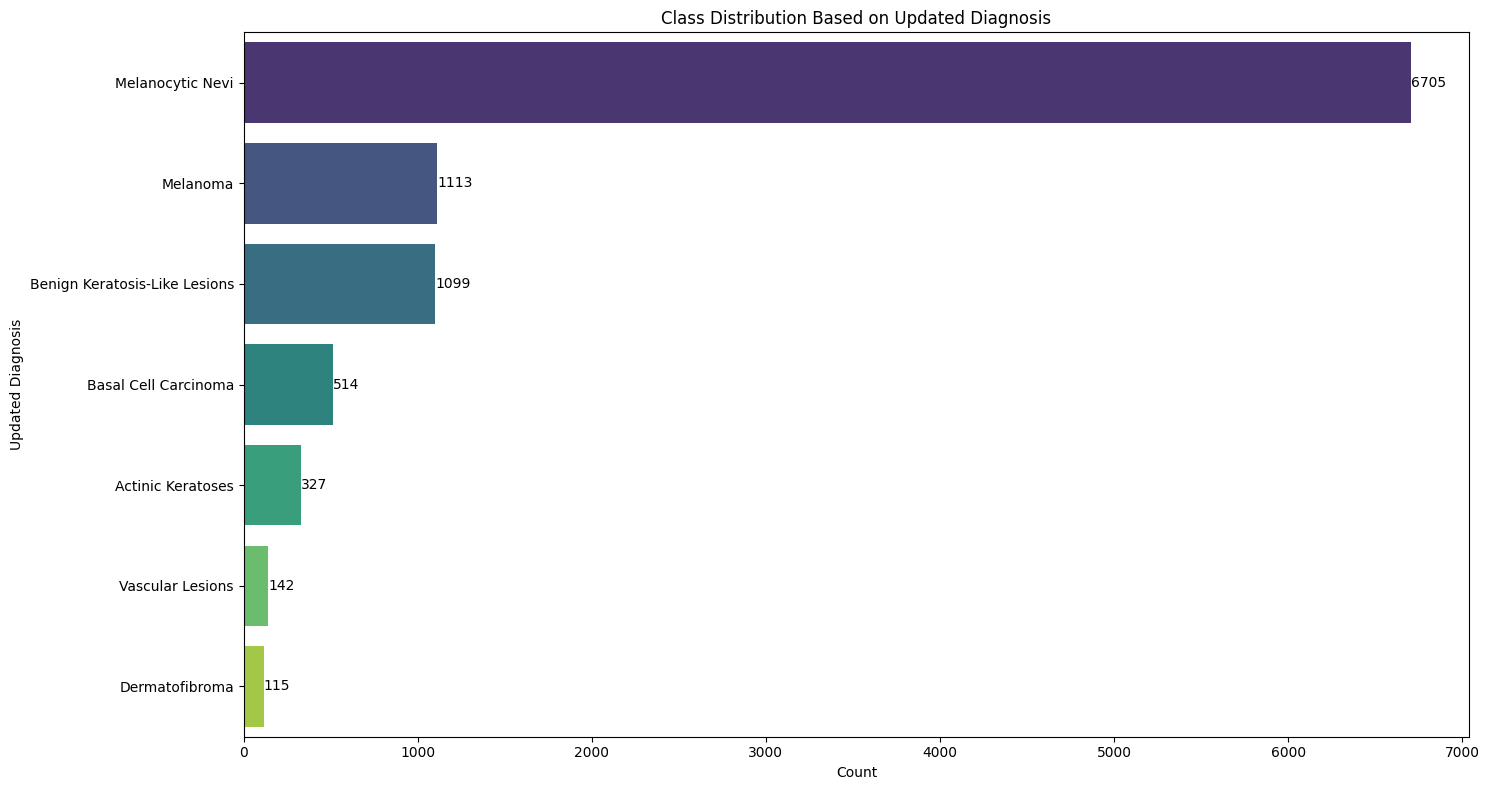

In [ ]:
# Check class distribution
class_distribution = df['Updated_Diagnosis'].value_counts()
print(class_distribution)

# Sort the class distribution by counts
sorted_classes = class_distribution.index

# Visualize class distribution with exchanged axes
plt.figure(figsize=(15, 8))
sns.countplot(y='Updated_Diagnosis', data=df, order=sorted_classes, palette='viridis')
plt.title('Class Distribution Based on Updated Diagnosis')
plt.xlabel('Count')
plt.ylabel('Updated Diagnosis')

# Add counts next to the bars
for patch in plt.gca().patches:
    plt.gca().text(patch.get_width() + 1,
                   patch.get_y() + patch.get_height() / 2,
                   int(patch.get_width()),
                   ha='left', va='center')

plt.tight_layout()
plt.show()

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
        Lesion_Id      Image_Id Diagnosis Confirmation_Method  Age     Sex  \
1617  HAM_0007180  ISIC_0033272       mel               histo   65    male   
8128  HAM_0007195  ISIC_0031923        nv               histo   40  female   
2168  HAM_0001835  ISIC_0026652       mel               histo   65    male   
1090  HAM_0000465  ISIC_0030583       bkl           consensus   35  female   
7754  HAM_0001720  ISIC_0034010        nv               histo   45    male   
8071  HAM_0006333  ISIC_0024424        nv               histo   35    male   
7423  HAM_0004548  ISIC_0032832        nv               histo   45  female   
8984  HAM_0006526  ISIC_0026671        nv               histo   55    male   
2310  HAM_0003102  ISIC_0032389       mel               histo   65    male   
7256  HAM_0004260  ISIC_0025525        nv               histo   65    male   

     Region_Of_Disease        Dataset  \
1617              face   vidir_modern   
8128   l

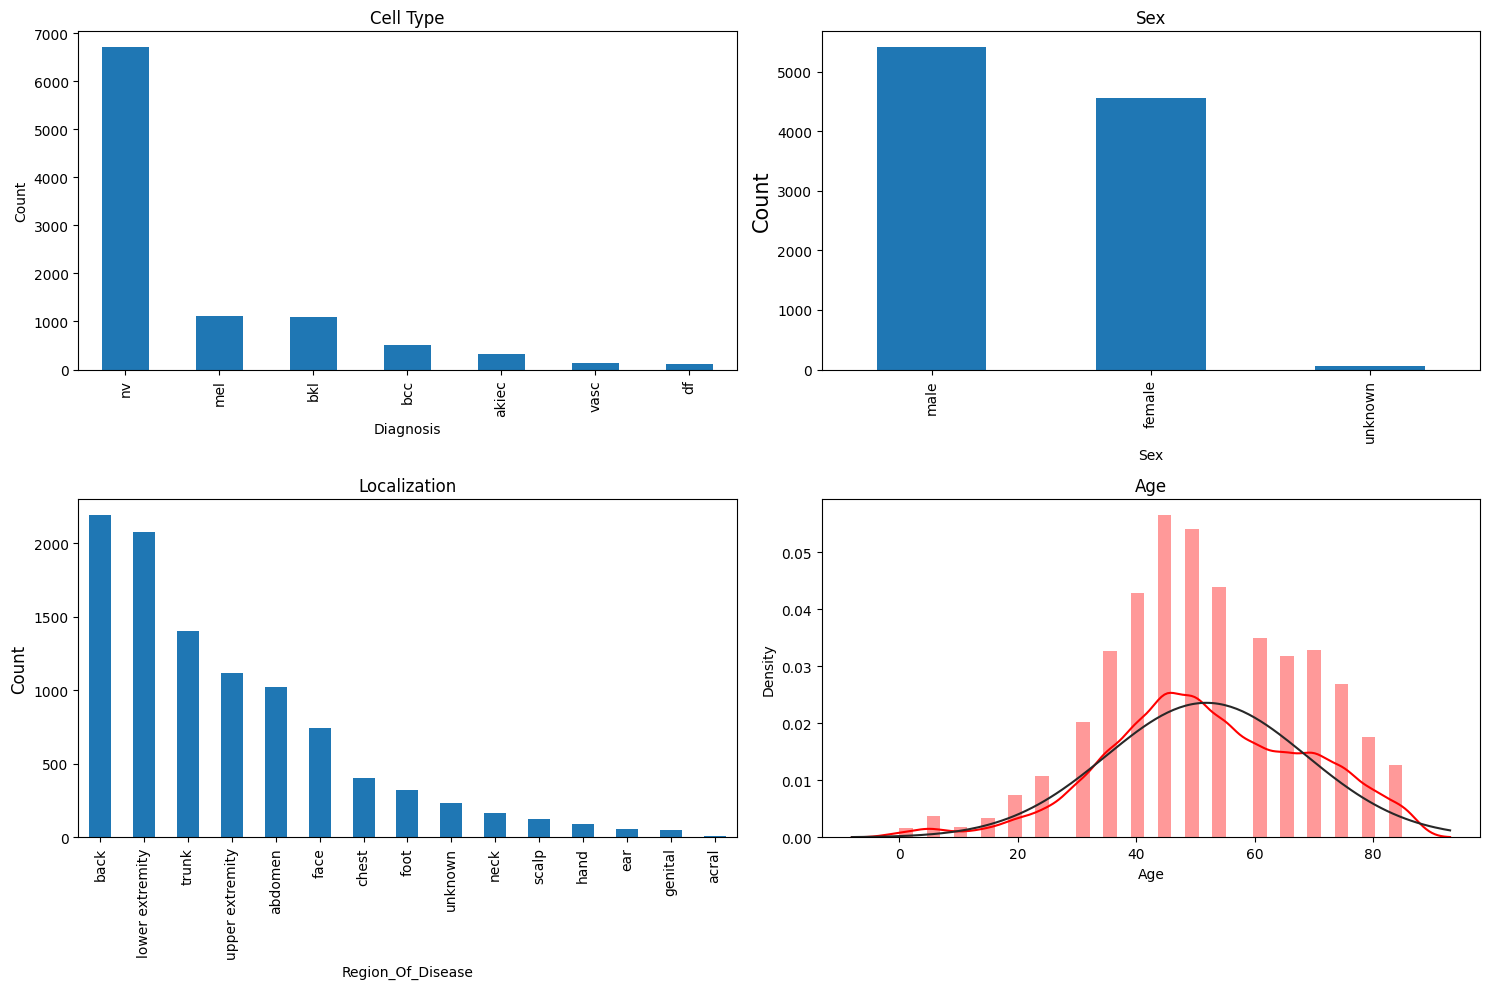

label
5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: count, dtype: int64


In [ ]:
from sklearn.preprocessing import LabelEncoder
from scipy import stats
import warnings
import seaborn as sns

# Suppress warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Resize parameter
SIZE=32

# Label encoding to numeric values from text
le = LabelEncoder()
le.fit(df['Diagnosis'])
df['label'] = le.transform(df["Diagnosis"])
print(list(le.classes_))
print(df.sample(10))

# Data distribution visualization
fig = plt.figure(figsize=(15,10))

ax1 = fig.add_subplot(221)
df['Diagnosis'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Cell Type')

ax2 = fig.add_subplot(222)
df['Sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Count', size=15)
ax2.set_title('Sex')

ax3 = fig.add_subplot(223)
df['Region_Of_Disease'].value_counts().plot(kind='bar', ax=ax3)
ax3.set_ylabel('Count',size=12)
ax3.set_title('Localization')

ax4 = fig.add_subplot(224)
sample_age = df[pd.notnull(df['Age'])]
sns.distplot(sample_age['Age'], fit=stats.norm, color='red', ax=ax4)
ax4.set_title('Age')

plt.tight_layout()
plt.show()


# Distribution of data into various classes
print(df['label'].value_counts())

In [ ]:
df.columns

Index(['Lesion_Id', 'Image_Id', 'Diagnosis', 'Confirmation_Method', 'Age',
       'Sex', 'Region_Of_Disease', 'Dataset', 'Path', 'Image',
       'Updated_Diagnosis', 'label'],
      dtype='object')

In [ ]:
df

Lesion_Id      Image_Id Diagnosis Confirmation_Method  Age     Sex  \
0      HAM_0000118  ISIC_0027419       bkl               histo   80    male   
1      HAM_0000118  ISIC_0025030       bkl               histo   80    male   
2      HAM_0002730  ISIC_0026769       bkl               histo   80    male   
3      HAM_0002730  ISIC_0025661       bkl               histo   80    male   
4      HAM_0001466  ISIC_0031633       bkl               histo   75    male   
...            ...           ...       ...                 ...  ...     ...   
10010  HAM_0002867  ISIC_0033084     akiec               histo   40    male   
10011  HAM_0002867  ISIC_0033550     akiec               histo   40    male   
10012  HAM_0002867  ISIC_0033536     akiec               histo   40    male   
10013  HAM_0000239  ISIC_0032854     akiec               histo   80    male   
10014  HAM_0003521  ISIC_0032258       mel               histo   70  female   

      Region_Of_Disease       Dataset  \
0                 scalp  vidir_modern   
1                 scalp  vidir_modern   
2                 scalp  vidir_modern   
3                 scalp  vidir_modern   
4                   ear  vidir_modern   
...                 ...           ...   
10010           abdomen  vidir_modern   
10011           abdomen  vidir_modern   
10012           abdomen  vidir_modern   
10013              face  vidir_modern   
10014              back  vidir_modern   

                                                    Path  \
0      /content/drive/My Drive/Research/HAM10000_imag...   
1      /content/drive/My Drive/Research/HAM10000_imag...   
2      /content/drive/My Drive/Research/HAM10000_imag...   
3      /content/drive/My Drive/Research/HAM10000_imag...   
4      /content/drive/My Drive/Research/HAM10000_imag...   
...                                                  ...   
10010  /content/drive/My Drive/Research/HAM10000_imag...   
10011  /content/drive/My Drive/Research/HAM10000_imag...   
10012  /content/drive/My Drive/Research/HAM10000_imag...   
10013  /content/drive/My Drive/Research/HAM10000_imag...   
10014  /content/drive/My Drive/Research/HAM10000_imag...   

                                                   Image  \
0      [[[0.73333335, 0.5803922, 0.74509805], [0.7490...   
1      [[[0.09803922, 0.05490196, 0.09019608], [0.258...   
2      [[[0.57254905, 0.52156866, 0.7294118], [0.6156...   
3      [[[0.105882354, 0.0627451, 0.12156863], [0.274...   
4      [[[0.5254902, 0.43137255, 0.6], [0.67058825, 0...   
...                                                  ...   
10010  [[[0.76862746, 0.69411767, 0.7529412], [0.7647...   
10011  [[[0.011764706, 0.02745098, 0.019607844], [0.0...   
10012  [[[0.50980395, 0.49019608, 0.5176471], [0.5372...   
10013  [[[0.5686275, 0.48235294, 0.627451], [0.596078...   
10014  [[[0.47058824, 0.54509807, 0.6784314], [0.5137...   

                   Updated_Diagnosis  label  
0      Benign Keratosis-Like Lesions      2  
1      Benign Keratosis-Like Lesions      2  
2      Benign Keratosis-Like Lesions      2  
3      Benign Keratosis-Like Lesions      2  
4      Benign Keratosis-Like Lesions      2  
...                              ...    ...  
10010              Actinic Keratoses      0  
10011              Actinic Keratoses      0  
10012              Actinic Keratoses      0  
10013              Actinic Keratoses      0  
10014                       Melanoma      4  

[10015 rows x 12 columns]

## Conver to Irregular Datset

In [ ]:
pip install scikit-image networkx


In [ ]:
import os
from glob import glob
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from skimage.segmentation import slic
from skimage.color import rgb2lab
import networkx as nx
from collections import Counter
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Resize parameter
SIZE = 32

# Define image directory paths
image_dir_part_1 = '/content/drive/My Drive/Research/HAM10000_images_part_1'
image_dir_part_2 = '/content/drive/My Drive/Research/HAM10000_images_part_2'

# Check if the directories exist
for image_dir in [image_dir_part_1, image_dir_part_2]:
    if not os.path.exists(image_dir):
        raise FileNotFoundError(f"Directory does not exist: {image_dir}")

# Create a dictionary mapping image IDs to their paths
image_paths_part_1 = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join(image_dir_part_1, '*.jpg'))}
image_paths_part_2 = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join(image_dir_part_2, '*.jpg'))}

# Combine dictionaries
image_path = {**image_paths_part_1, **image_paths_part_2}


# Label encoding to numeric values from text
le = LabelEncoder()
# le.fit(df['Diagnosis'])
# df['label'] = le.transform(df["Diagnosis"])
df['Diagnosis'] = le.fit_transform(df['Diagnosis'])
print("Classes:", list(le.classes_))

# Map image paths to the DataFrame
df['Path'] = df['Image_Id'].map(image_path)

# Check if any paths are missing
missing_paths = df['Path'].isnull().sum()
if missing_paths > 0:
    print(f"Warning: {missing_paths} image paths are missing!")

# Remove rows with missing image paths
df = df.dropna(subset=['Path'])

# Function to load and resize images
def load_and_resize_image(image_path, size=(SIZE, SIZE)):
    try:
        img = Image.open(image_path)
        img = img.resize(size)
        img = np.asarray(img).astype('float32') / 255.0  # Normalize pixel values to [0, 1]
        return img
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None

# Load and resize images
df['Image'] = df['Path'].apply(load_and_resize_image)

# Remove rows where images failed to load
df = df.dropna(subset=['Image'])

# Reshape the images to flatten them for SMOTE
X = np.array(df['Image'].tolist()).reshape(len(df), -1)
y = df['Diagnosis']

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

print(f"Original dataset shape: {Counter(y)}")
print(f"Resampled dataset shape: {Counter(y_res)}")

# Convert the resampled arrays back to a DataFrame
df_balanced = pd.DataFrame(X_res)
df_balanced['Diagnosis'] = y_res

# Decode the labels to their original class names
df_balanced['Diagnosis_Name'] = le.inverse_transform(df_balanced['Diagnosis'])

# Convert the balanced dataset images back to their original shape
def reshape_and_convert_image(row, size=(SIZE, SIZE, 3)):
    return row.values.reshape(size)

df_balanced['Image'] = df_balanced.drop(columns=['Diagnosis', 'Diagnosis_Name']).apply(reshape_and_convert_image, axis=1)

# Function to create graph from image using superpixels
def image_to_graph(image):
    segments = slic(image, n_segments=100, compactness=10)
    G = nx.Graph()

    image_lab = rgb2lab(image)

    for region in np.unique(segments):
        mask = segments == region
        mean_color = image_lab[mask].mean(axis=0)
        G.add_node(region, feature=mean_color)

    for i, region1 in enumerate(np.unique(segments)):
        for region2 in np.unique(segments):
            if region1 != region2:
                G.add_edge(region1, region2, weight=np.linalg.norm(image_lab[segments == region1].mean(axis=0) - image_lab[segments == region2].mean(axis=0)))

    return G

# Convert images to graphs
df_balanced['Graph'] = df_balanced['Image'].apply(image_to_graph)

# Save the graphs and labels
for idx, row in df_balanced.iterrows():
    graph = row['Graph']
    label = row['label']
    nx.write_gpickle(graph, f'/path/to/graphs/graph_{idx}.gpickle')
    with open(f'/path/to/graphs/graph_{idx}_label.txt', 'w') as f:
        f.write(str(label))

print("Graph conversion complete.")


Classes: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
Original dataset shape: Counter({5: 6705, 4: 1113, 2: 1099, 1: 514, 0: 327, 6: 142, 3: 115})
Resampled dataset shape: Counter({2: 6705, 5: 6705, 3: 6705, 4: 6705, 6: 6705, 1: 6705, 0: 6705})


## Image Preprocessing & Data Balancing

### Using Augementation (1500/per class)

Classes:
 ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
Label to Diagnosis Mapping:

0: akiec
1: bcc
2: bkl
3: df
4: mel
5: nv
6: vasc
Before balancing:
 label
5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: count, dtype: int64
After balancing:
 label
2    1500
5    1500
3    1500
4    1500
6    1500
1    1500
0    1500
Name: count, dtype: int64


<Figure size 1000x800 with 0 Axes>

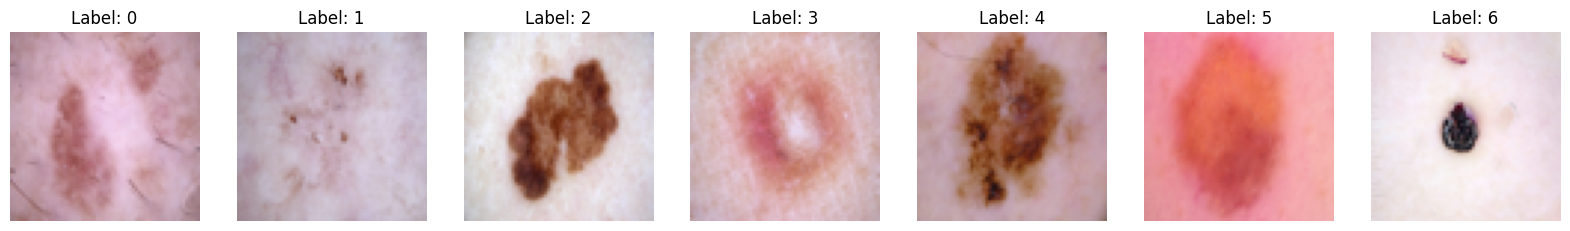

In [ ]:
import os
from glob import glob
from PIL import Image, ImageEnhance, ImageOps
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
from scipy import stats
import warnings
import seaborn as sns

# Suppress warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Resize parameter
SIZE = 32

# Function to balance the dataset using augmentation
def balance_data_with_augmentation(df, label_col, n_samples):
    def augment_image(image):
        # Apply random transformations for augmentation
        if np.random.rand() > 0.5:
            image = ImageOps.flip(image)
        if np.random.rand() > 0.5:
            image = ImageOps.mirror(image)
        if np.random.rand() > 0.5:
            enhancer = ImageEnhance.Contrast(image)
            image = enhancer.enhance(1 + (np.random.rand() - 0.5))
        return image

    dfs = []
    for label in df[label_col].unique():
        df_label = df[df[label_col] == label]
        while len(df_label) < n_samples:
            df_label = pd.concat([df_label, resample(df_label, replace=True, n_samples=n_samples - len(df_label), random_state=42)])
        df_label = df_label.sample(n_samples, random_state=42)
        dfs.append(df_label)
    balanced_df = pd.concat(dfs)
    return balanced_df

# Define image directory paths
image_dir_part_1 = '/content/drive/My Drive/Research/HAM10000_images_part_1'
image_dir_part_2 = '/content/drive/My Drive/Research/HAM10000_images_part_2'

# Check if the directories exist
for image_dir in [image_dir_part_1, image_dir_part_2]:
    if not os.path.exists(image_dir):
        raise FileNotFoundError(f"Directory does not exist: {image_dir}")

# Create a dictionary mapping image IDs to their paths
image_paths_part_1 = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join(image_dir_part_1, '*.jpg'))}
image_paths_part_2 = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join(image_dir_part_2, '*.jpg'))}

# Combine dictionaries
image_path = {**image_paths_part_1, **image_paths_part_2}

# Label encoding to numeric values from text
le = LabelEncoder()
le.fit(df['Diagnosis'])
df['label'] = le.transform(df["Diagnosis"])

print("Classes:\n", list(le.classes_))

# Print the mapping of Label and Diagnosis
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label to Diagnosis Mapping:\n")
for diagnosis, label in label_mapping.items():
    print(f"{label}: {diagnosis}")



# Initialize figure for plotting
fig = plt.figure(figsize=(10, 8))

# Distribution of data into various classes before balancing
print("Before balancing:\n", df['label'].value_counts())

# Map image paths to the DataFrame
df['Path'] = df['Image_Id'].map(image_path)

# Check if any paths are missing
missing_paths = df['Path'].isnull().sum()
if missing_paths > 0:
    print(f"Warning: {missing_paths} image paths are missing!")

# Remove rows with missing image paths
df = df.dropna(subset=['Path'])

# Balance the data with augmentation
df_balanced = balance_data_with_augmentation(df, 'label', 1500)

# Distribution of data into various classes after balancing
print("After balancing:\n", df_balanced['label'].value_counts())

# Function to load and resize images
def load_and_resize_image(image_path, size=(64, 64)):
    try:
        img = Image.open(image_path)
        img = img.resize(size)
        img = np.asarray(img).astype('float32') / 255.0  # Normalize pixel values to [0, 1]
        return img
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None

# Load and resize images
df_balanced['Image'] = df_balanced['Path'].apply(load_and_resize_image)

# Remove rows where images failed to load
df_balanced = df_balanced.dropna(subset=['Image'])

# Define the missing function plot_samples
def plot_samples(df, label_col, image_col):
    num_labels = df[label_col].nunique()
    fig, axes = plt.subplots(1, num_labels, figsize=(20, 5))
    for i, (label, group) in enumerate(df.groupby(label_col)):
        ax = axes[i]
        img = group.iloc[0][image_col]
        ax.imshow(img)
        ax.set_title(f'Label: {label}')
        ax.axis('off')
    plt.show()

# Plotting samples
plot_samples(df_balanced, 'label', 'Image')


### Using Augementation (500/per class)->> not good

Classes: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
Before balancing:
 label
5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: count, dtype: int64
After balancing:
 label
2    500
5    500
3    500
4    500
6    500
1    500
0    500
Name: count, dtype: int64


<Figure size 1000x800 with 0 Axes>

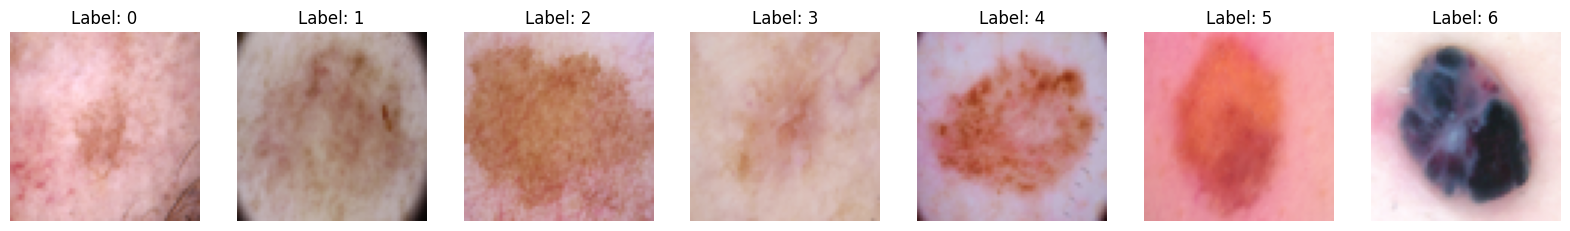

In [ ]:
import os
from glob import glob
from PIL import Image, ImageEnhance, ImageOps
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
from scipy import stats
import warnings
import seaborn as sns

# Suppress warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Resize parameter
SIZE = 32

# Function to balance the dataset using augmentation
def balance_data_with_augmentation(df, label_col, n_samples):
    def augment_image(image):
        # Apply random transformations for augmentation
        if np.random.rand() > 0.5:
            image = ImageOps.flip(image)
        if np.random.rand() > 0.5:
            image = ImageOps.mirror(image)
        if np.random.rand() > 0.5:
            enhancer = ImageEnhance.Contrast(image)
            image = enhancer.enhance(1 + (np.random.rand() - 0.5))
        return image

    dfs = []
    for label in df[label_col].unique():
        df_label = df[df[label_col] == label]
        while len(df_label) < n_samples:
            df_label = pd.concat([df_label, resample(df_label, replace=True, n_samples=n_samples - len(df_label), random_state=42)])
        df_label = df_label.sample(n_samples, random_state=42)
        dfs.append(df_label)
    balanced_df = pd.concat(dfs)
    return balanced_df

# Define image directory paths
image_dir_part_1 = '/content/drive/My Drive/Research/HAM10000_images_part_1'
image_dir_part_2 = '/content/drive/My Drive/Research/HAM10000_images_part_2'

# Check if the directories exist
for image_dir in [image_dir_part_1, image_dir_part_2]:
    if not os.path.exists(image_dir):
        raise FileNotFoundError(f"Directory does not exist: {image_dir}")

# Create a dictionary mapping image IDs to their paths
image_paths_part_1 = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join(image_dir_part_1, '*.jpg'))}
image_paths_part_2 = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join(image_dir_part_2, '*.jpg'))}

# Combine dictionaries
image_path = {**image_paths_part_1, **image_paths_part_2}


# Label encoding to numeric values from text
le = LabelEncoder()
le.fit(df['Diagnosis'])
df['label'] = le.transform(df["Diagnosis"])
print("Classes:", list(le.classes_))

# Initialize figure for plotting
fig = plt.figure(figsize=(10, 8))

# Plotting
# ax1 = fig.add_subplot(221)
# df['Diagnosis'].value_counts().plot(kind='bar', ax=ax1)
# ax1.set_ylabel('Count')
# ax1.set_title('Cell Type')

# ax2 = fig.add_subplot(222)
# df['Sex'].value_counts().plot(kind='bar', ax=ax2)
# ax2.set_ylabel('Count', size=15)
# ax2.set_title('Sex')

# ax3 = fig.add_subplot(223)
# df['Region_Of_Disease'].value_counts().plot(kind='bar', ax=ax3)
# ax3.set_ylabel('Count', size=12)
# ax3.set_title('Localization')

# ax4 = fig.add_subplot(224)
# sample_age = df[pd.notnull(df['Age'])]
# sns.histplot(sample_age['Age'], kde=True, color='red', ax=ax4)
# ax4.set_title('Age')

# plt.tight_layout()
# plt.show()

# Distribution of data into various classes before balancing
print("Before balancing:\n", df['label'].value_counts())

# Map image paths to the DataFrame
df['Path'] = df['Image_Id'].map(image_path)

# Check if any paths are missing
missing_paths = df['Path'].isnull().sum()
if missing_paths > 0:
    print(f"Warning: {missing_paths} image paths are missing!")

# Remove rows with missing image paths
df = df.dropna(subset=['Path'])

# Balance the data with augmentation
df_balanced = balance_data_with_augmentation(df, 'label', 150)

# Distribution of data into various classes after balancing
print("After balancing:\n", df_balanced['label'].value_counts())

# Function to load and resize images
def load_and_resize_image(image_path, size=(64, 64)):
    try:
        img = Image.open(image_path)
        img = img.resize(size)
        img = np.asarray(img).astype('float32') / 255.0  # Normalize pixel values to [0, 1]
        return img
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None

# Load and resize images
df_balanced['Image'] = df_balanced['Path'].apply(load_and_resize_image)

# Remove rows where images failed to load
df_balanced = df_balanced.dropna(subset=['Image'])

# Define the missing function plot_samples
def plot_samples(df, label_col, image_col):
    num_labels = df[label_col].nunique()
    fig, axes = plt.subplots(1, num_labels, figsize=(20, 5))
    for i, (label, group) in enumerate(df.groupby(label_col)):
        ax = axes[i]
        img = group.iloc[0][image_col]
        ax.imshow(img)
        ax.set_title(f'Label: {label}')
        ax.axis('off')
    plt.show()

# Plotting samples
plot_samples(df_balanced, 'label', 'Image')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Lesion_Id            10015 non-null  object
 1   Image_Id             10015 non-null  object
 2   Diagnosis            10015 non-null  object
 3   Confirmation_Method  10015 non-null  object
 4   Age                  10015 non-null  int64 
 5   Sex                  10015 non-null  object
 6   Region_Of_Disease    10015 non-null  object
 7   Dataset              10015 non-null  object
dtypes: int64(1), object(7)
memory usage: 626.1+ KB


### Using SMOTE

Classes: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
Original dataset shape: Counter({5: 6705, 4: 1113, 2: 1099, 1: 514, 0: 327, 6: 142, 3: 115})
Resampled dataset shape: Counter({2: 6705, 5: 6705, 3: 6705, 4: 6705, 6: 6705, 1: 6705, 0: 6705})


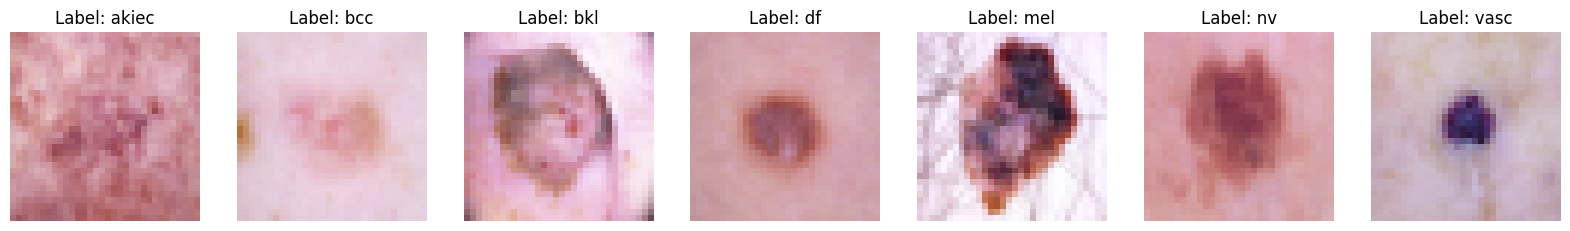

In [ ]:
import os
from glob import glob
from PIL import Image, ImageEnhance, ImageOps
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Resize parameter
SIZE = 32

# Define image directory paths
image_dir_part_1 = '/content/drive/My Drive/Research/HAM10000_images_part_1'
image_dir_part_2 = '/content/drive/My Drive/Research/HAM10000_images_part_2'

# Check if the directories exist
for image_dir in [image_dir_part_1, image_dir_part_2]:
    if not os.path.exists(image_dir):
        raise FileNotFoundError(f"Directory does not exist: {image_dir}")

# Create a dictionary mapping image IDs to their paths
image_paths_part_1 = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join(image_dir_part_1, '*.jpg'))}
image_paths_part_2 = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join(image_dir_part_2, '*.jpg'))}

# Combine dictionaries
image_path = {**image_paths_part_1, **image_paths_part_2}



# Label encoding to numeric values from text
le = LabelEncoder()
le.fit(df['Diagnosis'])
df['label'] = le.transform(df["Diagnosis"])
print("Classes:", list(le.classes_))

# Map image paths to the DataFrame
df['Path'] = df['Image_Id'].map(image_path)

# Check if any paths are missing
missing_paths = df['Path'].isnull().sum()
if (missing_paths > 0):
    print(f"Warning: {missing_paths} image paths are missing!")

# Remove rows with missing image paths
df = df.dropna(subset=['Path'])

# Function to load and resize images
def load_and_resize_image(image_path, size=(SIZE, SIZE)):
    try:
        img = Image.open(image_path)
        img = img.resize(size)
        img = np.asarray(img).astype('float32') / 255.0  # Normalize pixel values to [0, 1]
        return img
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None

# Load and resize images
df['Image'] = df['Path'].apply(load_and_resize_image)

# Remove rows where images failed to load
df = df.dropna(subset=['Image'])

# Reshape the images to flatten them for SMOTE
X = np.array(df['Image'].tolist()).reshape(len(df), -1)
y = df['label']

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

print(f"Original dataset shape: {Counter(y)}")
print(f"Resampled dataset shape: {Counter(y_res)}")

# Function to plot samples
def plot_samples(X, y, label_encoder, num_samples=5):
    unique_labels = np.unique(y)
    fig, axes = plt.subplots(1, len(unique_labels), figsize=(20, 5))
    for i, label in enumerate(unique_labels):
        ax = axes[i]
        sample_indices = np.where(y == label)[0][:num_samples]
        for j, idx in enumerate(sample_indices):
            img = X[idx].reshape(SIZE, SIZE, 3)
            ax.imshow(img)
            ax.set_title(f'Label: {label_encoder.inverse_transform([label])[0]}')
            ax.axis('off')
    plt.show()

# Plotting samples
plot_samples(X_res, y_res, le)


In [ ]:
# Convert the resampled arrays back to a DataFrame
df_balanced = pd.DataFrame(X_res)
df_balanced['label'] = y_res

# Decode the labels to their original class names
df_balanced['Diagnosis'] = le.inverse_transform(df_balanced['label'])

# Optionally, if you want to keep the original image format for visualization
def reshape_and_convert_image(row, size=(SIZE, SIZE, 3)):
    return row.values.reshape(size)

df_balanced['Image'] = df_balanced.drop(columns=['label', 'Diagnosis']).apply(reshape_and_convert_image, axis=1)

# Display the new balanced dataset
print("New balanced dataset shape:", df_balanced.shape)
print("New balanced dataset head:\n", df_balanced.head())


New balanced dataset shape: (46935, 3075)
New balanced dataset head:
           0         1         2         3         4         5         6  \
0  0.749020  0.596078  0.752941  0.760784  0.603922  0.756863  0.768627   
1  0.094118  0.054902  0.113725  0.219608  0.152941  0.250980  0.415686   
2  0.745098  0.533333  0.588235  0.780392  0.568627  0.631373  0.784314   
3  0.137255  0.070588  0.109804  0.325490  0.200000  0.250980  0.501961   
4  0.607843  0.431373  0.529412  0.737255  0.545098  0.658824  0.823529   

          7         8         9  ...      3065      3066      3067      3068  \
0  0.596078  0.721569  0.780392  ...  0.572549  0.721569  0.584314  0.662745   
1  0.313726  0.439216  0.560784  ...  0.168627  0.098039  0.054902  0.109804   
2  0.552941  0.627451  0.803922  ...  0.564706  0.607843  0.474510  0.541176   
3  0.345098  0.403922  0.631373  ...  0.101961  0.098039  0.047059  0.062745   
4  0.615686  0.721569  0.862745  ...  0.686275  0.627451  0.486275  0.537255   

In [ ]:
import os
from glob import glob
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from collections import Counter
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Resize parameter
SIZE = 32

# Define image directory paths
image_dir_part_1 = '/content/drive/My Drive/Research/HAM10000_images_part_1'
image_dir_part_2 = '/content/drive/My Drive/Research/HAM10000_images_part_2'

# Check if the directories exist
for image_dir in [image_dir_part_1, image_dir_part_2]:
    if not os.path.exists(image_dir):
        raise FileNotFoundError(f"Directory does not exist: {image_dir}")

# Create a dictionary mapping image IDs to their paths
image_paths_part_1 = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join(image_dir_part_1, '*.jpg'))}
image_paths_part_2 = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join(image_dir_part_2, '*.jpg'))}

# Combine dictionaries
image_path = {**image_paths_part_1, **image_paths_part_2}


# Label encoding to numeric values from text
le = LabelEncoder()
le.fit(df['Diagnosis'])
df['label'] = le.transform(df["Diagnosis"])
print("Classes:", list(le.classes_))

# Map image paths to the DataFrame
df['Path'] = df['Image_Id'].map(image_path)

# Check if any paths are missing
missing_paths = df['Path'].isnull().sum()
if missing_paths > 0:
    print(f"Warning: {missing_paths} image paths are missing!")

# Remove rows with missing image paths
df = df.dropna(subset=['Path'])

# Function to load and resize images
def load_and_resize_image(image_path, size=(SIZE, SIZE)):
    try:
        img = Image.open(image_path)
        img = img.resize(size)
        img = np.asarray(img).astype('float32') / 255.0  # Normalize pixel values to [0, 1]
        return img
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None

# Load and resize images
df['Image'] = df['Path'].apply(load_and_resize_image)

# Remove rows where images failed to load
df = df.dropna(subset=['Image'])

# Ensure images are loaded
if df['Image'].isnull().sum() > 0:
    raise ValueError("Some images failed to load. Please check the image paths and formats.")

# Reshape the images to flatten them for SMOTE
X = np.array(df['Image'].tolist()).reshape(len(df), -1)
y = df['label']

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# Create a DataFrame with resampled images
df_resampled = pd.DataFrame(X_res)
df_resampled['label'] = y_res

# Decode the labels to their original class names
df_resampled['Diagnosis'] = le.inverse_transform(df_resampled['label'])

# Reshape and convert images back to their original format for visualization
def reshape_and_convert_image(row, size=(SIZE, SIZE, 3)):
    return row.values[:size[0]*size[1]*size[2]].reshape(size)

df_resampled['Image'] = df_resampled.apply(reshape_and_convert_image, axis=1)

# Extract the indices of the resampled data
resampled_indices = smote.fit_resample(df.index.to_frame(), y)[0].index

# Merge original columns from the resampled indices with the resampled images and labels
original_columns = df.drop(columns=['Image', 'Diagnosis', 'label'])
df_balanced = df_resampled.reset_index(drop=True).join(original_columns.iloc[resampled_indices].reset_index(drop=True))

# Display the new balanced dataset
print("New balanced dataset shape:", df_balanced.shape)
print("New balanced dataset head:\n", df_balanced.head())

# Function to plot samples
def plot_samples(X, y, label_encoder, num_samples=5):
    unique_labels = np.unique(y)
    fig, axes = plt.subplots(1, len(unique_labels), figsize=(20, 5))
    for i, label in enumerate(unique_labels):
        ax = axes[i]
        sample_indices = np.where(y == label)[0][:num_samples]
        for j, idx in enumerate(sample_indices):
            img = X[idx].reshape(SIZE, SIZE, 3)
            ax.imshow(img)
            ax.set_title(f'Label: {label_encoder.inverse_transform([label])[0]}')
            ax.axis('off')
    plt.show()

# Plotting samples
plot_samples(X_res, y_res, le)


Classes: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


IndexError: positional indexers are out-of-bounds

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Assume y_res contains the resampled labels
# If you have the original labels, fit the LabelEncoder on them
original_labels = y_res.unique()

# Create and fit the LabelEncoder
le = LabelEncoder()
le.fit(original_labels)

# Convert the resampled arrays back to a DataFrame
df_balanced = pd.DataFrame(X_res)
df_balanced['label'] = y_res

# Decode the labels to their original class names
df_balanced['Diagnosis'] = le.inverse_transform(df_balanced['label'].values)

# Optionally, if you want to keep the original image format for visualization
def reshape_and_convert_image(row, size=(SIZE, SIZE, 3)):
    return row.values.reshape(size)

df_balanced['Image'] = df_balanced.drop(columns=['label', 'Diagnosis']).apply(reshape_and_convert_image, axis=1)

# Display the new balanced dataset
print("New balanced dataset shape:", df_balanced.shape)
print("New balanced dataset head:\n", df_balanced.head())


New balanced dataset shape: (46935, 3075)
New balanced dataset head:
           0         1         2         3         4         5         6  \
0  0.749020  0.596078  0.752941  0.760784  0.603922  0.756863  0.768627   
1  0.094118  0.054902  0.113725  0.219608  0.152941  0.250980  0.415686   
2  0.745098  0.533333  0.588235  0.780392  0.568627  0.631373  0.784314   
3  0.137255  0.070588  0.109804  0.325490  0.200000  0.250980  0.501961   
4  0.607843  0.431373  0.529412  0.737255  0.545098  0.658824  0.823529   

          7         8         9  ...      3065      3066      3067      3068  \
0  0.596078  0.721569  0.780392  ...  0.572549  0.721569  0.584314  0.662745   
1  0.313726  0.439216  0.560784  ...  0.168627  0.098039  0.054902  0.109804   
2  0.552941  0.627451  0.803922  ...  0.564706  0.607843  0.474510  0.541176   
3  0.345098  0.403922  0.631373  ...  0.101961  0.098039  0.047059  0.062745   
4  0.615686  0.721569  0.862745  ...  0.686275  0.627451  0.486275  0.537255   

In [ ]:
df_balanced.columns

Index([          0,           1,           2,           3,           4,
                 5,           6,           7,           8,           9,
       ...
              3065,        3066,        3067,        3068,        3069,
              3070,        3071,     'label', 'Diagnosis',     'Image'],
      dtype='object', length=3075)

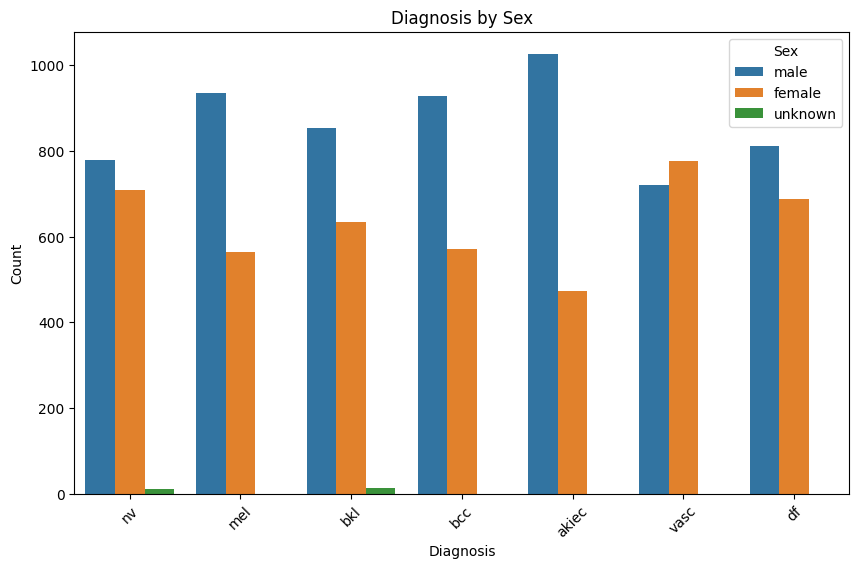

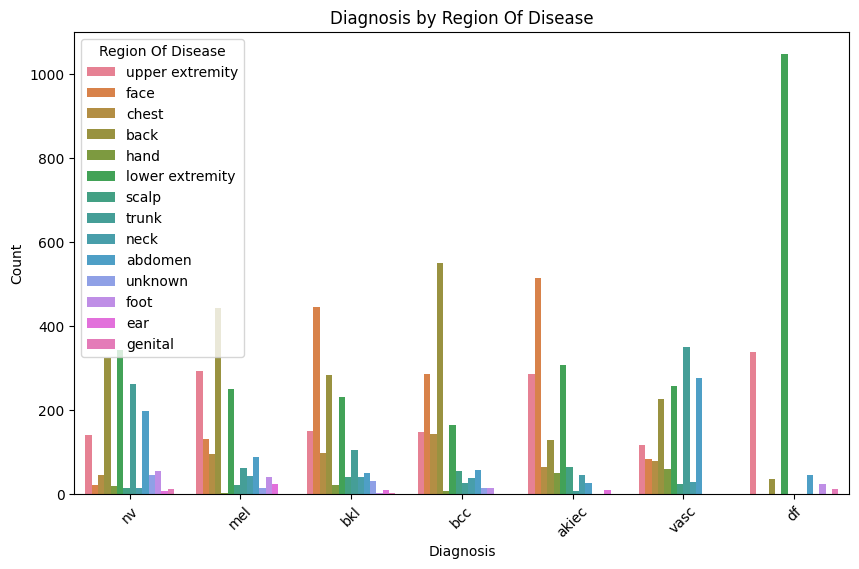

In [ ]:
# Relationship between Diagnosis and Sex
plt.figure(figsize=(10, 6))
sns.countplot(data=df_balanced, x='Diagnosis', hue='Sex', order=diagnosis_counts.index)
plt.title('Diagnosis by Sex')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Sex')
plt.show()

# Relationship between Diagnosis and Region_Of_Disease
plt.figure(figsize=(10, 6))
sns.countplot(data=df_balanced, x='Diagnosis', hue='Region_Of_Disease', order=diagnosis_counts.index)
plt.title('Diagnosis by Region Of Disease')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Region Of Disease')
plt.show()


                                                      Age         label  \
Age                                              1.000000 -3.862346e-01   
label                                           -0.386235  1.000000e+00   
Diagnosis_bcc                                    0.200522 -4.082483e-01   
Diagnosis_bkl                                    0.146025 -2.041241e-01   
Diagnosis_df                                    -0.117367 -1.012326e-15   
Diagnosis_mel                                    0.050231  2.041241e-01   
Diagnosis_nv                                    -0.287219  4.082483e-01   
Diagnosis_vasc                                  -0.185469  6.123724e-01   
Confirmation_Method_consensus                   -0.166480  2.584087e-01   
Confirmation_Method_follow_up                   -0.169824  2.954559e-01   
Confirmation_Method_histo                        0.241597 -3.939763e-01   
Sex_male                                         0.154148 -1.091095e-01   
Sex_unknown              

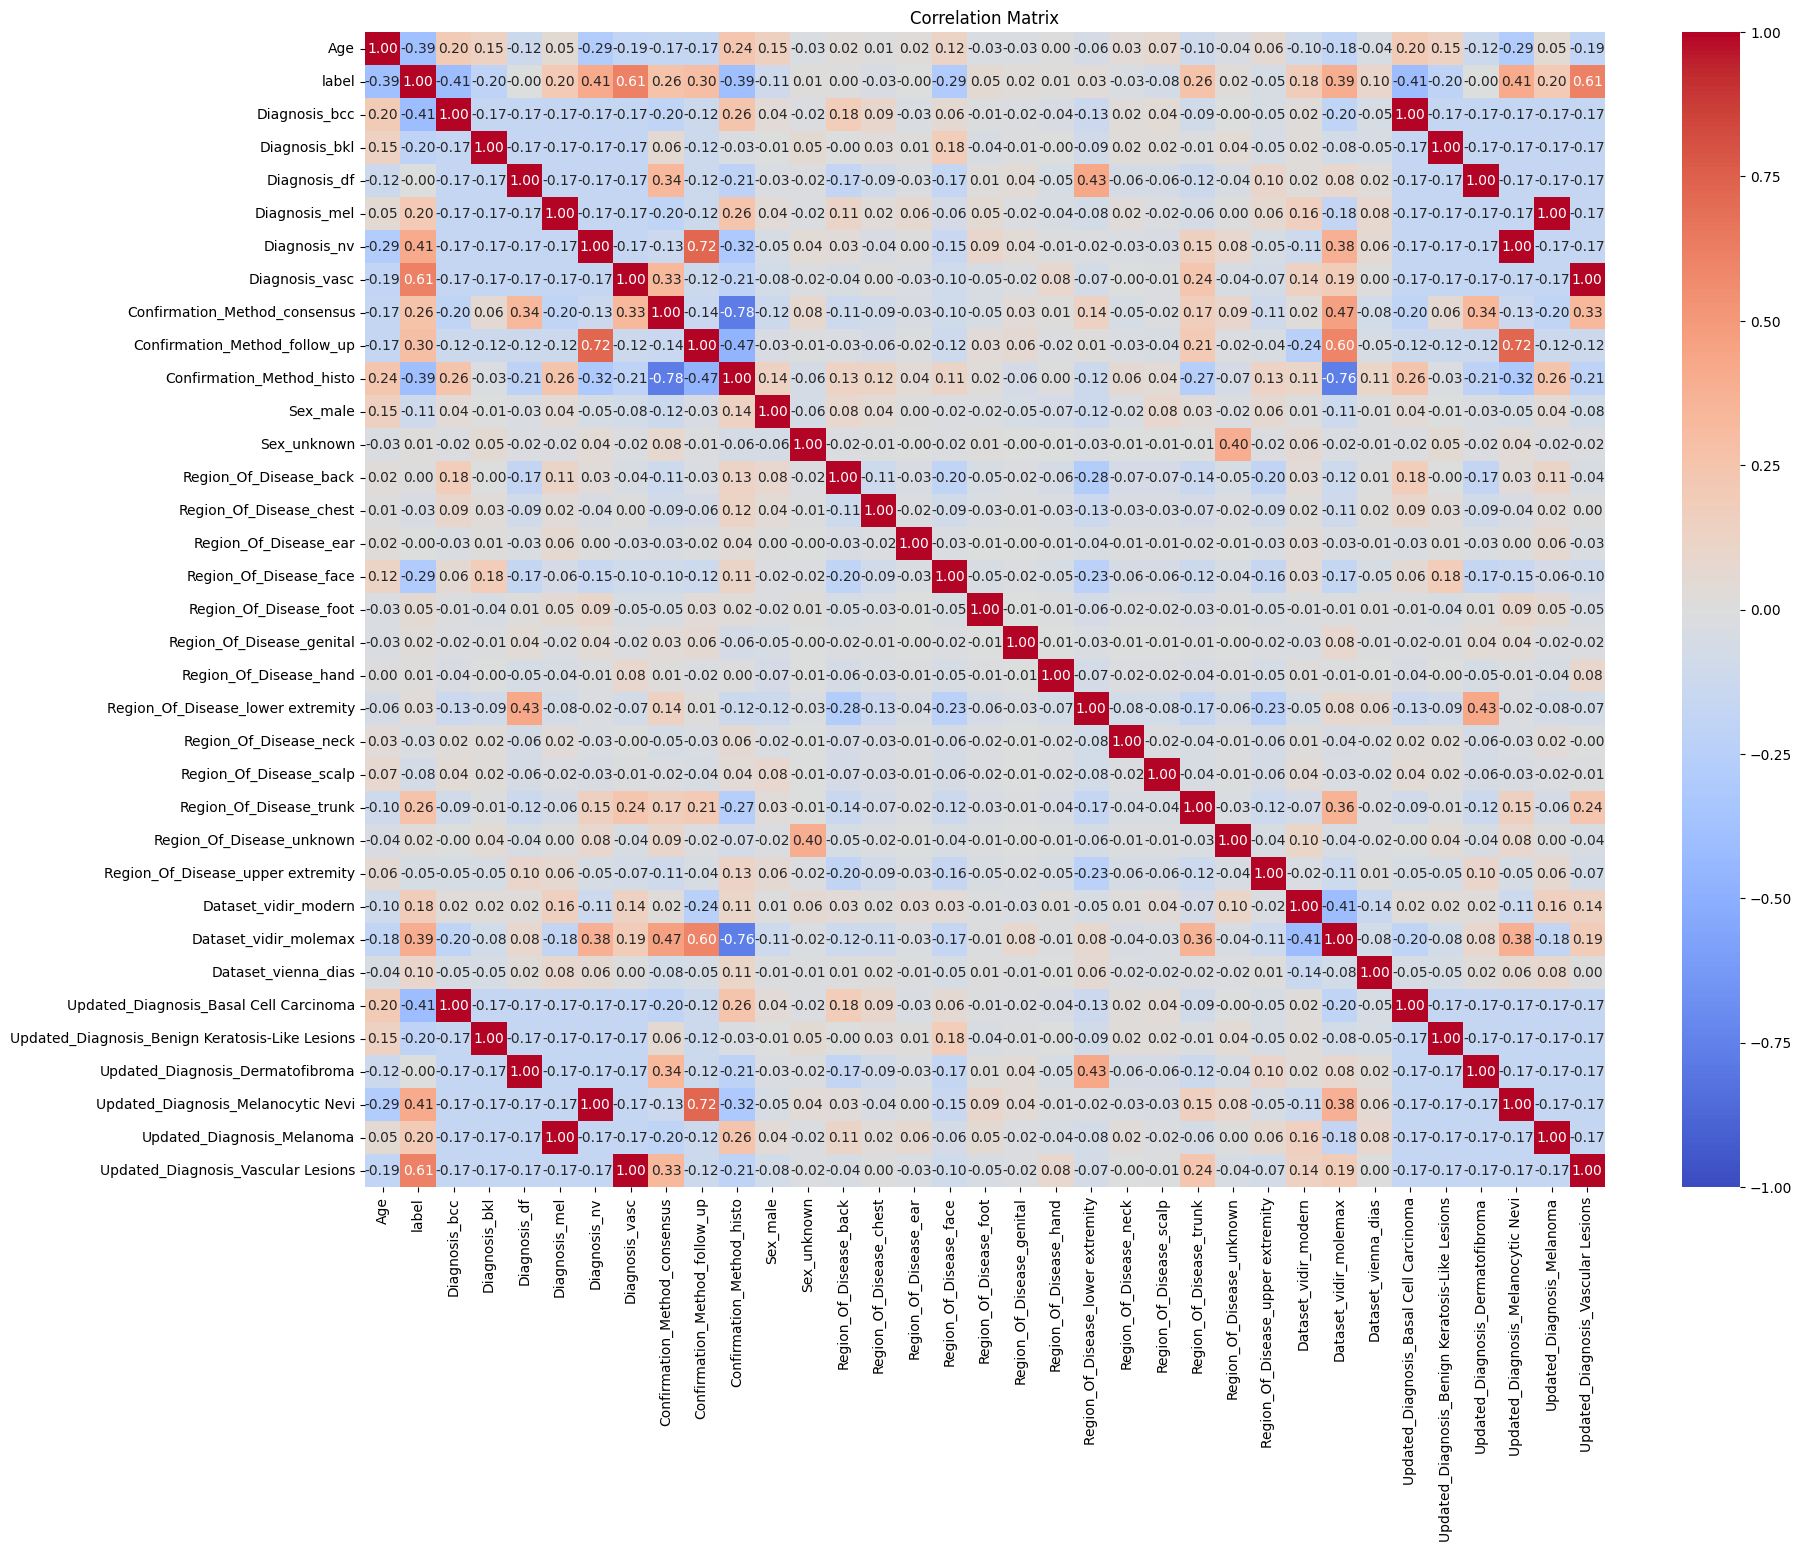

In [ ]:

# List of categorical features to encode
categorical_features = ['Diagnosis', 'Confirmation_Method', 'Sex', 'Region_Of_Disease', 'Dataset', 'Updated_Diagnosis']

# Perform one-hot encoding
df_encoded = pd.get_dummies(df_balanced, columns=categorical_features, drop_first=True)

# Select only the numerical columns
df_numeric = df_encoded.select_dtypes(include=[float, int, bool])

# Calculate the correlation matrix
correlation_matrix = df_numeric.corr()

# Display the correlation matrix
print(correlation_matrix)

# Set up the matplotlib figure
plt.figure(figsize=(20, 15))

# Draw the heatmap with the correlation matrix
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)

# Add title and labels
plt.title('Correlation Matrix')
plt.show()


# 1. Implementation of GNNs Models:
* GCN: Implement a Graph Convolutional Network using a library like PyTorch Geometric.
* GAT: Implement a Graph Attention Network using the same library.
* GAN: Implement a Generative Adversarial Network using TensorFlow or PyTorch.
* Graph SAGE
* DGCNN


# a. GCN Model (Graph Convolution Network)

#### GCN with Plots

Epoch 10/500, Train Loss: 1.432450294494629, Val Loss: 1.4920169115066528, LR: 0.001
Epoch 20/500, Train Loss: 1.2045973539352417, Val Loss: 1.251168966293335, LR: 0.001
Epoch 30/500, Train Loss: 1.0276286602020264, Val Loss: 1.0490128993988037, LR: 0.001
Epoch 40/500, Train Loss: 0.8646602034568787, Val Loss: 0.9139448404312134, LR: 0.001
Epoch 50/500, Train Loss: 0.719121515750885, Val Loss: 0.7997019290924072, LR: 0.001
Epoch 60/500, Train Loss: 0.6086023449897766, Val Loss: 0.7094756960868835, LR: 0.001
Epoch 70/500, Train Loss: 0.5211511254310608, Val Loss: 0.6373663544654846, LR: 0.001
Epoch 80/500, Train Loss: 0.45881199836730957, Val Loss: 0.5918328166007996, LR: 0.001
Epoch 90/500, Train Loss: 0.40782225131988525, Val Loss: 0.5554044246673584, LR: 0.001
Epoch 100/500, Train Loss: 0.36944472789764404, Val Loss: 0.5232933759689331, LR: 0.001
Epoch 110/500, Train Loss: 0.3361560106277466, Val Loss: 0.5006645917892456, LR: 0.001
Epoch 120/500, Train Loss: 0.30815398693084717, Val 

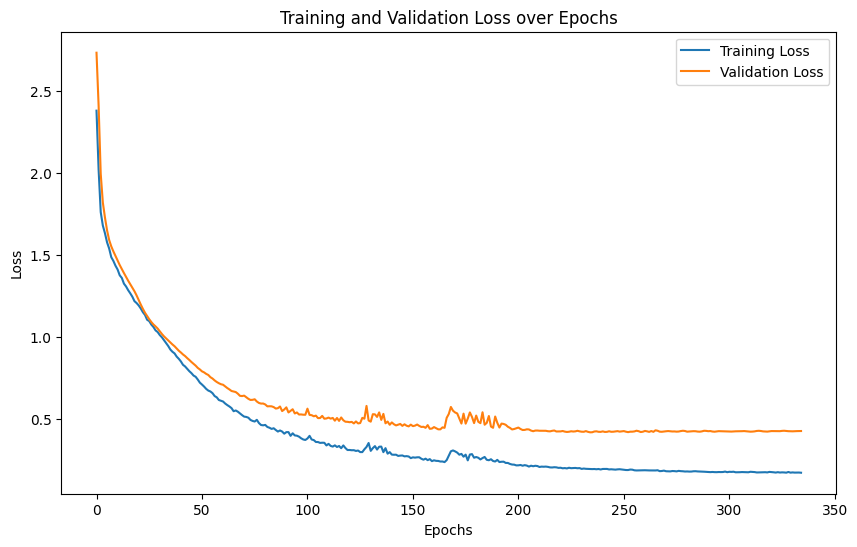

Accuracy: 0.8412, Precision: 0.8480, Recall: 0.8404, F1 Score: 0.8403


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, BatchNorm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import NearestNeighbors
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Encode labels
le = LabelEncoder()
le.fit(df_balanced['Diagnosis'])
df_balanced['label'] = le.transform(df_balanced["Diagnosis"])

# Prepare features and labels
X = np.array(df_balanced['Image'].tolist())
y = df_balanced['label'].values

# Ensure the number of samples in X and y are consistent
if X.shape[0] != len(y):
    min_samples = min(X.shape[0], len(y))
    X = X[:min_samples]
    y = y[:min_samples]

# Flatten the images
X_flat = X.reshape(X.shape[0], -1)

# Normalize the features
scaler = StandardScaler()
X_flat = scaler.fit_transform(X_flat)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=0.2, random_state=42)

# Create edge index using k-nearest neighbors
def create_edge_index(X, k=5):
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='auto').fit(X)
    distances, indices = nbrs.kneighbors(X)
    edge_index = []
    for i, neighbors in enumerate(indices):
        for neighbor in neighbors[1:]:
            edge_index.append([i, neighbor])
            edge_index.append([neighbor, i])
    edge_index = np.array(edge_index).T
    return torch.tensor(edge_index, dtype=torch.long)

edge_index = create_edge_index(X_train)

# Prepare PyTorch Geometric data
train_data = Data(x=torch.tensor(X_train, dtype=torch.float), edge_index=edge_index, y=torch.tensor(y_train, dtype=torch.long))
test_data = Data(x=torch.tensor(X_test, dtype=torch.float), edge_index=create_edge_index(X_test), y=torch.tensor(y_test, dtype=torch.long))

# Define improved GCN model with dropout and batch normalization
class ImprovedGCN(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, num_classes):
        super(ImprovedGCN, self).__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.bn1 = BatchNorm(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.bn2 = BatchNorm(hidden_channels)
        self.conv3 = GCNConv(hidden_channels, num_classes)
        self.dropout = torch.nn.Dropout(p=0.5)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)

# Train improved GCN model with early stopping and learning rate scheduler
def train_improved_gcn_model(train_data, test_data, hidden_channels, lr, weight_decay, epochs=500, patience=100, scheduler_patience=30, factor=0.5, min_lr=1e-5, batch_size=32, device='cpu'):
    model = ImprovedGCN(num_node_features=train_data.num_features, hidden_channels=hidden_channels, num_classes=train_data.y.max().item() + 1).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=factor, patience=scheduler_patience, min_lr=min_lr)

    best_loss = float('inf')
    best_model = None
    patience_counter = 0

    train_loader = DataLoader([train_data], batch_size=batch_size, shuffle=True)
    test_loader = DataLoader([test_data], batch_size=batch_size, shuffle=False)

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        for batch in train_loader:
            optimizer.zero_grad()
            batch = batch.to(device)
            out = model(batch)
            loss = F.nll_loss(out, batch.y)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

        train_loss = running_train_loss / len(train_loader)
        train_losses.append(train_loss)

        # Evaluate on validation set
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in test_loader:
                batch = batch.to(device)
                val_out = model(batch)
                val_loss += F.nll_loss(val_out, batch.y).item()
        val_loss /= len(test_loader)
        val_losses.append(val_loss)

        scheduler.step(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}, LR: {optimizer.param_groups[0]["lr"]}')

        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

    # Load the best model
    model.load_state_dict(best_model)
    return model, train_losses, val_losses

# Train the model and capture the loss values
model, train_losses, val_losses = train_improved_gcn_model(train_data, test_data, hidden_channels=128, lr=0.001, weight_decay=5e-4, epochs=500, patience=100, scheduler_patience=30, factor=0.5, min_lr=1e-5, batch_size=32, device=device)

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

# Evaluate the model
def evaluate_model(model, test_data, device='cpu'):
    model.eval()
    test_loader = DataLoader([test_data], batch_size=32, shuffle=False)
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            out = model(batch)
            pred = out.argmax(dim=1)
            all_preds.append(pred.cpu().numpy())
            all_labels.append(batch.y.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='macro')
    rec = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    print(f'Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1 Score: {f1:.4f}')

# Evaluate the trained model
evaluate_model(model, test_data, device=device)


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, BatchNorm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import NearestNeighbors
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Encode labels
le = LabelEncoder()
le.fit(df_balanced['Diagnosis'])
df_balanced['label'] = le.transform(df_balanced["Diagnosis"])

# Prepare features and labels
X = np.array(df_balanced['Image'].tolist())
y = df_balanced['label'].values

# Ensure the number of samples in X and y are consistent
if X.shape[0] != len(y):
    min_samples = min(X.shape[0], len(y))
    X = X[:min_samples]
    y = y[:min_samples]

# Flatten the images
X_flat = X.reshape(X.shape[0], -1)

# Normalize the features
scaler = StandardScaler()
X_flat = scaler.fit_transform(X_flat)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=0.2, random_state=42)

# Create edge index using k-nearest neighbors
def create_edge_index(X, k=5):
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='auto').fit(X)
    distances, indices = nbrs.kneighbors(X)
    edge_index = []
    for i, neighbors in enumerate(indices):
        for neighbor in neighbors[1:]:
            edge_index.append([i, neighbor])
            edge_index.append([neighbor, i])
    edge_index = np.array(edge_index).T
    return torch.tensor(edge_index, dtype=torch.long)

edge_index = create_edge_index(X_train)

# Prepare PyTorch Geometric data
train_data = Data(x=torch.tensor(X_train, dtype=torch.float), edge_index=edge_index, y=torch.tensor(y_train, dtype=torch.long))
test_data = Data(x=torch.tensor(X_test, dtype=torch.float), edge_index=create_edge_index(X_test), y=torch.tensor(y_test, dtype=torch.long))

# Define improved GCN model with dropout and batch normalization
class ImprovedGCN(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, num_classes):
        super(ImprovedGCN, self).__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.bn1 = BatchNorm(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.bn2 = BatchNorm(hidden_channels)
        self.conv3 = GCNConv(hidden_channels, num_classes)
        self.dropout = torch.nn.Dropout(p=0.5)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)

# Train improved GCN model with early stopping and learning rate scheduler
def train_improved_gcn_model(train_data, test_data, hidden_channels, lr, weight_decay, epochs=500, patience=100, scheduler_patience=30, factor=0.5, min_lr=1e-5, batch_size=32, device='cpu'):
    model = ImprovedGCN(num_node_features=train_data.num_features, hidden_channels=hidden_channels, num_classes=train_data.y.max().item() + 1).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=factor, patience=scheduler_patience, min_lr=min_lr)

    best_loss = float('inf')
    best_model = None
    patience_counter = 0

    train_loader = DataLoader([train_data], batch_size=batch_size, shuffle=True)
    test_loader = DataLoader([test_data], batch_size=batch_size, shuffle=False)

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        for batch in train_loader:
            optimizer.zero_grad()
            batch = batch.to(device)
            out = model(batch)
            loss = F.nll_loss(out, batch.y)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

        train_loss = running_train_loss / len(train_loader)
        train_losses.append(train_loss)

        # Evaluate on validation set
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in test_loader:
                batch = batch.to(device)
                val_out = model(batch)
                val_loss += F.nll_loss(val_out, batch.y).item()
        val_loss /= len(test_loader)
        val_losses.append(val_loss)

        scheduler.step(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, LR: {optimizer.param_groups[0]["lr"]:.6f}')

        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

    # Load the best model
    model.load_state_dict(best_model)
    return model, train_losses, val_losses

# Train the model and capture the loss values
model, train_losses, val_losses = train_improved_gcn_model(train_data, test_data, hidden_channels=128, lr=0.001, weight_decay=5e-4, epochs=500, patience=100, scheduler_patience=30, factor=0.5, min_lr=1e-5, batch_size=32, device=device)

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

# Evaluate the model
def evaluate_model(model, test_data, device='cpu'):
    model.eval()
    test_loader = DataLoader([test_data], batch_size=32, shuffle=False)
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            out = model(batch)
            pred = out.argmax(dim=1)
            all_preds.append(pred.cpu().numpy())
            all_labels.append(batch.y.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='macro')
    rec = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    print(f'Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1 Score: {f1:.4f}')

# Evaluate the trained model
evaluate_model(model, test_data, device=device)


In [ ]:
import os
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, BatchNorm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import NearestNeighbors
import numpy as np
import pandas as pd

# Encode labels
le = LabelEncoder()
le.fit(df_balanced['Diagnosis'])
df_balanced['label'] = le.transform(df_balanced["Diagnosis"])

# Check the consistency of the data
print(f"Number of samples in df_balanced: {len(df_balanced)}")
print(f"Number of unique images: {len(df_balanced['Image'])}")

# Prepare features and labels
X = np.array(df_balanced['Image'].tolist())
y = df_balanced['label'].values

# Ensure the number of samples in X and y are consistent
if X.shape[0] != len(y):
    print("Inconsistent number of samples between X and y.")
    min_samples = min(X.shape[0], len(y))
    X = X[:min_samples]
    y = y[:min_samples]
    print(f"Adjusted shape of X: {X.shape}")
    print(f"Adjusted length of y: {len(y)}")

# Flatten the images
X_flat = X.reshape(X.shape[0], -1)
print(f"Shape of X_flat: {X_flat.shape}")

# Normalize the features
scaler = StandardScaler()
X_flat = scaler.fit_transform(X_flat)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=0.2, random_state=42)

# Create edge index using k-nearest neighbors
def create_edge_index(X, k=5):
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='auto').fit(X)
    distances, indices = nbrs.kneighbors(X)
    edge_index = []
    for i, neighbors in enumerate(indices):
        for neighbor in neighbors[1:]:  # Skip the first neighbor (the node itself)
            edge_index.append([i, neighbor])
            edge_index.append([neighbor, i])  # Add both directions (i -> neighbor and neighbor -> i)
    edge_index = np.array(edge_index).T
    return torch.tensor(edge_index, dtype=torch.long)

edge_index = create_edge_index(X_train)

# Prepare PyTorch Geometric data
train_data = Data(x=torch.tensor(X_train, dtype=torch.float), edge_index=edge_index, y=torch.tensor(y_train, dtype=torch.long))
test_data = Data(x=torch.tensor(X_test, dtype=torch.float), edge_index=create_edge_index(X_test), y=torch.tensor(y_test, dtype=torch.long))

# Define improved GCN model with dropout and batch normalization
class ImprovedGCN(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, num_classes):
        super(ImprovedGCN, self).__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.bn1 = BatchNorm(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.bn2 = BatchNorm(hidden_channels)
        self.conv3 = GCNConv(hidden_channels, num_classes)
        self.dropout = torch.nn.Dropout(p=0.5)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)

# Train improved GCN model with early stopping and learning rate scheduler
def train_improved_gcn_model(train_data, test_data, hidden_channels, lr, weight_decay, epochs=500, patience=100, scheduler_patience=50, factor=0.5, min_lr=1e-5, batch_size=32, device='cpu'):
    model = ImprovedGCN(num_node_features=train_data.num_features, hidden_channels=hidden_channels, num_classes=train_data.y.max().item() + 1).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=factor, patience=scheduler_patience, min_lr=min_lr)

    best_loss = float('inf')
    best_model = None
    patience_counter = 0

    train_loader = DataLoader([train_data], batch_size=batch_size, shuffle=True)
    test_loader = DataLoader([test_data], batch_size=batch_size, shuffle=False)

    for epoch in range(epochs):
        model.train()
        for data in train_loader:
            optimizer.zero_grad()
            data = data.to(device)
            out = model(data)
            loss = F.nll_loss(out, data.y)
            loss.backward()
            optimizer.step()

        # Evaluate on validation set
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data in test_loader:
                data = data.to(device)
                val_out = model(data)
                val_loss += F.nll_loss(val_out, data.y).item()
        val_loss /= len(test_loader)

        scheduler.step(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}, Val Loss: {val_loss}, LR: {optimizer.param_groups[0]["lr"]}')

        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

    # Load the best model
    model.load_state_dict(best_model)
    return model

# Train the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = train_improved_gcn_model(train_data, test_data, hidden_channels=128, lr=0.001, weight_decay=5e-4, epochs=500, patience=100, scheduler_patience=50, factor=0.5, min_lr=1e-5, batch_size=32, device=device)

# Evaluate the model
def evaluate_model(model, test_data, device='cpu'):
    model.eval()
    test_loader = DataLoader([test_data], batch_size=32, shuffle=False)
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            out = model(data)
            pred = out.argmax(dim=1)
            all_preds.append(pred.cpu().numpy())
            all_labels.append(data.y.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='macro')
    rec = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    print(f'Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1 Score: {f1:.4f}')

# Evaluate the trained model
evaluate_model(model, test_data, device=device)


Number of samples in df_balanced: 46935
Number of unique images: 46935
Shape of X_flat: (46935, 3072)
Epoch 10/500, Loss: 1.3272615671157837, Val Loss: 1.3659217357635498, LR: 0.001
Epoch 20/500, Loss: 1.0849173069000244, Val Loss: 1.1127593517303467, LR: 0.001
Epoch 30/500, Loss: 0.8793647289276123, Val Loss: 0.9231787323951721, LR: 0.001
Epoch 40/500, Loss: 0.7176221609115601, Val Loss: 0.8031072020530701, LR: 0.001
Epoch 50/500, Loss: 0.5989181995391846, Val Loss: 0.7043959498405457, LR: 0.001
Epoch 60/500, Loss: 0.5182373523712158, Val Loss: 0.645610511302948, LR: 0.001
Epoch 70/500, Loss: 0.447510689496994, Val Loss: 0.5898515582084656, LR: 0.001
Epoch 80/500, Loss: 0.4074134826660156, Val Loss: 0.5476062297821045, LR: 0.001
Epoch 90/500, Loss: 0.3726412057876587, Val Loss: 0.5479625463485718, LR: 0.001
Epoch 100/500, Loss: 0.3248162865638733, Val Loss: 0.5124763250350952, LR: 0.001
Epoch 110/500, Loss: 0.2993139922618866, Val Loss: 0.48085394501686096, LR: 0.001
Epoch 120/500, Lo

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, BatchNorm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import NearestNeighbors
import numpy as np
import pandas as pd

# Encode labels
le = LabelEncoder()
le.fit(df_balanced['Diagnosis'])
df_balanced['label'] = le.transform(df_balanced["Diagnosis"])

# Check the consistency of the data
print(f"Number of samples in df_balanced: {len(df_balanced)}")
print(f"Number of unique images: {len(df_balanced['Image'])}")

# Prepare features and labels
X = np.array(df_balanced['Image'].tolist())
y = df_balanced['label'].values

# Ensure the number of samples in X and y are consistent
if X.shape[0] != len(y):
    print("Inconsistent number of samples between X and y.")
    min_samples = min(X.shape[0], len(y))
    X = X[:min_samples]
    y = y[:min_samples]
    print(f"Adjusted shape of X: {X.shape}")
    print(f"Adjusted length of y: {len(y)}")

# Flatten the images
X_flat = X.reshape(X.shape[0], -1)
print(f"Shape of X_flat: {X_flat.shape}")

# Normalize the features
scaler = StandardScaler()
X_flat = scaler.fit_transform(X_flat)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=0.2, random_state=42)

# Create edge index using k-nearest neighbors
def create_edge_index(X, k=5):
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='auto').fit(X)
    distances, indices = nbrs.kneighbors(X)
    edge_index = []
    for i, neighbors in enumerate(indices):
        for neighbor in neighbors[1:]:  # Skip the first neighbor (the node itself)
            edge_index.append([i, neighbor])
            edge_index.append([neighbor, i])  # Add both directions (i -> neighbor and neighbor -> i)
    edge_index = np.array(edge_index).T
    return torch.tensor(edge_index, dtype=torch.long)

edge_index = create_edge_index(X_train)

# Prepare PyTorch Geometric data
train_data = Data(x=torch.tensor(X_train, dtype=torch.float), edge_index=edge_index, y=torch.tensor(y_train, dtype=torch.long))
test_data = Data(x=torch.tensor(X_test, dtype=torch.float), edge_index=create_edge_index(X_test), y=torch.tensor(y_test, dtype=torch.long))

# Define improved GCN model with dropout and batch normalization
class ImprovedGCN(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, num_classes):
        super(ImprovedGCN, self).__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.bn1 = BatchNorm(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.bn2 = BatchNorm(hidden_channels)
        self.conv3 = GCNConv(hidden_channels, num_classes)
        self.dropout = torch.nn.Dropout(p=0.5)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)

# Train improved GCN model with early stopping and learning rate scheduler
def train_improved_gcn_model(train_data, test_data, hidden_channels, lr, weight_decay, epochs=500, patience=100, scheduler_patience=30, factor=0.5, min_lr=1e-5, batch_size=32, device='cpu'):
    model = ImprovedGCN(num_node_features=train_data.num_features, hidden_channels=hidden_channels, num_classes=train_data.y.max().item() + 1).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=factor, patience=scheduler_patience, min_lr=min_lr)

    best_loss = float('inf')
    best_model = None
    patience_counter = 0

    train_loader = DataLoader([train_data], batch_size=batch_size, shuffle=True)
    test_loader = DataLoader([test_data], batch_size=batch_size, shuffle=False)

    for epoch in range(epochs):
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            batch = batch.to(device)
            out = model(batch)
            loss = F.nll_loss(out, batch.y)
            loss.backward()
            optimizer.step()

        # Evaluate on validation set
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in test_loader:
                batch = batch.to(device)
                val_out = model(batch)
                val_loss += F.nll_loss(val_out, batch.y).item()
        val_loss /= len(test_loader)

        scheduler.step(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}, Val Loss: {val_loss}, LR: {optimizer.param_groups[0]["lr"]}')

        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

    # Load the best model
    model.load_state_dict(best_model)
    return model

# Train the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = train_improved_gcn_model(train_data, test_data, hidden_channels=128, lr=0.001, weight_decay=5e-4, epochs=500, patience=100, scheduler_patience=30, factor=0.5, min_lr=1e-5, batch_size=32, device=device)

# Evaluate the model
def evaluate_model(model, test_data, device='cpu'):
    model.eval()
    test_loader = DataLoader([test_data], batch_size=32, shuffle=False)
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            out = model(batch)
            pred = out.argmax(dim=1)
            all_preds.append(pred.cpu().numpy())
            all_labels.append(batch.y.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='macro')
    rec = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    print(f'Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1 Score: {f1:.4f}')

# Evaluate the trained model
evaluate_model(model, test_data, device=device)


Number of samples in df_balanced: 46935
Number of unique images: 46935
Shape of X_flat: (46935, 3072)
Epoch 10/500, Loss: 1.3527096509933472, Val Loss: 1.4129070043563843, LR: 0.001
Epoch 20/500, Loss: 1.092759609222412, Val Loss: 1.1268682479858398, LR: 0.001
Epoch 30/500, Loss: 0.9059354066848755, Val Loss: 0.94720059633255, LR: 0.001
Epoch 40/500, Loss: 0.7439728379249573, Val Loss: 0.8208938837051392, LR: 0.001
Epoch 50/500, Loss: 0.6227302551269531, Val Loss: 0.7303935885429382, LR: 0.001
Epoch 60/500, Loss: 0.5284343361854553, Val Loss: 0.6557272672653198, LR: 0.001
Epoch 70/500, Loss: 0.45963233709335327, Val Loss: 0.5964698195457458, LR: 0.001
Epoch 80/500, Loss: 0.40642625093460083, Val Loss: 0.5501211881637573, LR: 0.001
Epoch 90/500, Loss: 0.3629303574562073, Val Loss: 0.5456690192222595, LR: 0.001
Epoch 100/500, Loss: 0.34311699867248535, Val Loss: 0.5083155632019043, LR: 0.001
Epoch 110/500, Loss: 0.30537649989128113, Val Loss: 0.4898757338523865, LR: 0.001
Epoch 120/500, 

In [ ]:
import os
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, BatchNorm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import NearestNeighbors
import numpy as np
import pandas as pd

# Encode labels
le = LabelEncoder()
le.fit(df_balanced['Diagnosis'])
df_balanced['label'] = le.transform(df_balanced["Diagnosis"])

# Check the consistency of the data
print(f"Number of samples in df_balanced: {len(df_balanced)}")
print(f"Number of unique images: {len(df_balanced['Image'])}")

# Prepare features and labels
X = np.array(df_balanced['Image'].tolist())
y = df_balanced['label'].values

# Ensure the number of samples in X and y are consistent
if X.shape[0] != len(y):
    print("Inconsistent number of samples between X and y.")
    min_samples = min(X.shape[0], len(y))
    X = X[:min_samples]
    y = y[:min_samples]
    print(f"Adjusted shape of X: {X.shape}")
    print(f"Adjusted length of y: {len(y)}")

# Flatten the images
X_flat = X.reshape(X.shape[0], -1)
print(f"Shape of X_flat: {X_flat.shape}")

# Normalize the features
scaler = StandardScaler()
X_flat = scaler.fit_transform(X_flat)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=0.2, random_state=42)

# Create edge index using k-nearest neighbors
def create_edge_index(X, k=5):
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='auto').fit(X)
    distances, indices = nbrs.kneighbors(X)
    edge_index = []
    for i, neighbors in enumerate(indices):
        for neighbor in neighbors[1:]:  # Skip the first neighbor (the node itself)
            edge_index.append([i, neighbor])
            edge_index.append([neighbor, i])  # Add both directions (i -> neighbor and neighbor -> i)
    edge_index = np.array(edge_index).T
    return torch.tensor(edge_index, dtype=torch.long)

edge_index = create_edge_index(X_train)

# Prepare PyTorch Geometric data
train_data = Data(x=torch.tensor(X_train, dtype=torch.float), edge_index=edge_index, y=torch.tensor(y_train, dtype=torch.long))
test_data = Data(x=torch.tensor(X_test, dtype=torch.float), edge_index=create_edge_index(X_test), y=torch.tensor(y_test, dtype=torch.long))

# Define improved GCN model with dropout and batch normalization
class ImprovedGCN(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, num_classes):
        super(ImprovedGCN, self).__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.bn1 = BatchNorm(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.bn2 = BatchNorm(hidden_channels)
        self.conv3 = GCNConv(hidden_channels, num_classes)
        self.dropout = torch.nn.Dropout(p=0.5)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)

# Train improved GCN model with early stopping and learning rate scheduler
def train_improved_gcn_model(train_data, test_data, hidden_channels, lr, weight_decay, epochs=500, patience=100, scheduler_patience=20, factor=0.5, min_lr=1e-5, batch_size=32, device='cpu'):
    model = ImprovedGCN(num_node_features=train_data.num_features, hidden_channels=hidden_channels, num_classes=train_data.y.max().item() + 1).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=factor, patience=scheduler_patience, min_lr=min_lr)

    best_loss = float('inf')
    best_model = None
    patience_counter = 0

    train_loader = DataLoader([train_data], batch_size=batch_size, shuffle=True)
    test_loader = DataLoader([test_data], batch_size=batch_size, shuffle=False)

    for epoch in range(epochs):
        model.train()
        for data in train_loader:
            optimizer.zero_grad()
            data = data.to(device)
            out = model(data)
            loss = F.nll_loss(out, data.y)
            loss.backward()
            optimizer.step()

        # Evaluate on validation set
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data in test_loader:
                data = data.to(device)
                val_out = model(data)
                val_loss += F.nll_loss(val_out, data.y).item()
        val_loss /= len(test_loader)

        scheduler.step(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}, Val Loss: {val_loss}, LR: {optimizer.param_groups[0]["lr"]}')

        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

    # Load the best model
    model.load_state_dict(best_model)
    return model

# Train the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = train_improved_gcn_model(train_data, test_data, hidden_channels=128, lr=0.001, weight_decay=5e-4, epochs=500, patience=100, scheduler_patience=20, factor=0.5, min_lr=1e-5, batch_size=32, device=device)

# Evaluate the model
def evaluate_model(model, test_data, device='cpu'):
    model.eval()
    test_loader = DataLoader([test_data], batch_size=32, shuffle=False)
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            out = model(data)
            pred = out.argmax(dim=1)
            all_preds.append(pred.cpu().numpy())
            all_labels.append(data.y.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='macro')
    rec = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    print(f'Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1 Score: {f1:.4f}')

# Evaluate the trained model
evaluate_model(model, test_data, device=device)


Number of samples in df_balanced: 46935
Number of unique images: 46935
Shape of X_flat: (46935, 3072)
Epoch 10/500, Loss: 1.3639206886291504, Val Loss: 1.3803743124008179, LR: 0.001
Epoch 20/500, Loss: 1.1034706830978394, Val Loss: 1.1138256788253784, LR: 0.001
Epoch 30/500, Loss: 0.915278971195221, Val Loss: 0.945802628993988, LR: 0.001
Epoch 40/500, Loss: 0.7563794255256653, Val Loss: 0.8307394981384277, LR: 0.001
Epoch 50/500, Loss: 0.6360687017440796, Val Loss: 0.7352299690246582, LR: 0.001
Epoch 60/500, Loss: 0.5398775339126587, Val Loss: 0.6599124670028687, LR: 0.001
Epoch 70/500, Loss: 0.47875168919563293, Val Loss: 0.6337996125221252, LR: 0.001
Epoch 80/500, Loss: 0.4193943738937378, Val Loss: 0.5587196350097656, LR: 0.001
Epoch 90/500, Loss: 0.3783619701862335, Val Loss: 0.5474832057952881, LR: 0.001
Epoch 100/500, Loss: 0.357531875371933, Val Loss: 0.5441131591796875, LR: 0.001
Epoch 110/500, Loss: 0.3165173828601837, Val Loss: 0.4906262159347534, LR: 0.001
Epoch 120/500, Los

### Using GAT Feature Extraction

In [ ]:
import os
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, GATConv, BatchNorm
from torch_geometric.utils import subgraph
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import NearestNeighbors
import numpy as np
import pandas as pd

# Encode labels
le = LabelEncoder()
le.fit(df_balanced['Diagnosis'])
df_balanced['label'] = le.transform(df_balanced["Diagnosis"])

# Check the consistency of the data
print(f"Number of samples in df_balanced: {len(df_balanced)}")
print(f"Number of unique images: {len(df_balanced['Image'])}")

# Prepare features and labels
X = np.array(df_balanced['Image'].tolist())
y = df_balanced['label'].values

# Ensure the number of samples in X and y are consistent
if X.shape[0] != len(y):
    print("Inconsistent number of samples between X and y.")
    min_samples = min(X.shape[0], len(y))
    X = X[:min_samples]
    y = y[:min_samples]
    print(f"Adjusted shape of X: {X.shape}")
    print(f"Adjusted length of y: {len(y)}")

# Flatten the images
X_flat = X.reshape(X.shape[0], -1)
print(f"Shape of X_flat: {X_flat.shape}")

# Normalize the features
scaler = StandardScaler()
X_flat = scaler.fit_transform(X_flat)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=0.2, random_state=42)

# Create edge index using k-nearest neighbors
def create_edge_index(X, k=5):
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='auto').fit(X)
    distances, indices = nbrs.kneighbors(X)
    edge_index = []
    for i, neighbors in enumerate(indices):
        for neighbor in neighbors[1:]:  # Skip the first neighbor (the node itself)
            edge_index.append([i, neighbor])
            edge_index.append([neighbor, i])  # Add both directions (i -> neighbor and neighbor -> i)
    edge_index = np.array(edge_index).T
    return torch.tensor(edge_index, dtype=torch.long)

edge_index = create_edge_index(X_train)

# Prepare PyTorch Geometric data
train_data = Data(x=torch.tensor(X_train, dtype=torch.float), edge_index=edge_index, y=torch.tensor(y_train, dtype=torch.long))
test_data = Data(x=torch.tensor(X_test, dtype=torch.float), edge_index=create_edge_index(X_test), y=torch.tensor(y_test, dtype=torch.long))

# Define improved GCN model with dropout and batch normalization
class ImprovedGCN(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, num_classes):
        super(ImprovedGCN, self).__init__()
        self.conv1 = GATConv(num_node_features, hidden_channels, heads=8, concat=True, dropout=0.6)
        self.bn1 = BatchNorm(hidden_channels * 8)
        self.conv2 = GATConv(hidden_channels * 8, hidden_channels, heads=8, concat=True, dropout=0.6)
        self.bn2 = BatchNorm(hidden_channels * 8)
        self.conv3 = GATConv(hidden_channels * 8, num_classes, heads=8, concat=False, dropout=0.6)
        self.dropout = torch.nn.Dropout(p=0.5)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.elu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.elu(x)
        x = self.dropout(x)
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)

# Train improved GCN model with early stopping and learning rate scheduler
def train_improved_gcn_model(train_data, test_data, hidden_channels, lr, weight_decay, epochs=500, patience=100, scheduler_patience=50, factor=0.5, min_lr=1e-4, device='cpu'):
    model = ImprovedGCN(num_node_features=train_data.num_features, hidden_channels=hidden_channels, num_classes=train_data.y.max().item() + 1).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=factor, patience=scheduler_patience, min_lr=min_lr)

    best_loss = float('inf')
    best_model = None
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(train_data.to(device))
        loss = F.nll_loss(out, train_data.y.to(device))
        loss.backward()
        optimizer.step()

        # Evaluate on validation set
        model.eval()
        with torch.no_grad():
            val_out = model(test_data.to(device))
            val_loss = F.nll_loss(val_out, test_data.y.to(device))

        scheduler.step(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}, Val Loss: {val_loss.item()}, LR: {optimizer.param_groups[0]["lr"]}')

        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

    # Load the best model
    model.load_state_dict(best_model)
    return model

# Train the model
model = train_improved_gcn_model(train_data, test_data, hidden_channels=128, lr=0.001, weight_decay=5e-4, epochs=500, patience=100, scheduler_patience=50, factor=0.5, min_lr=1e-4)

# Evaluate the model
def evaluate_model(model, test_data, device='cpu'):
    model.eval()
    out = model(test_data.to(device))
    pred = out.argmax(dim=1)
    acc = accuracy_score(test_data.y.cpu(), pred.cpu())
    prec = precision_score(test_data.y.cpu(), pred.cpu(), average='macro')
    rec = recall_score(test_data.y.cpu(), pred.cpu(), average='macro')
    f1 = f1_score(test_data.y.cpu(), pred.cpu(), average='macro')
    print(f'Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1 Score: {f1:.4f}')

# Evaluate the trained model
evaluate_model(model, test_data)


Number of samples in df_balanced: 10500
Number of unique images: 10500
Shape of X_flat: (10500, 3072)
Epoch 10/500, Loss: 1.452524185180664, Val Loss: 1.8364667892456055, LR: 0.001
Epoch 20/500, Loss: 1.2409634590148926, Val Loss: 1.681088924407959, LR: 0.001
Epoch 30/500, Loss: 1.1043715476989746, Val Loss: 1.6501262187957764, LR: 0.001
Epoch 40/500, Loss: 0.9809244871139526, Val Loss: 1.6341224908828735, LR: 0.001
Epoch 50/500, Loss: 0.9014970064163208, Val Loss: 1.7419116497039795, LR: 0.001
Epoch 60/500, Loss: 0.8412914872169495, Val Loss: 1.774122953414917, LR: 0.0005
Epoch 70/500, Loss: 0.8073289394378662, Val Loss: 1.8148146867752075, LR: 0.0005
Epoch 80/500, Loss: 0.7912214994430542, Val Loss: 1.8291760683059692, LR: 0.00025
Epoch 90/500, Loss: 0.7759483456611633, Val Loss: 1.865551233291626, LR: 0.000125
Early stopping at epoch 92
Accuracy: 0.4081, Precision: 0.5374, Recall: 0.4066, F1 Score: 0.3928


### GCN Model

In [ ]:
import os
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, BatchNorm
from torch_geometric.utils import subgraph
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import NearestNeighbors
import numpy as np
import pandas as pd

# Encode labels
le = LabelEncoder()
le.fit(df_balanced['Diagnosis'])
df_balanced['label'] = le.transform(df_balanced["Diagnosis"])

# Check the consistency of the data
print(f"Number of samples in df_balanced: {len(df_balanced)}")
print(f"Number of unique images: {len(df_balanced['Image'])}")

# Prepare features and labels
X = np.array(df_balanced['Image'].tolist())
y = df_balanced['label'].values

# Ensure the number of samples in X and y are consistent
if X.shape[0] != len(y):
    print("Inconsistent number of samples between X and y.")
    min_samples = min(X.shape[0], len(y))
    X = X[:min_samples]
    y = y[:min_samples]
    print(f"Adjusted shape of X: {X.shape}")
    print(f"Adjusted length of y: {len(y)}")

# Flatten the images
X_flat = X.reshape(X.shape[0], -1)
print(f"Shape of X_flat: {X_flat.shape}")

# Normalize the features
scaler = StandardScaler()
X_flat = scaler.fit_transform(X_flat)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=0.2, random_state=42)

# Create edge index using k-nearest neighbors
def create_edge_index(X, k=5):
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='auto').fit(X)
    distances, indices = nbrs.kneighbors(X)
    edge_index = []
    for i, neighbors in enumerate(indices):
        for neighbor in neighbors[1:]:  # Skip the first neighbor (the node itself)
            edge_index.append([i, neighbor])
            edge_index.append([neighbor, i])  # Add both directions (i -> neighbor and neighbor -> i)
    edge_index = np.array(edge_index).T
    return torch.tensor(edge_index, dtype=torch.long)

edge_index = create_edge_index(X_train)

# Prepare PyTorch Geometric data
train_data = Data(x=torch.tensor(X_train, dtype=torch.float), edge_index=edge_index, y=torch.tensor(y_train, dtype=torch.long))
test_data = Data(x=torch.tensor(X_test, dtype=torch.float), edge_index=create_edge_index(X_test), y=torch.tensor(y_test, dtype=torch.long))

# Define improved GCN model with dropout and batch normalization
class ImprovedGCN(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, num_classes):
        super(ImprovedGCN, self).__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.bn1 = BatchNorm(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.bn2 = BatchNorm(hidden_channels)
        self.conv3 = GCNConv(hidden_channels, num_classes)
        self.dropout = torch.nn.Dropout(p=0.5)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)

# Train improved GCN model with early stopping and learning rate scheduler
def train_improved_gcn_model(train_data, test_data, hidden_channels, lr, weight_decay, epochs=1000, patience=200, scheduler_patience=30, factor=0.5, min_lr=1e-5, device='cpu'):
    model = ImprovedGCN(num_node_features=train_data.num_features, hidden_channels=hidden_channels, num_classes=train_data.y.max().item() + 1).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=factor, patience=scheduler_patience, min_lr=min_lr)

    best_loss = float('inf')
    best_model = None
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(train_data.to(device))
        loss = F.nll_loss(out, train_data.y.to(device))
        loss.backward()
        optimizer.step()

        # Evaluate on validation set
        model.eval()
        with torch.no_grad():
            val_out = model(test_data.to(device))
            val_loss = F.nll_loss(val_out, test_data.y.to(device))

        scheduler.step(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}, Val Loss: {val_loss.item()}, LR: {optimizer.param_groups[0]["lr"]}')

        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

    # Load the best model
    model.load_state_dict(best_model)
    return model

# Train the model
model = train_improved_gcn_model(train_data, test_data, hidden_channels=128, lr=0.001, weight_decay=5e-4, epochs=1000, patience=200, scheduler_patience=30, factor=0.5, min_lr=1e-5)

# Evaluate the model
def evaluate_model(model, test_data, device='cpu'):
    model.eval()
    out = model(test_data.to(device))
    pred = out.argmax(dim=1)
    acc = accuracy_score(test_data.y.cpu(), pred.cpu())
    prec = precision_score(test_data.y.cpu(), pred.cpu(), average='macro')
    rec = recall_score(test_data.y.cpu(), pred.cpu(), average='macro')
    f1 = f1_score(test_data.y.cpu(), pred.cpu(), average='macro')
    print(f'Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1 Score: {f1:.4f}')

# Evaluate the trained model
evaluate_model(model, test_data)


Number of samples in df_balanced: 46935
Number of unique images: 46935
Shape of X_flat: (46935, 3072)
Epoch 10/1000, Loss: 1.3664144277572632, Val Loss: 1.388342261314392, LR: 0.001
Epoch 20/1000, Loss: 1.1152830123901367, Val Loss: 1.1413863897323608, LR: 0.001
Epoch 30/1000, Loss: 0.9350478053092957, Val Loss: 0.9681184887886047, LR: 0.001
Epoch 40/1000, Loss: 0.7795462012290955, Val Loss: 0.8435876965522766, LR: 0.001
Epoch 50/1000, Loss: 0.6539110541343689, Val Loss: 0.7544021606445312, LR: 0.001
Epoch 60/1000, Loss: 0.5532777905464172, Val Loss: 0.6749458312988281, LR: 0.001
Epoch 70/1000, Loss: 0.4839586615562439, Val Loss: 0.6136706471443176, LR: 0.001
Epoch 80/1000, Loss: 0.43370556831359863, Val Loss: 0.5650014877319336, LR: 0.001
Epoch 90/1000, Loss: 0.392328679561615, Val Loss: 0.5540233850479126, LR: 0.001
Epoch 100/1000, Loss: 0.3515027165412903, Val Loss: 0.5087766647338867, LR: 0.001
Epoch 110/1000, Loss: 0.3296172320842743, Val Loss: 0.49723348021507263, LR: 0.001
Epoch

In [ ]:
import os
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, BatchNorm
from torch_geometric.utils import subgraph
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import NearestNeighbors
import numpy as np
import pandas as pd

# Encode labels
le = LabelEncoder()
le.fit(df_balanced['Diagnosis'])
df_balanced['label'] = le.transform(df_balanced["Diagnosis"])

# Check the consistency of the data
print(f"Number of samples in df_balanced: {len(df_balanced)}")
print(f"Number of unique images: {len(df_balanced['Image'])}")

# Prepare features and labels
X = np.array(df_balanced['Image'].tolist())
y = df_balanced['label'].values

# Ensure the number of samples in X and y are consistent
if X.shape[0] != len(y):
    print("Inconsistent number of samples between X and y.")
    min_samples = min(X.shape[0], len(y))
    X = X[:min_samples]
    y = y[:min_samples]
    print(f"Adjusted shape of X: {X.shape}")
    print(f"Adjusted length of y: {len(y)}")

# Flatten the images
X_flat = X.reshape(X.shape[0], -1)
print(f"Shape of X_flat: {X_flat.shape}")

# Normalize the features
scaler = StandardScaler()
X_flat = scaler.fit_transform(X_flat)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=0.2, random_state=42)

# Create edge index using k-nearest neighbors
def create_edge_index(X, k=5):
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='auto').fit(X)
    distances, indices = nbrs.kneighbors(X)
    edge_index = []
    for i, neighbors in enumerate(indices):
        for neighbor in neighbors[1:]:  # Skip the first neighbor (the node itself)
            edge_index.append([i, neighbor])
            edge_index.append([neighbor, i])  # Add both directions (i -> neighbor and neighbor -> i)
    edge_index = np.array(edge_index).T
    return torch.tensor(edge_index, dtype=torch.long)

edge_index = create_edge_index(X_train)

# Prepare PyTorch Geometric data
train_data = Data(x=torch.tensor(X_train, dtype=torch.float), edge_index=edge_index, y=torch.tensor(y_train, dtype=torch.long))
test_data = Data(x=torch.tensor(X_test, dtype=torch.float), edge_index=create_edge_index(X_test), y=torch.tensor(y_test, dtype=torch.long))

# Define improved GCN model with dropout and batch normalization
class ImprovedGCN(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, num_classes):
        super(ImprovedGCN, self).__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.bn1 = BatchNorm(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.bn2 = BatchNorm(hidden_channels)
        self.conv3 = GCNConv(hidden_channels, num_classes)
        self.dropout = torch.nn.Dropout(p=0.5)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)

# Train improved GCN model with early stopping and learning rate scheduler
def train_improved_gcn_model(train_data, test_data, hidden_channels, lr, weight_decay, epochs=1000, patience=200, scheduler_patience=100, factor=0.5, min_lr=1e-5, device='cpu'):
    model = ImprovedGCN(num_node_features=train_data.num_features, hidden_channels=hidden_channels, num_classes=train_data.y.max().item() + 1).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=factor, patience=scheduler_patience, min_lr=min_lr)

    best_loss = float('inf')
    best_model = None
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(train_data.to(device))
        loss = F.nll_loss(out, train_data.y.to(device))
        loss.backward()
        optimizer.step()

        # Evaluate on validation set
        model.eval()
        with torch.no_grad():
            val_out = model(test_data.to(device))
            val_loss = F.nll_loss(val_out, test_data.y.to(device))

        scheduler.step(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}, Val Loss: {val_loss.item()}, LR: {optimizer.param_groups[0]["lr"]}')

        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

    # Load the best model
    model.load_state_dict(best_model)
    return model

# Train the model
model = train_improved_gcn_model(train_data, test_data, hidden_channels=128, lr=0.001, weight_decay=5e-4, epochs=1000, patience=200, scheduler_patience=100, factor=0.5, min_lr=1e-5)

# Evaluate the model
def evaluate_model(model, test_data, device='cpu'):
    model.eval()
    out = model(test_data.to(device))
    pred = out.argmax(dim=1)
    acc = accuracy_score(test_data.y.cpu(), pred.cpu())
    prec = precision_score(test_data.y.cpu(), pred.cpu(), average='macro')
    rec = recall_score(test_data.y.cpu(), pred.cpu(), average='macro')
    f1 = f1_score(test_data.y.cpu(), pred.cpu(), average='macro')
    print(f'Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1 Score: {f1:.4f}')

# Evaluate the trained model
evaluate_model(model, test_data)


Number of samples in df_balanced: 46935
Number of unique images: 46935
Shape of X_flat: (46935, 3072)
Epoch 10/1000, Loss: 1.3712445497512817, Val Loss: 1.3918242454528809, LR: 0.001
Epoch 20/1000, Loss: 1.1435773372650146, Val Loss: 1.167575716972351, LR: 0.001
Epoch 30/1000, Loss: 0.9690443277359009, Val Loss: 0.9920480847358704, LR: 0.001
Epoch 40/1000, Loss: 0.8207709193229675, Val Loss: 0.8769204616546631, LR: 0.001
Epoch 50/1000, Loss: 0.6909179091453552, Val Loss: 0.7781129479408264, LR: 0.001
Epoch 60/1000, Loss: 0.5907427072525024, Val Loss: 0.7029266953468323, LR: 0.001
Epoch 70/1000, Loss: 0.49745965003967285, Val Loss: 0.6312815546989441, LR: 0.001
Epoch 80/1000, Loss: 0.439734548330307, Val Loss: 0.576442539691925, LR: 0.001
Epoch 90/1000, Loss: 0.3857671618461609, Val Loss: 0.5350763201713562, LR: 0.001
Epoch 100/1000, Loss: 0.35223907232284546, Val Loss: 0.5088254809379578, LR: 0.001
Epoch 110/1000, Loss: 0.3254052698612213, Val Loss: 0.4972536861896515, LR: 0.001
Epoch 

In [ ]:
import os
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, BatchNorm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import NearestNeighbors
import numpy as np
import pandas as pd

# Encode labels
le = LabelEncoder()
le.fit(df_balanced['Diagnosis'])
df_balanced['label'] = le.transform(df_balanced["Diagnosis"])

# Check the consistency of the data
print(f"Number of samples in df_balanced: {len(df_balanced)}")
print(f"Number of unique images: {len(df_balanced['Image'])}")

# Prepare features and labels
X = np.array(df_balanced['Image'].tolist())
y = df_balanced['label'].values

# Ensure the number of samples in X and y are consistent
if X.shape[0] != len(y):
    print("Inconsistent number of samples between X and y.")
    min_samples = min(X.shape[0], len(y))
    X = X[:min_samples]
    y = y[:min_samples]
    print(f"Adjusted shape of X: {X.shape}")
    print(f"Adjusted length of y: {len(y)}")

# Flatten the images
X_flat = X.reshape(X.shape[0], -1)
print(f"Shape of X_flat: {X_flat.shape}")

# Normalize the features
scaler = StandardScaler()
X_flat = scaler.fit_transform(X_flat)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=0.2, random_state=42)

# Create edge index using k-nearest neighbors
def create_edge_index(X, k=5):
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='auto').fit(X)
    distances, indices = nbrs.kneighbors(X)
    edge_index = []
    for i, neighbors in enumerate(indices):
        for neighbor in neighbors[1:]:  # Skip the first neighbor (the node itself)
            edge_index.append([i, neighbor])
            edge_index.append([neighbor, i])  # Add both directions (i -> neighbor and neighbor -> i)
    edge_index = np.array(edge_index).T
    return torch.tensor(edge_index, dtype=torch.long)

edge_index = create_edge_index(X_train)

# Prepare PyTorch Geometric data
train_data = Data(x=torch.tensor(X_train, dtype=torch.float), edge_index=edge_index, y=torch.tensor(y_train, dtype=torch.long))
test_data = Data(x=torch.tensor(X_test, dtype=torch.float), edge_index=create_edge_index(X_test), y=torch.tensor(y_test, dtype=torch.long))

# Define improved GCN model with dropout and batch normalization
class ImprovedGCN(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, num_classes):
        super(ImprovedGCN, self).__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.bn1 = BatchNorm(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.bn2 = BatchNorm(hidden_channels)
        self.conv3 = GCNConv(hidden_channels, num_classes)
        self.dropout = torch.nn.Dropout(p=0.5)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)

# Train improved GCN model with early stopping and learning rate scheduler
def train_improved_gcn_model(train_data, test_data, hidden_channels, lr, weight_decay, epochs=500, patience=50, scheduler_patience=30, factor=0.5, min_lr=1e-5, batch_size=32, device='cpu'):
    model = ImprovedGCN(num_node_features=train_data.num_features, hidden_channels=hidden_channels, num_classes=train_data.y.max().item() + 1).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=factor, patience=scheduler_patience, min_lr=min_lr)

    best_loss = float('inf')
    best_model = None
    patience_counter = 0

    train_loader = DataLoader([train_data], batch_size=batch_size, shuffle=True)
    test_loader = DataLoader([test_data], batch_size=batch_size, shuffle=False)

    for epoch in range(epochs):
        model.train()
        for data in train_loader:
            optimizer.zero_grad()
            data = data.to(device)
            out = model(data)
            loss = F.nll_loss(out, data.y)
            loss.backward()
            optimizer.step()

        # Evaluate on validation set
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data in test_loader:
                data = data.to(device)
                val_out = model(data)
                val_loss += F.nll_loss(val_out, data.y).item()
        val_loss /= len(test_loader)

        scheduler.step(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}, Val Loss: {val_loss}, LR: {optimizer.param_groups[0]["lr"]}')

        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

    # Load the best model
    model.load_state_dict(best_model)
    return model

# Train the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = train_improved_gcn_model(train_data, test_data, hidden_channels=128, lr=0.0005, weight_decay=5e-4, epochs=500, patience=50, scheduler_patience=30, factor=0.5, min_lr=1e-5, batch_size=32, device=device)

# Evaluate the model
def evaluate_model(model, test_data, device='cpu'):
    model.eval()
    test_loader = DataLoader([test_data], batch_size=32, shuffle=False)
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            out = model(data)
            pred = out.argmax(dim=1)
            all_preds.append(pred.cpu().numpy())
            all_labels.append(data.y.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='macro')
    rec = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    print(f'Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1 Score: {f1:.4f}')

# Evaluate the trained model
evaluate_model(model, test_data, device=device)


Number of samples in df_balanced: 46935
Number of unique images: 46935
Shape of X_flat: (46935, 3072)
Epoch 10/500, Loss: 1.389373779296875, Val Loss: 1.4136543273925781, LR: 0.0005
Epoch 20/500, Loss: 1.1569955348968506, Val Loss: 1.1718696355819702, LR: 0.0005
Epoch 30/500, Loss: 0.972381055355072, Val Loss: 1.006498098373413, LR: 0.0005
Epoch 40/500, Loss: 0.8240089416503906, Val Loss: 0.8820847868919373, LR: 0.0005
Epoch 50/500, Loss: 0.7091813087463379, Val Loss: 0.792238175868988, LR: 0.0005
Epoch 60/500, Loss: 0.6074934005737305, Val Loss: 0.7138518691062927, LR: 0.0005
Epoch 70/500, Loss: 0.5273804068565369, Val Loss: 0.654879629611969, LR: 0.0005
Epoch 80/500, Loss: 0.47009286284446716, Val Loss: 0.6082316040992737, LR: 0.0005
Epoch 90/500, Loss: 0.40825778245925903, Val Loss: 0.5668514370918274, LR: 0.0005
Epoch 100/500, Loss: 0.41008374094963074, Val Loss: 0.5487712621688843, LR: 0.0005
Epoch 110/500, Loss: 0.34795019030570984, Val Loss: 0.5271490216255188, LR: 0.0005
Epoch 

### Using CNN Feature Extractioon

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, BatchNorm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import NearestNeighbors
import numpy as np
import pandas as pd

# Data preparation (assuming df_balanced is your DataFrame)
# Encode labels
le = LabelEncoder()
le.fit(df_balanced['Diagnosis'])
df_balanced['label'] = le.transform(df_balanced["Diagnosis"])

# Prepare features and labels
X = np.array(df_balanced['Image'].tolist())
y = df_balanced['label'].values

# Flatten the images
X_flat = X.reshape(X.shape[0], -1)
print(f"Shape of X_flat: {X_flat.shape}")

# Normalize the features
scaler = StandardScaler()
X_flat = scaler.fit_transform(X_flat)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=0.2, random_state=42)

# Convert images to PyTorch tensors
X_torch = torch.tensor(X).permute(0, 3, 1, 2).float() / 255.0  # Shape: (N, C, H, W)

# Define a CNN model (e.g., ResNet)
class CNNFeatureExtractor(nn.Module):
    def __init__(self):
        super(CNNFeatureExtractor, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        self.resnet.fc = nn.Identity()  # Remove the final classification layer

    def forward(self, x):
        return self.resnet(x)

# Initialize the CNN model and extract features
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cnn_model = CNNFeatureExtractor().to(device)
cnn_model.eval()  # Set the model to evaluation mode

# Extract features in batches to avoid memory issues
batch_size = 32
cnn_features = []
for i in range(0, len(X_torch), batch_size):
    batch = X_torch[i:i+batch_size].to(device)
    with torch.no_grad():
        features = cnn_model(batch).cpu().numpy()
    cnn_features.append(features)
cnn_features = np.vstack(cnn_features)  # Shape: (N, feature_dim)

# Split the data
X_train_cnn, X_test_cnn, y_train, y_test = train_test_split(cnn_features, y, test_size=0.2, random_state=42)

# Normalize the features
X_train_cnn = scaler.fit_transform(X_train_cnn)
X_test_cnn = scaler.transform(X_test_cnn)

# Create edge index using k-nearest neighbors
def create_edge_index(X, k=5):
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='auto').fit(X)
    distances, indices = nbrs.kneighbors(X)
    edge_index = []
    for i, neighbors in enumerate(indices):
        for neighbor in neighbors[1:]:  # Skip the first neighbor (the node itself)
            edge_index.append([i, neighbor])
            edge_index.append([neighbor, i])  # Add both directions (i -> neighbor and neighbor -> i)
    edge_index = np.array(edge_index).T
    return torch.tensor(edge_index, dtype=torch.long)

edge_index = create_edge_index(X_train_cnn)

# Prepare PyTorch Geometric data
train_data = Data(x=torch.tensor(X_train_cnn, dtype=torch.float), edge_index=edge_index, y=torch.tensor(y_train, dtype=torch.long))
test_data = Data(x=torch.tensor(X_test_cnn, dtype=torch.float), edge_index=create_edge_index(X_test_cnn), y=torch.tensor(y_test, dtype=torch.long))

# Define improved GCN model with dropout and batch normalization
class ImprovedGCN(nn.Module):
    def __init__(self, num_node_features, hidden_channels, num_classes):
        super(ImprovedGCN, self).__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.bn1 = BatchNorm(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.bn2 = BatchNorm(hidden_channels)
        self.conv3 = GCNConv(hidden_channels, num_classes)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)

# Train improved GCN model with early stopping and learning rate scheduler
def train_improved_gcn_model(train_data, test_data, hidden_channels, lr, weight_decay, epochs=1000, patience=300, scheduler_patience=100, factor=0.5, min_lr=1e-5, device='cpu'):
    model = ImprovedGCN(num_node_features=train_data.num_features, hidden_channels=hidden_channels, num_classes=train_data.y.max().item() + 1).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=factor, patience=scheduler_patience, min_lr=min_lr)

    best_loss = float('inf')
    best_model = None
    patience_counter = 0

    train_loader = DataLoader([train_data], batch_size=1, shuffle=True)
    test_loader = DataLoader([test_data], batch_size=1, shuffle=False)

    for epoch in range(epochs):
        model.train()
        for data in train_loader:
            optimizer.zero_grad()
            data = data.to(device)
            out = model(data)
            loss = F.nll_loss(out, data.y)
            loss.backward()
            optimizer.step()

        # Evaluate on validation set
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data in test_loader:
                data = data.to(device)
                val_out = model(data)
                val_loss += F.nll_loss(val_out, data.y).item()
        val_loss /= len(test_loader)

        scheduler.step(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}, Val Loss: {val_loss}, LR: {optimizer.param_groups[0]["lr"]}')

        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

    # Load the best model
    model.load_state_dict(best_model)
    return model

# Train the model
model = train_improved_gcn_model(train_data, test_data, hidden_channels=128, lr=0.001, weight_decay=5e-4, epochs=1000, patience=300, scheduler_patience=100, factor=0.5, min_lr=1e-5, device=device)

# Evaluate the model
def evaluate_model(model, test_data, device='cpu'):
    model.eval()
    test_loader = DataLoader([test_data], batch_size=1, shuffle=False)
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            out = model(data)
            pred = out.argmax(dim=1)
            all_preds.append(pred.cpu().numpy())
            all_labels.append(data.y.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='macro')
    rec = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    print(f'Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1 Score: {f1:.4f}')

# Evaluate the trained model
evaluate_model(model, test_data, device=device)


Shape of X_flat: (10500, 12288)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 97.8MB/s]


Epoch 10/1000, Loss: 1.5588445663452148, Val Loss: 1.6709787845611572, LR: 0.001
Epoch 20/1000, Loss: 1.3483091592788696, Val Loss: 1.5638800859451294, LR: 0.001
Epoch 30/1000, Loss: 1.2366372346878052, Val Loss: 1.48552405834198, LR: 0.001
Epoch 40/1000, Loss: 1.1246106624603271, Val Loss: 1.4372470378875732, LR: 0.001
Epoch 50/1000, Loss: 1.0410343408584595, Val Loss: 1.4042325019836426, LR: 0.001
Epoch 60/1000, Loss: 0.9924727082252502, Val Loss: 1.3868342638015747, LR: 0.001
Epoch 70/1000, Loss: 0.9326595664024353, Val Loss: 1.3880996704101562, LR: 0.001
Epoch 80/1000, Loss: 0.906719982624054, Val Loss: 1.3825592994689941, LR: 0.001
Epoch 90/1000, Loss: 0.8646895289421082, Val Loss: 1.3927096128463745, LR: 0.001
Epoch 100/1000, Loss: 0.8383145332336426, Val Loss: 1.3833551406860352, LR: 0.001
Epoch 110/1000, Loss: 0.8226036429405212, Val Loss: 1.3933379650115967, LR: 0.001
Epoch 120/1000, Loss: 0.79790198802948, Val Loss: 1.3971898555755615, LR: 0.001
Epoch 130/1000, Loss: 0.797484

### CNN+GATGCN

In [ ]:
import os
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, GATConv, BatchNorm
from torch_geometric.utils import subgraph
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import NearestNeighbors
import numpy as np
import pandas as pd

# Assuming df_balanced is already defined and contains the data
# Encode labels
le = LabelEncoder()
le.fit(df_balanced['Diagnosis'])
df_balanced['label'] = le.transform(df_balanced["Diagnosis"])

# Check the consistency of the data
print(f"Number of samples in df_balanced: {len(df_balanced)}")
print(f"Number of unique images: {len(df_balanced['Image'])}")

# Prepare features and labels
X = np.array(df_balanced['Image'].tolist())
y = df_balanced['label'].values

# Ensure the number of samples in X and y are consistent
if X.shape[0] != len(y):
    print("Inconsistent number of samples between X and y.")
    min_samples = min(X.shape[0], len(y))
    X = X[:min_samples]
    y = y[:min_samples]
    print(f"Adjusted shape of X: {X.shape}")
    print(f"Adjusted length of y: {len(y)}")

# Flatten the images
X_flat = X.reshape(X.shape[0], -1)
print(f"Shape of X_flat: {X_flat.shape}")

# Normalize the features
scaler = StandardScaler()
X_flat = scaler.fit_transform(X_flat)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=0.2, random_state=42)

# Create edge index using k-nearest neighbors
def create_edge_index(X, k=5):
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='auto').fit(X)
    distances, indices = nbrs.kneighbors(X)
    edge_index = []
    for i, neighbors in enumerate(indices):
        for neighbor in neighbors[1:]:  # Skip the first neighbor (the node itself)
            edge_index.append([i, neighbor])
            edge_index.append([neighbor, i])  # Add both directions (i -> neighbor and neighbor -> i)
    edge_index = np.array(edge_index).T
    return torch.tensor(edge_index, dtype=torch.long)

edge_index = create_edge_index(X_train)

# Prepare PyTorch Geometric data
train_data = Data(x=torch.tensor(X_train, dtype=torch.float), edge_index=edge_index, y=torch.tensor(y_train, dtype=torch.long))
test_data = Data(x=torch.tensor(X_test, dtype=torch.float), edge_index=create_edge_index(X_test), y=torch.tensor(y_test, dtype=torch.long))

# Define the hybrid GAT + GCN model with dropout and batch normalization
class HybridGATGCN(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, num_classes):
        super(HybridGATGCN, self).__init__()
        self.gat1 = GATConv(num_node_features, hidden_channels, heads=8, concat=True, dropout=0.6)
        self.bn1 = BatchNorm(hidden_channels * 8)
        self.gat2 = GATConv(hidden_channels * 8, hidden_channels, heads=8, concat=True, dropout=0.6)
        self.bn2 = BatchNorm(hidden_channels * 8)
        self.gcn = GCNConv(hidden_channels * 8, num_classes)
        self.dropout = torch.nn.Dropout(p=0.5)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.gat1(x, edge_index)
        x = self.bn1(x)
        x = F.elu(x)
        x = self.dropout(x)
        x = self.gat2(x, edge_index)
        x = self.bn2(x)
        x = F.elu(x)
        x = self.dropout(x)
        x = self.gcn(x, edge_index)
        return F.log_softmax(x, dim=1)

# Train the hybrid GAT + GCN model with early stopping and learning rate scheduler
def train_hybrid_model(train_data, test_data, hidden_channels, lr, weight_decay, epochs=500, patience=100, scheduler_patience=50, factor=0.5, min_lr=1e-4, device='cpu'):
    model = HybridGATGCN(num_node_features=train_data.num_features, hidden_channels=hidden_channels, num_classes=train_data.y.max().item() + 1).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=factor, patience=scheduler_patience, min_lr=min_lr)

    best_loss = float('inf')
    best_model = None
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(train_data.to(device))
        loss = F.nll_loss(out, train_data.y.to(device))
        loss.backward()
        optimizer.step()

        # Evaluate on validation set
        model.eval()
        with torch.no_grad():
            val_out = model(test_data.to(device))
            val_loss = F.nll_loss(val_out, test_data.y.to(device))

        scheduler.step(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}, Val Loss: {val_loss.item()}, LR: {optimizer.param_groups[0]["lr"]}')

        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

    # Load the best model
    model.load_state_dict(best_model)
    return model

# Train the model
model = train_hybrid_model(train_data, test_data, hidden_channels=128, lr=0.001, weight_decay=5e-4, epochs=500, patience=100, scheduler_patience=50, factor=0.5, min_lr=1e-4)

# Evaluate the model
def evaluate_model(model, test_data, device='cpu'):
    model.eval()
    out = model(test_data.to(device))
    pred = out.argmax(dim=1)
    acc = accuracy_score(test_data.y.cpu(), pred.cpu())
    prec = precision_score(test_data.y.cpu(), pred.cpu(), average='macro')
    rec = recall_score(test_data.y.cpu(), pred.cpu(), average='macro')
    f1 = f1_score(test_data.y.cpu(), pred.cpu(), average='macro')
    print(f'Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1 Score: {f1:.4f}')

# Evaluate the trained model
evaluate_model(model, test_data)


Number of samples in df_balanced: 10500
Number of unique images: 10500
Shape of X_flat: (10500, 3072)
Epoch 10/500, Loss: 1.664833426475525, Val Loss: 2.59306001663208, LR: 0.001
Epoch 20/500, Loss: 1.4521301984786987, Val Loss: 1.7349320650100708, LR: 0.001
Epoch 30/500, Loss: 1.295296311378479, Val Loss: 1.6125725507736206, LR: 0.001
Epoch 40/500, Loss: 1.2039427757263184, Val Loss: 1.5686113834381104, LR: 0.001
Epoch 50/500, Loss: 1.1127961874008179, Val Loss: 1.5462253093719482, LR: 0.001
Epoch 60/500, Loss: 0.9929803609848022, Val Loss: 1.553154706954956, LR: 0.001
Epoch 70/500, Loss: 0.9261482357978821, Val Loss: 1.6061115264892578, LR: 0.001
Epoch 80/500, Loss: 0.84894859790802, Val Loss: 1.6428524255752563, LR: 0.0005
Epoch 90/500, Loss: 0.8313954472541809, Val Loss: 1.7313079833984375, LR: 0.00025
Epoch 100/500, Loss: 0.8105584979057312, Val Loss: 1.7783652544021606, LR: 0.00025
Early stopping at epoch 107
Accuracy: 0.4324, Precision: 0.5313, Recall: 0.4313, F1 Score: 0.4371


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GATConv, BatchNorm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import NearestNeighbors
import numpy as np
import pandas as pd
from torchvision import transforms

# Data Augmentation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
])

# Apply transformations to the images
X_augmented = []
for img in X:
    pil_img = transforms.ToPILImage()(torch.tensor(img).permute(2, 0, 1))
    augmented_img = transform(pil_img)
    X_augmented.append(np.array(augmented_img))
X_augmented = np.array(X_augmented)

# Encode labels
le = LabelEncoder()
le.fit(df_balanced['Diagnosis'])
df_balanced['label'] = le.transform(df_balanced["Diagnosis"])

# Check the consistency of the data
print(f"Number of samples in df_balanced: {len(df_balanced)}")
print(f"Number of unique images: {len(df_balanced['Image'])}")

# Prepare features and labels
X = np.array(df_balanced['Image'].tolist())
y = df_balanced['label'].values

# Ensure the number of samples in X and y are consistent
if X.shape[0] != len(y):
    print("Inconsistent number of samples between X and y.")
    min_samples = min(X.shape[0], len(y))
    X = X[:min_samples]
    y = y[:min_samples]
    print(f"Adjusted shape of X: {X.shape}")
    print(f"Adjusted length of y: {len(y)}")

# Define a CNN model (e.g., ResNet)
class CNNFeatureExtractor(nn.Module):
    def __init__(self):
        super(CNNFeatureExtractor, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        self.resnet.fc = nn.Identity()  # Remove the final classification layer

    def forward(self, x):
        return self.resnet(x)

# Convert images to PyTorch tensors and normalize
X_torch = torch.tensor(X_augmented).permute(0, 3, 1, 2).float() / 255.0  # Shape: (N, C, H, W)

# Initialize the CNN model and extract features
cnn_model = CNNFeatureExtractor()
cnn_model.eval()  # Set the model to evaluation mode
cnn_features = cnn_model(X_torch).detach().numpy()  # Shape: (N, feature_dim)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(cnn_features, y, test_size=0.2, random_state=42)

# Normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create edge index using k-nearest neighbors
def create_edge_index(X, k=5):
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='auto').fit(X)
    distances, indices = nbrs.kneighbors(X)
    edge_index = []
    for i, neighbors in enumerate(indices):
        for neighbor in neighbors[1:]:  # Skip the first neighbor (the node itself)
            edge_index.append([i, neighbor])
            edge_index.append([neighbor, i])  # Add both directions (i -> neighbor and neighbor -> i)
    edge_index = np.array(edge_index).T
    return torch.tensor(edge_index, dtype=torch.long)

edge_index = create_edge_index(X_train)

# Prepare PyTorch Geometric data
train_data = Data(x=torch.tensor(X_train, dtype=torch.float), edge_index=edge_index, y=torch.tensor(y_train, dtype=torch.long))
test_data = Data(x=torch.tensor(X_test, dtype=torch.float), edge_index=create_edge_index(X_test), y=torch.tensor(y_test, dtype=torch.long))

# Define hybrid GAT + GCN model with dropout and batch normalization
class HybridGATGCN(nn.Module):
    def __init__(self, num_node_features, hidden_channels, num_classes):
        super(HybridGATGCN, self).__init__()
        self.gat1 = GATConv(num_node_features, hidden_channels, heads=8, concat=True, dropout=0.6)
        self.bn1 = BatchNorm(hidden_channels * 8)
        self.gat2 = GATConv(hidden_channels * 8, hidden_channels, heads=8, concat=True, dropout=0.6)
        self.bn2 = BatchNorm(hidden_channels * 8)
        self.gcn = GCNConv(hidden_channels * 8, num_classes)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.gat1(x, edge_index)
        x = self.bn1(x)
        x = F.elu(x)
        x = self.dropout(x)
        x = self.gat2(x, edge_index)
        x = self.bn2(x)
        x = F.elu(x)
        x = self.dropout(x)
        x = self.gcn(x, edge_index)
        return F.log_softmax(x, dim=1)

# Train hybrid GAT + GCN model with early stopping and learning rate scheduler
def train_hybrid_model(train_data, test_data, hidden_channels, lr, weight_decay, epochs=500, patience=100, scheduler_patience=50, factor=0.5, min_lr=1e-4, device='cpu'):
    model = HybridGATGCN(num_node_features=train_data.num_features, hidden_channels=hidden_channels, num_classes=train_data.y.max().item() + 1).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=factor, patience=scheduler_patience, min_lr=min_lr)

    best_loss = float('inf')
    best_model = None
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(train_data.to(device))
        loss = F.nll_loss(out, train_data.y.to(device))
        loss.backward()
        optimizer.step()

        # Evaluate on validation set
        model.eval()
        with torch.no_grad():
            val_out = model(test_data.to(device))
            val_loss = F.nll_loss(val_out, test_data.y.to(device))

        scheduler.step(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}, Val Loss: {val_loss.item()}, LR: {optimizer.param_groups[0]["lr"]}')

        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

    # Load the best model
    model.load_state_dict(best_model)
    return model

# Train the model
model = train_hybrid_model(train_data, test_data, hidden_channels=128, lr=0.001, weight_decay=5e-4, epochs=500, patience=100, scheduler_patience=50, factor=0.5, min_lr=1e-4)

# Evaluate the model
def evaluate_model(model, test_data, device='cpu'):
    model.eval()
    out = model(test_data.to(device))
    pred = out.argmax(dim=1)
    acc = accuracy_score(test_data.y.cpu(), pred.cpu())
    prec = precision_score(test_data.y.cpu(), pred.cpu(), average='macro')
    rec = recall_score(test_data.y.cpu(), pred.cpu(), average='macro')
    f1 = f1_score(test_data.y.cpu(), pred.cpu(), average='macro')
    print(f'Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1 Score: {f1:.4f}')

# Evaluate the trained model
evaluate_model(model, test_data)


Number of samples in df_balanced: 10500
Number of unique images: 10500
Shape of X_flat: (10500, 3072)
Epoch 10/1000, Loss: 1.5672792196273804, Val Loss: 2.1455893516540527, LR: 0.01
Epoch 20/1000, Loss: 1.4076597690582275, Val Loss: 1.5725771188735962, LR: 0.01
Epoch 30/1000, Loss: 1.2823611497879028, Val Loss: 1.4278510808944702, LR: 0.01
Epoch 40/1000, Loss: 1.1658968925476074, Val Loss: 1.3891288042068481, LR: 0.01
Epoch 50/1000, Loss: 1.1139416694641113, Val Loss: 1.375257134437561, LR: 0.01
Epoch 60/1000, Loss: 1.0109270811080933, Val Loss: 1.349536657333374, LR: 0.01
Epoch 70/1000, Loss: 0.9619882106781006, Val Loss: 1.3376668691635132, LR: 0.01
Epoch 80/1000, Loss: 0.8826075792312622, Val Loss: 1.3332725763320923, LR: 0.01
Epoch 90/1000, Loss: 0.8380817770957947, Val Loss: 1.3349395990371704, LR: 0.01
Epoch 100/1000, Loss: 0.8199064135551453, Val Loss: 1.4060063362121582, LR: 0.01
Epoch 110/1000, Loss: 0.7974211573600769, Val Loss: 1.35222327709198, LR: 0.01
Epoch 120/1000, Loss

#b. GraphSAGE (Graph Sample and Aggregation)

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from torch_geometric.data import Data, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Define the GraphSAGE model
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)
        self.dropout = torch.nn.Dropout(p=0.5)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Assuming df_balanced is already defined and contains the data
# Encode labels
le = LabelEncoder()
le.fit(df_balanced['Diagnosis'])
df_balanced['label'] = le.transform(df_balanced["Diagnosis"])

# Prepare features and labels
X = np.array(df_balanced['Image'].tolist())
y = df_balanced['label'].values

# Flatten the images
X_flat = X.reshape(X.shape[0], -1)

# Normalize the features
scaler = StandardScaler()
X_flat = scaler.fit_transform(X_flat)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=0.2, random_state=42)

# Create edge index using k-nearest neighbors
def create_edge_index(X, k=5):
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='auto').fit(X)
    distances, indices = nbrs.kneighbors(X)
    edge_index = []
    for i, neighbors in enumerate(indices):
        for neighbor in neighbors[1:]:  # Skip the first neighbor (the node itself)
            edge_index.append([i, neighbor])
            edge_index.append([neighbor, i])  # Add both directions (i -> neighbor and neighbor -> i)
    edge_index = np.array(edge_index).T
    return torch.tensor(edge_index, dtype=torch.long)

edge_index = create_edge_index(X_train)

# Prepare PyTorch Geometric data
train_data = Data(x=torch.tensor(X_train, dtype=torch.float), edge_index=edge_index, y=torch.tensor(y_train, dtype=torch.long))
test_data = Data(x=torch.tensor(X_test, dtype=torch.float), edge_index=create_edge_index(X_test), y=torch.tensor(y_test, dtype=torch.long))

# Train the GraphSAGE model
def train_graphsage_model(train_data, test_data, hidden_channels, lr, weight_decay, epochs=1000, patience=200, scheduler_patience=100, factor=0.5, min_lr=1e-4, device='cpu'):
    model = GraphSAGE(in_channels=train_data.num_features, hidden_channels=hidden_channels, out_channels=train_data.y.max().item() + 1).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=factor, patience=scheduler_patience, min_lr=min_lr)

    best_loss = float('inf')
    best_model = None
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(train_data.to(device))
        loss = F.nll_loss(out, train_data.y.to(device))
        loss.backward()
        optimizer.step()

        # Evaluate on validation set
        model.eval()
        with torch.no_grad():
            val_out = model(test_data.to(device))
            val_loss = F.nll_loss(val_out, test_data.y.to(device))

        scheduler.step(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}, Val Loss: {val_loss.item()}, LR: {optimizer.param_groups[0]["lr"]}')

        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

    # Load the best model
    model.load_state_dict(best_model)
    return model

# Train the model
model = train_graphsage_model(train_data, test_data, hidden_channels=128, lr=0.001, weight_decay=5e-4, epochs=1000, patience=200, scheduler_patience=100, factor=0.5, min_lr=1e-4)

# Evaluate the model
def evaluate_model(model, test_data, device='cpu'):
    model.eval()
    out = model(test_data.to(device))
    pred = out.argmax(dim=1)
    acc = accuracy_score(test_data.y.cpu(), pred.cpu())
    prec = precision_score(test_data.y.cpu(), pred.cpu(), average='macro')
    rec = recall_score(test_data.y.cpu(), pred.cpu(), average='macro')
    f1 = f1_score(test_data.y.cpu(), pred.cpu(), average='macro')
    print(f'Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1 Score: {f1:.4f}')

# Evaluate the trained model
evaluate_model(model, test_data)


NameError: name 'df_balanced' is not defined

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, BatchNorm
from torch_geometric.data import Data, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Define the Enhanced GraphSAGE model
class EnhancedGraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(EnhancedGraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.bn1 = BatchNorm(hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.bn2 = BatchNorm(hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, out_channels)
        self.dropout = torch.nn.Dropout(p=0.5)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)

# Assuming df_balanced is already defined and contains the data
# Encode labels
le = LabelEncoder()
le.fit(df_balanced['Diagnosis'])
df_balanced['label'] = le.transform(df_balanced["Diagnosis"])

# Prepare features and labels
X = np.array(df_balanced['Image'].tolist())
y = df_balanced['label'].values

# Flatten the images
X_flat = X.reshape(X.shape[0], -1)

# Normalize the features
scaler = StandardScaler()
X_flat = scaler.fit_transform(X_flat)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=0.2, random_state=42)

# Create edge index using k-nearest neighbors
def create_edge_index(X, k=5):
    from sklearn.neighbors import NearestNeighbors
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='auto').fit(X)
    distances, indices = nbrs.kneighbors(X)
    edge_index = []
    for i, neighbors in enumerate(indices):
        for neighbor in neighbors[1:]:  # Skip the first neighbor (the node itself)
            edge_index.append([i, neighbor])
            edge_index.append([neighbor, i])  # Add both directions (i -> neighbor and neighbor -> i)
    edge_index = np.array(edge_index).T
    return torch.tensor(edge_index, dtype=torch.long)

edge_index = create_edge_index(X_train)

# Prepare PyTorch Geometric data
train_data = Data(x=torch.tensor(X_train, dtype=torch.float), edge_index=edge_index, y=torch.tensor(y_train, dtype=torch.long))
test_data = Data(x=torch.tensor(X_test, dtype=torch.float), edge_index=create_edge_index(X_test), y=torch.tensor(y_test, dtype=torch.long))

# Train the Enhanced GraphSAGE model
def train_enhanced_graphsage_model(train_data, test_data, hidden_channels, lr, weight_decay, epochs=500, patience=50, scheduler_patience=20, factor=0.5, min_lr=1e-4, batch_size=32, device='cpu'):
    model = EnhancedGraphSAGE(in_channels=train_data.num_features, hidden_channels=hidden_channels, out_channels=train_data.y.max().item() + 1).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=factor, patience=scheduler_patience, min_lr=min_lr)

    best_loss = float('inf')
    best_model = None
    patience_counter = 0

    train_loader = DataLoader([train_data], batch_size=batch_size, shuffle=True)
    test_loader = DataLoader([test_data], batch_size=batch_size, shuffle=False)

    for epoch in range(epochs):
        model.train()
        for data in train_loader:
            optimizer.zero_grad()
            data = data.to(device)
            out = model(data)
            loss = F.nll_loss(out, data.y)
            loss.backward()
            optimizer.step()

        # Evaluate on validation set
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data in test_loader:
                data = data.to(device)
                val_out = model(data)
                val_loss += F.nll_loss(val_out, data.y).item()
        val_loss /= len(test_loader)

        scheduler.step(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}, Val Loss: {val_loss}, LR: {optimizer.param_groups[0]["lr"]}')

        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

    # Load the best model
    model.load_state_dict(best_model)
    return model

# Train the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = train_enhanced_graphsage_model(train_data, test_data, hidden_channels=128, lr=0.001, weight_decay=5e-4, epochs=500, patience=50, scheduler_patience=20, factor=0.5, min_lr=1e-4, batch_size=32, device=device)

# Evaluate the model
def evaluate_model(model, test_data, device='cpu'):
    model.eval()
    test_loader = DataLoader([test_data], batch_size=32, shuffle=False)
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            out = model(data)
            pred = out.argmax(dim=1)
            all_preds.append(pred.cpu().numpy())
            all_labels.append(data.y.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='macro')
    rec = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    print(f'Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1 Score: {f1:.4f}')

# Evaluate the trained model
evaluate_model(model, test_data, device=device)


Epoch 10/500, Loss: 1.5220067501068115, Val Loss: 1.5997203588485718, LR: 0.001
Epoch 20/500, Loss: 1.2677359580993652, Val Loss: 1.286180019378662, LR: 0.001
Epoch 30/500, Loss: 1.0407603979110718, Val Loss: 1.026434063911438, LR: 0.001
Epoch 40/500, Loss: 0.8648623824119568, Val Loss: 0.8707793354988098, LR: 0.001
Epoch 50/500, Loss: 0.7056618928909302, Val Loss: 0.7536273002624512, LR: 0.001
Epoch 60/500, Loss: 0.6068345308303833, Val Loss: 0.6589853763580322, LR: 0.001
Epoch 70/500, Loss: 0.5144889950752258, Val Loss: 0.5777266621589661, LR: 0.001
Epoch 80/500, Loss: 0.48214036226272583, Val Loss: 0.5347349047660828, LR: 0.001
Epoch 90/500, Loss: 0.39814525842666626, Val Loss: 0.494112491607666, LR: 0.001
Epoch 100/500, Loss: 0.37800127267837524, Val Loss: 0.45766448974609375, LR: 0.001
Epoch 110/500, Loss: 0.33065512776374817, Val Loss: 0.4309791028499603, LR: 0.001


KeyboardInterrupt: 

#### With Plot

Epoch 10/500, Loss: 1.5379492044448853, Val Loss: 1.5549780130386353, LR: 0.001
Epoch 20/500, Loss: 1.2918524742126465, Val Loss: 1.251265287399292, LR: 0.001
Epoch 30/500, Loss: 1.0624104738235474, Val Loss: 1.0391724109649658, LR: 0.001
Epoch 40/500, Loss: 0.8763815760612488, Val Loss: 0.8783750534057617, LR: 0.001
Epoch 50/500, Loss: 0.7316481471061707, Val Loss: 0.7595407366752625, LR: 0.001
Epoch 60/500, Loss: 0.6107451319694519, Val Loss: 0.6656431555747986, LR: 0.001
Epoch 70/500, Loss: 0.5358375310897827, Val Loss: 0.5968961119651794, LR: 0.001
Epoch 80/500, Loss: 0.4795137345790863, Val Loss: 0.547225832939148, LR: 0.001
Epoch 90/500, Loss: 0.4323963522911072, Val Loss: 0.5021711587905884, LR: 0.001
Epoch 100/500, Loss: 0.3891925513744354, Val Loss: 0.5069208741188049, LR: 0.001
Epoch 110/500, Loss: 0.35251015424728394, Val Loss: 0.45862796902656555, LR: 0.001
Epoch 120/500, Loss: 0.3069361746311188, Val Loss: 0.42713040113449097, LR: 0.001
Epoch 130/500, Loss: 0.3127248585224

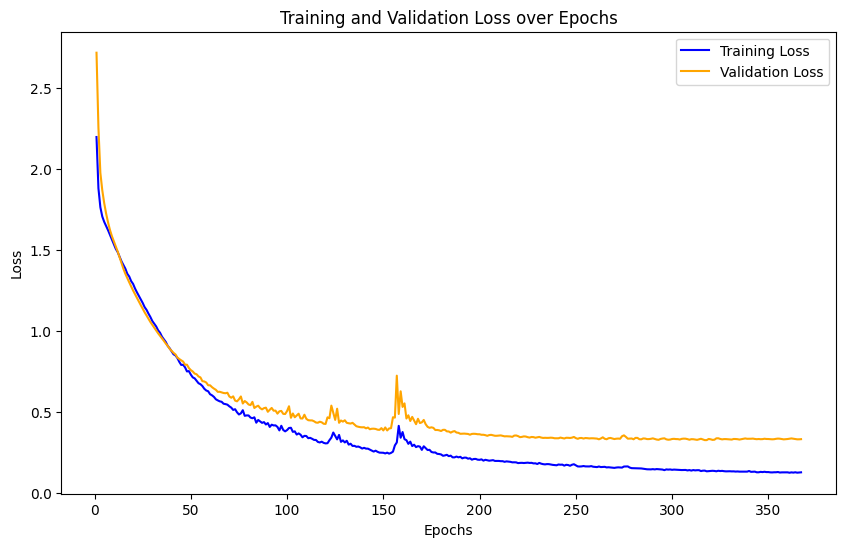

Accuracy: 0.8837, Precision: 0.8914, Recall: 0.8828, F1 Score: 0.8834


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, BatchNorm
from torch_geometric.data import Data, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt

# Define the Enhanced GraphSAGE model
class EnhancedGraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(EnhancedGraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.bn1 = BatchNorm(hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.bn2 = BatchNorm(hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, out_channels)
        self.dropout = torch.nn.Dropout(p=0.5)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)

# Assuming df_balanced is already defined and contains the data
# Encode labels
le = LabelEncoder()
le.fit(df_balanced['Diagnosis'])
df_balanced['label'] = le.transform(df_balanced["Diagnosis"])

# Prepare features and labels
X = np.array(df_balanced['Image'].tolist())
y = df_balanced['label'].values

# Flatten the images
X_flat = X.reshape(X.shape[0], -1)

# Normalize the features
scaler = StandardScaler()
X_flat = scaler.fit_transform(X_flat)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=0.2, random_state=42)

# Create edge index using k-nearest neighbors
def create_edge_index(X, k=5):
    from sklearn.neighbors import NearestNeighbors
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='auto').fit(X)
    distances, indices = nbrs.kneighbors(X)
    edge_index = []
    for i, neighbors in enumerate(indices):
        for neighbor in neighbors[1:]:  # Skip the first neighbor (the node itself)
            edge_index.append([i, neighbor])
            edge_index.append([neighbor, i])  # Add both directions (i -> neighbor and neighbor -> i)
    edge_index = np.array(edge_index).T
    return torch.tensor(edge_index, dtype=torch.long)

edge_index = create_edge_index(X_train)

# Prepare PyTorch Geometric data
train_data = Data(x=torch.tensor(X_train, dtype=torch.float), edge_index=edge_index, y=torch.tensor(y_train, dtype=torch.long))
test_data = Data(x=torch.tensor(X_test, dtype=torch.float), edge_index=create_edge_index(X_test), y=torch.tensor(y_test, dtype=torch.long))

# Train the Enhanced GraphSAGE model
def train_enhanced_graphsage_model(train_data, test_data, hidden_channels, lr, weight_decay, epochs=500, patience=50, scheduler_patience=20, factor=0.5, min_lr=1e-4, batch_size=32, device='cpu'):
    model = EnhancedGraphSAGE(in_channels=train_data.num_features, hidden_channels=hidden_channels, out_channels=train_data.y.max().item() + 1).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=factor, patience=scheduler_patience, min_lr=min_lr)

    best_loss = float('inf')
    best_model = None
    patience_counter = 0

    train_loader = DataLoader([train_data], batch_size=batch_size, shuffle=True)
    test_loader = DataLoader([test_data], batch_size=batch_size, shuffle=False)

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        for data in train_loader:
            optimizer.zero_grad()
            data = data.to(device)
            out = model(data)
            loss = F.nll_loss(out, data.y)
            loss.backward()
            optimizer.step()

        # Evaluate on validation set
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data in test_loader:
                data = data.to(device)
                val_out = model(data)
                val_loss += F.nll_loss(val_out, data.y).item()
        val_loss /= len(test_loader)

        scheduler.step(val_loss)

        train_losses.append(loss.item())
        val_losses.append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}, Val Loss: {val_loss}, LR: {optimizer.param_groups[0]["lr"]}')

        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

    # Load the best model
    model.load_state_dict(best_model)
    return model, train_losses, val_losses

# Train the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model, train_losses, val_losses = train_enhanced_graphsage_model(train_data, test_data, hidden_channels=128, lr=0.001, weight_decay=5e-4, epochs=500, patience=50, scheduler_patience=20, factor=0.5, min_lr=1e-4, batch_size=32, device=device)

# Plot training and validation loss
def plot_losses(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, 'b', label='Training Loss')
    plt.plot(epochs, val_losses, 'orange', label='Validation Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Plot the losses
plot_losses(train_losses, val_losses)

# Evaluate the model
def evaluate_model(model, test_data, device='cpu'):
    model.eval()
    test_loader = DataLoader([test_data], batch_size=32, shuffle=False)
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            out = model(data)
            pred = out.argmax(dim=1)
            all_preds.append(pred.cpu().numpy())
            all_labels.append(data.y.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='macro')
    rec = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    print(f'Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1 Score: {f1:.4f}')

# Evaluate the trained model
evaluate_model(model, test_data, device=device)


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, BatchNorm
from torch_geometric.data import Data, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Define the Enhanced GraphSAGE model
class EnhancedGraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(EnhancedGraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.bn1 = BatchNorm(hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.bn2 = BatchNorm(hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, out_channels)
        self.dropout = torch.nn.Dropout(p=0.5)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)

# Assuming df_balanced is already defined and contains the data
# Encode labels
le = LabelEncoder()
le.fit(df_balanced['Diagnosis'])
df_balanced['label'] = le.transform(df_balanced["Diagnosis"])

# Prepare features and labels
X = np.array(df_balanced['Image'].tolist())
y = df_balanced['label'].values

# Flatten the images
X_flat = X.reshape(X.shape[0], -1)

# Normalize the features
scaler = StandardScaler()
X_flat = scaler.fit_transform(X_flat)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=0.2, random_state=42)

# Create edge index using k-nearest neighbors
def create_edge_index(X, k=5):
    from sklearn.neighbors import NearestNeighbors
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='auto').fit(X)
    distances, indices = nbrs.kneighbors(X)
    edge_index = []
    for i, neighbors in enumerate(indices):
        for neighbor in neighbors[1:]:  # Skip the first neighbor (the node itself)
            edge_index.append([i, neighbor])
            edge_index.append([neighbor, i])  # Add both directions (i -> neighbor and neighbor -> i)
    edge_index = np.array(edge_index).T
    return torch.tensor(edge_index, dtype=torch.long)

edge_index = create_edge_index(X_train)

# Prepare PyTorch Geometric data
train_data = Data(x=torch.tensor(X_train, dtype=torch.float), edge_index=edge_index, y=torch.tensor(y_train, dtype=torch.long))
test_data = Data(x=torch.tensor(X_test, dtype=torch.float), edge_index=create_edge_index(X_test), y=torch.tensor(y_test, dtype=torch.long))

# Train the Enhanced GraphSAGE model
def train_enhanced_graphsage_model(train_data, test_data, hidden_channels, lr, weight_decay, epochs=500, patience=100, scheduler_patience=30, factor=0.5, min_lr=1e-4, batch_size=32, device='cpu'):
    model = EnhancedGraphSAGE(in_channels=train_data.num_features, hidden_channels=hidden_channels, out_channels=train_data.y.max().item() + 1).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=factor, patience=scheduler_patience, min_lr=min_lr)

    best_loss = float('inf')
    best_model = None
    patience_counter = 0

    train_loader = DataLoader([train_data], batch_size=batch_size, shuffle=True)
    test_loader = DataLoader([test_data], batch_size=batch_size, shuffle=False)

    for epoch in range(epochs):
        model.train()
        for data in train_loader:
            optimizer.zero_grad()
            data = data.to(device)
            out = model(data)
            loss = F.nll_loss(out, data.y)
            loss.backward()
            optimizer.step()

        # Evaluate on validation set
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data in test_loader:
                data = data.to(device)
                val_out = model(data)
                val_loss += F.nll_loss(val_out, data.y).item()
        val_loss /= len(test_loader)

        scheduler.step(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}, Val Loss: {val_loss}, LR: {optimizer.param_groups[0]["lr"]}')

        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

    # Load the best model
    model.load_state_dict(best_model)
    return model

# Train the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = train_enhanced_graphsage_model(train_data, test_data, hidden_channels=128, lr=0.001, weight_decay=5e-4, epochs=500, patience=100, scheduler_patience=30, factor=0.5, min_lr=1e-4, batch_size=32, device=device)

# Evaluate the model
def evaluate_model(model, test_data, device='cpu'):
    model.eval()
    test_loader = DataLoader([test_data], batch_size=32, shuffle=False)
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            out = model(data)
            pred = out.argmax(dim=1)
            all_preds.append(pred.cpu().numpy())
            all_labels.append(data.y.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='macro')
    rec = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    print(f'Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1 Score: {f1:.4f}')

# Evaluate the trained model
evaluate_model(model, test_data, device=device)


Epoch 10/500, Loss: 1.4312995672225952, Val Loss: 1.4895578622817993, LR: 0.001
Epoch 20/500, Loss: 1.1564486026763916, Val Loss: 1.1318174600601196, LR: 0.001
Epoch 30/500, Loss: 0.9482244253158569, Val Loss: 0.9275020956993103, LR: 0.001
Epoch 40/500, Loss: 0.7912736535072327, Val Loss: 0.7971230149269104, LR: 0.001
Epoch 50/500, Loss: 0.6632624864578247, Val Loss: 0.7019947171211243, LR: 0.001
Epoch 60/500, Loss: 0.5621042847633362, Val Loss: 0.6155275702476501, LR: 0.001
Epoch 70/500, Loss: 0.49490365386009216, Val Loss: 0.6030738949775696, LR: 0.001
Epoch 80/500, Loss: 0.46134334802627563, Val Loss: 0.5436456203460693, LR: 0.001
Epoch 90/500, Loss: 0.401438444852829, Val Loss: 0.47994327545166016, LR: 0.001
Epoch 100/500, Loss: 0.3542355000972748, Val Loss: 0.4551199972629547, LR: 0.001
Epoch 110/500, Loss: 0.3177439570426941, Val Loss: 0.44124454259872437, LR: 0.001
Epoch 120/500, Loss: 0.32030007243156433, Val Loss: 0.42269235849380493, LR: 0.001
Epoch 130/500, Loss: 0.308537989

# c. GAT Model (Graph Attention Network)

In [ ]:
import os
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GATConv, BatchNorm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import NearestNeighbors
import numpy as np
import pandas as pd

# Encode labels
le = LabelEncoder()
le.fit(df_balanced['Diagnosis'])
df_balanced['label'] = le.transform(df_balanced["Diagnosis"])

# Check the consistency of the data
print(f"Number of samples in df_balanced: {len(df_balanced)}")
print(f"Number of unique images: {len(df_balanced['Image'])}")

# Prepare features and labels
X = np.array(df_balanced['Image'].tolist())
y = df_balanced['label'].values

# Ensure the number of samples in X and y are consistent
if X.shape[0] != len(y):
    print("Inconsistent number of samples between X and y.")
    min_samples = min(X.shape[0], len(y))
    X = X[:min_samples]
    y = y[:min_samples]
    print(f"Adjusted shape of X: {X.shape}")
    print(f"Adjusted length of y: {len(y)}")

# Flatten the images
X_flat = X.reshape(X.shape[0], -1)
print(f"Shape of X_flat: {X_flat.shape}")

# Normalize the features
scaler = StandardScaler()
X_flat = scaler.fit_transform(X_flat)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=0.2, random_state=42)

# Create edge index using k-nearest neighbors
def create_edge_index(X, k=5):
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='auto').fit(X)
    distances, indices = nbrs.kneighbors(X)
    edge_index = []
    for i, neighbors in enumerate(indices):
        for neighbor in neighbors[1:]:  # Skip the first neighbor (the node itself)
            edge_index.append([i, neighbor])
            edge_index.append([neighbor, i])  # Add both directions (i -> neighbor and neighbor -> i)
    edge_index = np.array(edge_index).T
    return torch.tensor(edge_index, dtype=torch.long)

edge_index = create_edge_index(X_train)

# Prepare PyTorch Geometric data
train_data = Data(x=torch.tensor(X_train, dtype=torch.float), edge_index=edge_index, y=torch.tensor(y_train, dtype=torch.long))
test_data = Data(x=torch.tensor(X_test, dtype=torch.float), edge_index=create_edge_index(X_test), y=torch.tensor(y_test, dtype=torch.long))

# Define the GAT model
class GAT(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, num_classes, heads=1):
        super(GAT, self).__init__()
        self.conv1 = GATConv(num_node_features, hidden_channels, heads=heads)
        self.bn1 = BatchNorm(hidden_channels * heads)
        self.conv2 = GATConv(hidden_channels * heads, hidden_channels, heads=heads)
        self.bn2 = BatchNorm(hidden_channels * heads)
        self.conv3 = GATConv(hidden_channels * heads, num_classes, heads=1)
        self.dropout = torch.nn.Dropout(p=0.5)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.elu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.elu(x)
        x = self.dropout(x)
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)

# Train GAT model with early stopping and learning rate scheduler
def train_gat_model(train_data, test_data, hidden_channels, lr, weight_decay, epochs=500, patience=200, scheduler_patience=100, factor=0.5, min_lr=1e-5, batch_size=32, device='cpu'):
    model = GAT(num_node_features=train_data.num_features, hidden_channels=hidden_channels, num_classes=train_data.y.max().item() + 1).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=factor, patience=scheduler_patience, min_lr=min_lr)

    best_loss = float('inf')
    best_model = None
    patience_counter = 0

    train_loader = DataLoader([train_data], batch_size=batch_size, shuffle=True)
    test_loader = DataLoader([test_data], batch_size=batch_size, shuffle=False)

    for epoch in range(epochs):
        model.train()
        for data in train_loader:
            optimizer.zero_grad()
            data = data.to(device)
            out = model(data)
            loss = F.nll_loss(out, data.y)
            loss.backward()
            optimizer.step()

        # Evaluate on validation set
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data in test_loader:
                data = data.to(device)
                val_out = model(data)
                val_loss += F.nll_loss(val_out, data.y).item()
        val_loss /= len(test_loader)

        scheduler.step(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}, Val Loss: {val_loss}, LR: {optimizer.param_groups[0]["lr"]}')

        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

    # Load the best model
    model.load_state_dict(best_model)
    return model

# Train the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = train_gat_model(train_data, test_data, hidden_channels=128, lr=0.001, weight_decay=5e-4, epochs=500, patience=200, scheduler_patience=100, factor=0.5, min_lr=1e-5, batch_size=32, device=device)

# Evaluate the model
def evaluate_model(model, test_data, device='cpu'):
    model.eval()
    test_loader = DataLoader([test_data], batch_size=32, shuffle=False)
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            out = model(data)
            pred = out.argmax(dim=1)
            all_preds.append(pred.cpu().numpy())
            all_labels.append(data.y.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='macro')
    rec = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    print(f'Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1 Score: {f1:.4f}')

# Evaluate the trained model
evaluate_model(model, test_data, device=device)


Number of samples in df_balanced: 46935
Number of unique images: 46935
Shape of X_flat: (46935, 3072)
Epoch 10/500, Loss: 1.5170608758926392, Val Loss: 1.485975980758667, LR: 0.001
Epoch 20/500, Loss: 1.3255831003189087, Val Loss: 1.2629646062850952, LR: 0.001
Epoch 30/500, Loss: 1.1647427082061768, Val Loss: 1.1384638547897339, LR: 0.001
Epoch 40/500, Loss: 1.0214518308639526, Val Loss: 1.0396437644958496, LR: 0.001
Epoch 50/500, Loss: 0.8857812881469727, Val Loss: 0.9438832998275757, LR: 0.001
Epoch 60/500, Loss: 0.7790579795837402, Val Loss: 0.896763801574707, LR: 0.001
Epoch 70/500, Loss: 0.7064456939697266, Val Loss: 0.7919243574142456, LR: 0.001
Epoch 80/500, Loss: 0.6283000707626343, Val Loss: 0.7450796365737915, LR: 0.001
Epoch 90/500, Loss: 0.5623550415039062, Val Loss: 0.6952081918716431, LR: 0.001
Epoch 100/500, Loss: 0.5576877593994141, Val Loss: 0.6878806948661804, LR: 0.001
Epoch 110/500, Loss: 0.47773614525794983, Val Loss: 0.6540062427520752, LR: 0.001
Epoch 120/500, Lo

In [ ]:
import os
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GATConv, BatchNorm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import NearestNeighbors
import numpy as np
import pandas as pd

# Encode labels
le = LabelEncoder()
le.fit(df_balanced['Diagnosis'])
df_balanced['label'] = le.transform(df_balanced["Diagnosis"])

# Check the consistency of the data
print(f"Number of samples in df_balanced: {len(df_balanced)}")
print(f"Number of unique images: {len(df_balanced['Image'])}")

# Prepare features and labels
X = np.array(df_balanced['Image'].tolist())
y = df_balanced['label'].values

# Ensure the number of samples in X and y are consistent
if X.shape[0] != len(y):
    print("Inconsistent number of samples between X and y.")
    min_samples = min(X.shape[0], len(y))
    X = X[:min_samples]
    y = y[:min_samples]
    print(f"Adjusted shape of X: {X.shape}")
    print(f"Adjusted length of y: {len(y)}")

# Flatten the images
X_flat = X.reshape(X.shape[0], -1)
print(f"Shape of X_flat: {X_flat.shape}")

# Normalize the features
scaler = StandardScaler()
X_flat = scaler.fit_transform(X_flat)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=0.2, random_state=42)

# Create edge index using k-nearest neighbors
def create_edge_index(X, k=5):
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='auto').fit(X)
    distances, indices = nbrs.kneighbors(X)
    edge_index = []
    for i, neighbors in enumerate(indices):
        for neighbor in neighbors[1:]:  # Skip the first neighbor (the node itself)
            edge_index.append([i, neighbor])
            edge_index.append([neighbor, i])  # Add both directions (i -> neighbor and neighbor -> i)
    edge_index = np.array(edge_index).T
    return torch.tensor(edge_index, dtype=torch.long)

edge_index = create_edge_index(X_train)

# Prepare PyTorch Geometric data
train_data = Data(x=torch.tensor(X_train, dtype=torch.float), edge_index=edge_index, y=torch.tensor(y_train, dtype=torch.long))
test_data = Data(x=torch.tensor(X_test, dtype=torch.float), edge_index=create_edge_index(X_test), y=torch.tensor(y_test, dtype=torch.long))

# Define the GAT model
class GAT(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, num_classes, heads=1):
        super(GAT, self).__init__()
        self.conv1 = GATConv(num_node_features, hidden_channels, heads=heads)
        self.bn1 = BatchNorm(hidden_channels * heads)
        self.conv2 = GATConv(hidden_channels * heads, hidden_channels, heads=heads)
        self.bn2 = BatchNorm(hidden_channels * heads)
        self.conv3 = GATConv(hidden_channels * heads, num_classes, heads=1)
        self.dropout = torch.nn.Dropout(p=0.5)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.elu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.elu(x)
        x = self.dropout(x)
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)

# Train GAT model with early stopping and learning rate scheduler
def train_gat_model(train_data, test_data, hidden_channels, lr, weight_decay, epochs=500, patience=100, scheduler_patience=30, factor=0.5, min_lr=1e-5, batch_size=32, device='cpu'):
    model = GAT(num_node_features=train_data.num_features, hidden_channels=hidden_channels, num_classes=train_data.y.max().item() + 1).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=factor, patience=scheduler_patience, min_lr=min_lr)

    best_loss = float('inf')
    best_model = None
    patience_counter = 0

    train_loader = DataLoader([train_data], batch_size=batch_size, shuffle=True)
    test_loader = DataLoader([test_data], batch_size=batch_size, shuffle=False)

    for epoch in range(epochs):
        model.train()
        for data in train_loader:
            optimizer.zero_grad()
            data = data.to(device)
            out = model(data)
            loss = F.nll_loss(out, data.y)
            loss.backward()
            optimizer.step()

        # Evaluate on validation set
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data in test_loader:
                data = data.to(device)
                val_out = model(data)
                val_loss += F.nll_loss(val_out, data.y).item()
        val_loss /= len(test_loader)

        scheduler.step(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}, Val Loss: {val_loss}, LR: {optimizer.param_groups[0]["lr"]}')

        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

    # Load the best model
    model.load_state_dict(best_model)
    return model

# Train the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = train_gat_model(train_data, test_data, hidden_channels=128, lr=0.001, weight_decay=5e-4, epochs=500, patience=100, scheduler_patience=30, factor=0.5, min_lr=1e-5, batch_size=32, device=device)

# Evaluate the model
def evaluate_model(model, test_data, device='cpu'):
    model.eval()
    test_loader = DataLoader([test_data], batch_size=32, shuffle=False)
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            out = model(data)
            pred = out.argmax(dim=1)
            all_preds.append(pred.cpu().numpy())
            all_labels.append(data.y.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='macro')
    rec = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    print(f'Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1 Score: {f1:.4f}')

# Evaluate the trained model
evaluate_model(model, test_data, device=device)


Number of samples in df_balanced: 46935
Number of unique images: 46935
Shape of X_flat: (46935, 3072)
Epoch 10/500, Loss: 1.499005675315857, Val Loss: 1.4860132932662964, LR: 0.001
Epoch 20/500, Loss: 1.298941731452942, Val Loss: 1.2755032777786255, LR: 0.001
Epoch 30/500, Loss: 1.1297868490219116, Val Loss: 1.1233323812484741, LR: 0.001
Epoch 40/500, Loss: 0.9844180941581726, Val Loss: 1.0108706951141357, LR: 0.001
Epoch 50/500, Loss: 0.8573217391967773, Val Loss: 0.914347231388092, LR: 0.001
Epoch 60/500, Loss: 0.7634434700012207, Val Loss: 0.8378633260726929, LR: 0.001
Epoch 70/500, Loss: 0.6701021194458008, Val Loss: 0.7796676158905029, LR: 0.001
Epoch 80/500, Loss: 0.6011220812797546, Val Loss: 0.7292572855949402, LR: 0.001
Epoch 90/500, Loss: 0.571230947971344, Val Loss: 0.7258415818214417, LR: 0.001
Epoch 100/500, Loss: 0.5420937538146973, Val Loss: 0.6746530532836914, LR: 0.001
Epoch 110/500, Loss: 0.46339336037635803, Val Loss: 0.6520963311195374, LR: 0.001
Epoch 120/500, Loss

#### With Plot

Number of samples in df_balanced: 46935
Number of unique images: 46935
Shape of X_flat: (46935, 3072)
Epoch 10/500, Loss: 1.6719117164611816, Val Loss: 1.6388881206512451, LR: 0.001
Epoch 20/500, Loss: 1.4258512258529663, Val Loss: 1.3536871671676636, LR: 0.001
Epoch 30/500, Loss: 1.2686890363693237, Val Loss: 1.211719036102295, LR: 0.001
Epoch 40/500, Loss: 1.083168864250183, Val Loss: 1.0878913402557373, LR: 0.001
Epoch 50/500, Loss: 0.9439541101455688, Val Loss: 0.9852349162101746, LR: 0.001
Epoch 60/500, Loss: 0.8191599249839783, Val Loss: 0.9054848551750183, LR: 0.001
Epoch 70/500, Loss: 0.722038209438324, Val Loss: 0.8370018005371094, LR: 0.001
Epoch 80/500, Loss: 0.6513281464576721, Val Loss: 0.7804760336875916, LR: 0.001
Epoch 90/500, Loss: 0.6435990929603577, Val Loss: 0.7376578450202942, LR: 0.001
Epoch 100/500, Loss: 0.5685034990310669, Val Loss: 0.707510769367218, LR: 0.001
Epoch 110/500, Loss: 0.5259758234024048, Val Loss: 0.7212940454483032, LR: 0.001
Epoch 120/500, Loss:

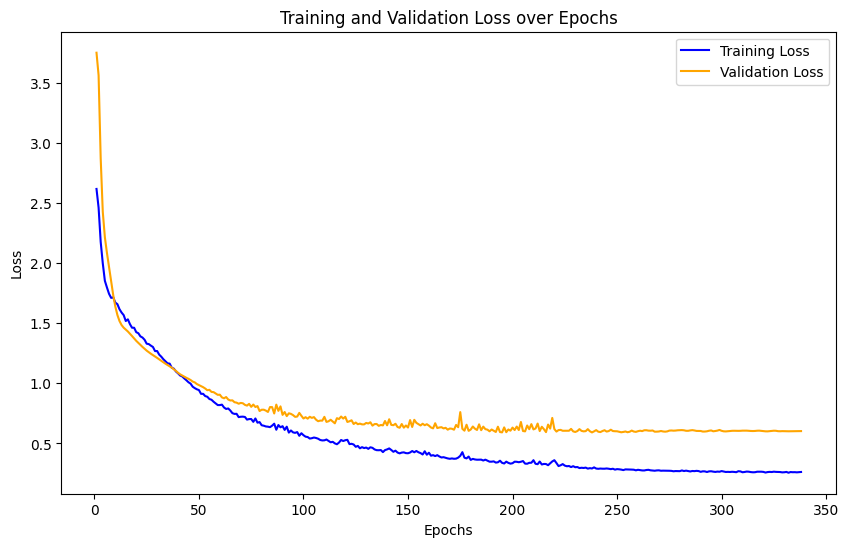

Accuracy: 0.7988, Precision: 0.8021, Recall: 0.7978, F1 Score: 0.7987


In [ ]:
import os
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GATConv, BatchNorm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import NearestNeighbors
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Encode labels
le = LabelEncoder()
le.fit(df_balanced['Diagnosis'])
df_balanced['label'] = le.transform(df_balanced["Diagnosis"])

# Check the consistency of the data
print(f"Number of samples in df_balanced: {len(df_balanced)}")
print(f"Number of unique images: {len(df_balanced['Image'])}")

# Prepare features and labels
X = np.array(df_balanced['Image'].tolist())
y = df_balanced['label'].values

# Ensure the number of samples in X and y are consistent
if X.shape[0] != len(y):
    print("Inconsistent number of samples between X and y.")
    min_samples = min(X.shape[0], len(y))
    X = X[:min_samples]
    y = y[:min_samples]
    print(f"Adjusted shape of X: {X.shape}")
    print(f"Adjusted length of y: {len(y)}")

# Flatten the images
X_flat = X.reshape(X.shape[0], -1)
print(f"Shape of X_flat: {X_flat.shape}")

# Normalize the features
scaler = StandardScaler()
X_flat = scaler.fit_transform(X_flat)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=0.2, random_state=42)

# Create edge index using k-nearest neighbors
def create_edge_index(X, k=5):
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='auto').fit(X)
    distances, indices = nbrs.kneighbors(X)
    edge_index = []
    for i, neighbors in enumerate(indices):
        for neighbor in neighbors[1:]:  # Skip the first neighbor (the node itself)
            edge_index.append([i, neighbor])
            edge_index.append([neighbor, i])  # Add both directions (i -> neighbor and neighbor -> i)
    edge_index = np.array(edge_index).T
    return torch.tensor(edge_index, dtype=torch.long)

edge_index = create_edge_index(X_train)

# Prepare PyTorch Geometric data
train_data = Data(x=torch.tensor(X_train, dtype=torch.float), edge_index=edge_index, y=torch.tensor(y_train, dtype=torch.long))
test_data = Data(x=torch.tensor(X_test, dtype=torch.float), edge_index=create_edge_index(X_test), y=torch.tensor(y_test, dtype=torch.long))

# Define the GAT model
class GAT(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, num_classes, heads=1):
        super(GAT, self).__init__()
        self.conv1 = GATConv(num_node_features, hidden_channels, heads=heads)
        self.bn1 = BatchNorm(hidden_channels * heads)
        self.conv2 = GATConv(hidden_channels * heads, hidden_channels, heads=heads)
        self.bn2 = BatchNorm(hidden_channels * heads)
        self.conv3 = GATConv(hidden_channels * heads, num_classes, heads=1)
        self.dropout = torch.nn.Dropout(p=0.5)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.elu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.elu(x)
        x = self.dropout(x)
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)

# Train GAT model with early stopping and learning rate scheduler
def train_gat_model(train_data, test_data, hidden_channels, lr, weight_decay, epochs=500, patience=100, scheduler_patience=30, factor=0.5, min_lr=1e-5, batch_size=32, device='cpu'):
    model = GAT(num_node_features=train_data.num_features, hidden_channels=hidden_channels, num_classes=train_data.y.max().item() + 1).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=factor, patience=scheduler_patience, min_lr=min_lr)

    best_loss = float('inf')
    best_model = None
    patience_counter = 0

    train_loader = DataLoader([train_data], batch_size=batch_size, shuffle=True)
    test_loader = DataLoader([test_data], batch_size=batch_size, shuffle=False)

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        for data in train_loader:
            optimizer.zero_grad()
            data = data.to(device)
            out = model(data)
            loss = F.nll_loss(out, data.y)
            loss.backward()
            optimizer.step()

        # Evaluate on validation set
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data in test_loader:
                data = data.to(device)
                val_out = model(data)
                val_loss += F.nll_loss(val_out, data.y).item()
        val_loss /= len(test_loader)

        scheduler.step(val_loss)

        train_losses.append(loss.item())
        val_losses.append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}, Val Loss: {val_loss}, LR: {optimizer.param_groups[0]["lr"]}')

        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

    # Load the best model
    model.load_state_dict(best_model)
    return model, train_losses, val_losses

# Train the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model, train_losses, val_losses = train_gat_model(train_data, test_data, hidden_channels=128, lr=0.001, weight_decay=5e-4, epochs=500, patience=100, scheduler_patience=30, factor=0.5, min_lr=1e-5, batch_size=32, device=device)

# Plot training and validation loss
def plot_losses(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, 'b', label='Training Loss')
    plt.plot(epochs, val_losses, 'orange', label='Validation Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Plot the losses
plot_losses(train_losses, val_losses)

# Evaluate the model
def evaluate_model(model, test_data, device='cpu'):
    model.eval()
    test_loader = DataLoader([test_data], batch_size=32, shuffle=False)
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            out = model(data)
            pred = out.argmax(dim=1)
            all_preds.append(pred.cpu().numpy())
            all_labels.append(data.y.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='macro')
    rec = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    print(f'Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1 Score: {f1:.4f}')

# Evaluate the trained model
evaluate_model(model, test_data, device=device)


Number of samples in df_balanced: 46935
Number of unique images: 46935
Shape of X_flat: (46935, 3072)
Epoch 10/500, Loss: 1.56453275680542, Val Loss: 1.4922093152999878, LR: 0.001
Epoch 20/500, Loss: 1.3045910596847534, Val Loss: 1.2796262502670288, LR: 0.001
Epoch 30/500, Loss: 1.1415899991989136, Val Loss: 1.1450499296188354, LR: 0.001
Epoch 40/500, Loss: 0.9917502403259277, Val Loss: 1.0366460084915161, LR: 0.001
Epoch 50/500, Loss: 0.8789122700691223, Val Loss: 0.9385120272636414, LR: 0.001
Epoch 60/500, Loss: 0.7882997393608093, Val Loss: 0.8600230813026428, LR: 0.001
Epoch 70/500, Loss: 0.7110947966575623, Val Loss: 0.7941902875900269, LR: 0.001
Epoch 80/500, Loss: 0.639245331287384, Val Loss: 0.7507277727127075, LR: 0.001
Epoch 90/500, Loss: 0.5726130604743958, Val Loss: 0.7067511677742004, LR: 0.001
Epoch 100/500, Loss: 0.5300552248954773, Val Loss: 0.6916075348854065, LR: 0.001
Epoch 110/500, Loss: 0.509485125541687, Val Loss: 0.679634690284729, LR: 0.001
Epoch 120/500, Loss: 

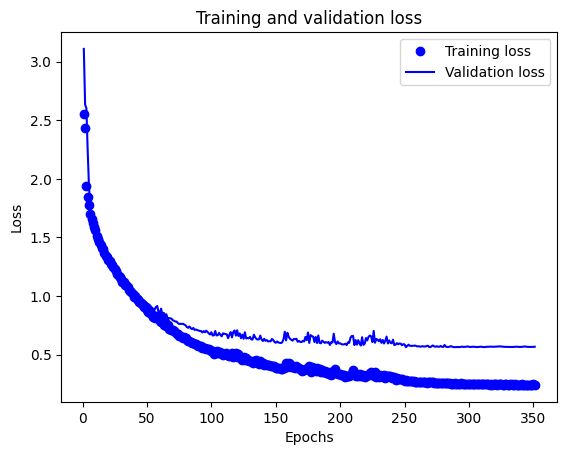

Accuracy: 0.8025, Precision: 0.8054, Recall: 0.8017, F1 Score: 0.8030


In [ ]:
import os
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GATConv, BatchNorm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import NearestNeighbors
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Encode labels
le = LabelEncoder()
le.fit(df_balanced['Diagnosis'])
df_balanced['label'] = le.transform(df_balanced["Diagnosis"])

# Check the consistency of the data
print(f"Number of samples in df_balanced: {len(df_balanced)}")
print(f"Number of unique images: {len(df_balanced['Image'])}")

# Prepare features and labels
X = np.array(df_balanced['Image'].tolist())
y = df_balanced['label'].values

# Ensure the number of samples in X and y are consistent
if X.shape[0] != len(y):
    print("Inconsistent number of samples between X and y.")
    min_samples = min(X.shape[0], len(y))
    X = X[:min_samples]
    y = y[:min_samples]
    print(f"Adjusted shape of X: {X.shape}")
    print(f"Adjusted length of y: {len(y)}")

# Flatten the images
X_flat = X.reshape(X.shape[0], -1)
print(f"Shape of X_flat: {X_flat.shape}")

# Normalize the features
scaler = StandardScaler()
X_flat = scaler.fit_transform(X_flat)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=0.2, random_state=42)

# Create edge index using k-nearest neighbors
def create_edge_index(X, k=5):
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='auto').fit(X)
    distances, indices = nbrs.kneighbors(X)
    edge_index = []
    for i, neighbors in enumerate(indices):
        for neighbor in neighbors[1:]:  # Skip the first neighbor (the node itself)
            edge_index.append([i, neighbor])
            edge_index.append([neighbor, i])  # Add both directions (i -> neighbor and neighbor -> i)
    edge_index = np.array(edge_index).T
    return torch.tensor(edge_index, dtype=torch.long)

edge_index = create_edge_index(X_train)

# Prepare PyTorch Geometric data
train_data = Data(x=torch.tensor(X_train, dtype=torch.float), edge_index=edge_index, y=torch.tensor(y_train, dtype=torch.long))
test_data = Data(x=torch.tensor(X_test, dtype=torch.float), edge_index=create_edge_index(X_test), y=torch.tensor(y_test, dtype=torch.long))

# Define the GAT model
class GAT(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, num_classes, heads=1):
        super(GAT, self).__init__()
        self.conv1 = GATConv(num_node_features, hidden_channels, heads=heads)
        self.bn1 = BatchNorm(hidden_channels * heads)
        self.conv2 = GATConv(hidden_channels * heads, hidden_channels, heads=heads)
        self.bn2 = BatchNorm(hidden_channels * heads)
        self.conv3 = GATConv(hidden_channels * heads, num_classes, heads=1)
        self.dropout = torch.nn.Dropout(p=0.5)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.elu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.elu(x)
        x = self.dropout(x)
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)

# Train GAT model with early stopping and learning rate scheduler
def train_gat_model(train_data, test_data, hidden_channels, lr, weight_decay, epochs=500, patience=100, scheduler_patience=30, factor=0.5, min_lr=1e-5, batch_size=32, device='cpu'):
    model = GAT(num_node_features=train_data.num_features, hidden_channels=hidden_channels, num_classes=train_data.y.max().item() + 1).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=factor, patience=scheduler_patience, min_lr=min_lr)

    best_loss = float('inf')
    best_model = None
    patience_counter = 0

    train_loader = DataLoader([train_data], batch_size=batch_size, shuffle=True)
    test_loader = DataLoader([test_data], batch_size=batch_size, shuffle=False)

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        for data in train_loader:
            optimizer.zero_grad()
            data = data.to(device)
            out = model(data)
            loss = F.nll_loss(out, data.y)
            loss.backward()
            optimizer.step()

        # Evaluate on validation set
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data in test_loader:
                data = data.to(device)
                val_out = model(data)
                val_loss += F.nll_loss(val_out, data.y).item()
        val_loss /= len(test_loader)

        scheduler.step(val_loss)

        train_losses.append(loss.item())
        val_losses.append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}, Val Loss: {val_loss}, LR: {optimizer.param_groups[0]["lr"]}')

        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

    # Load the best model
    model.load_state_dict(best_model)
    return model, train_losses, val_losses

# Train the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model, train_losses, val_losses = train_gat_model(train_data, test_data, hidden_channels=128, lr=0.001, weight_decay=5e-4, epochs=500, patience=100, scheduler_patience=30, factor=0.5, min_lr=1e-5, batch_size=32, device=device)

# Plot training and validation loss
def plot_losses(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)
    plt.plot(epochs, train_losses, 'bo', label='Training loss')
    plt.plot(epochs, val_losses, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Plot the losses
plot_losses(train_losses, val_losses)

# Evaluate the model
def evaluate_model(model, test_data, device='cpu'):
    model.eval()
    test_loader = DataLoader([test_data], batch_size=32, shuffle=False)
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            out = model(data)
            pred = out.argmax(dim=1)
            all_preds.append(pred.cpu().numpy())
            all_labels.append(data.y.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='macro')
    rec = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    print(f'Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1 Score: {f1:.4f}')

# Evaluate the trained model
evaluate_model(model, test_data, device=device)


# d. ChebNet (Chebyshev Networks)

In [ ]:
import os
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import ChebConv, BatchNorm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import NearestNeighbors
import numpy as np
import pandas as pd

# Encode labels
le = LabelEncoder()
le.fit(df_balanced['Diagnosis'])
df_balanced['label'] = le.transform(df_balanced["Diagnosis"])

# Check the consistency of the data
print(f"Number of samples in df_balanced: {len(df_balanced)}")
print(f"Number of unique images: {len(df_balanced['Image'])}")

# Prepare features and labels
X = np.array(df_balanced['Image'].tolist())
y = df_balanced['label'].values

# Ensure the number of samples in X and y are consistent
if X.shape[0] != len(y):
    print("Inconsistent number of samples between X and y.")
    min_samples = min(X.shape[0], len(y))
    X = X[:min_samples]
    y = y[:min_samples]
    print(f"Adjusted shape of X: {X.shape}")
    print(f"Adjusted length of y: {len(y)}")

# Flatten the images
X_flat = X.reshape(X.shape[0], -1)
print(f"Shape of X_flat: {X_flat.shape}")

# Normalize the features
scaler = StandardScaler()
X_flat = scaler.fit_transform(X_flat)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=0.2, random_state=42)

# Create edge index using k-nearest neighbors
def create_edge_index(X, k=5):
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='auto').fit(X)
    distances, indices = nbrs.kneighbors(X)
    edge_index = []
    for i, neighbors in enumerate(indices):
        for neighbor in neighbors[1:]:  # Skip the first neighbor (the node itself)
            edge_index.append([i, neighbor])
            edge_index.append([neighbor, i])  # Add both directions (i -> neighbor and neighbor -> i)
    edge_index = np.array(edge_index).T
    return torch.tensor(edge_index, dtype=torch.long)

# Prepare DataLoader with mini-batches
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, edge_index):
        self.X = torch.tensor(X, dtype=torch.float)
        self.y = torch.tensor(y, dtype=torch.long)
        self.edge_index = edge_index

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return Data(x=self.X, edge_index=self.edge_index, y=self.y[idx])

train_dataset = CustomDataset(X_train, y_train, create_edge_index(X_train))
test_dataset = CustomDataset(X_test, y_test, create_edge_index(X_test))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the ChebNet model
class ChebNet(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, num_classes, K=2):
        super(ChebNet, self).__init__()
        self.conv1 = ChebConv(num_node_features, hidden_channels, K)
        self.bn1 = BatchNorm(hidden_channels)
        self.conv2 = ChebConv(hidden_channels, hidden_channels, K)
        self.bn2 = BatchNorm(hidden_channels)
        self.conv3 = ChebConv(hidden_channels, num_classes, K)
        self.dropout = torch.nn.Dropout(p=0.5)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)

# Train ChebNet model with early stopping and learning rate scheduler
def train_chebnet_model(train_loader, test_loader, hidden_channels, lr, weight_decay, epochs=500, patience=100, scheduler_patience=30, factor=0.5, min_lr=1e-5, device='cpu'):
    model = ChebNet(num_node_features=train_loader.dataset[0].x.shape[1], hidden_channels=hidden_channels, num_classes=len(np.unique(train_loader.dataset.y)), K=2).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=factor, patience=scheduler_patience, min_lr=min_lr)

    best_loss = float('inf')
    best_model = None
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        for data in train_loader:
            optimizer.zero_grad()
            data = data.to(device)
            out = model(data)
            loss = F.nll_loss(out, data.y)
            loss.backward()
            optimizer.step()

        # Evaluate on validation set
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data in test_loader:
                data = data.to(device)
                val_out = model(data)
                val_loss += F.nll_loss(val_out, data.y).item()
        val_loss /= len(test_loader)

        scheduler.step(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}, Val Loss: {val_loss}, LR: {optimizer.param_groups[0]["lr"]}')

        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

    # Load the best model
    model.load_state_dict(best_model)
    return model

# Train the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = train_chebnet_model(train_loader, test_loader, hidden_channels=128, lr=0.001, weight_decay=5e-4, epochs=500, patience=100, scheduler_patience=30, factor=0.5, min_lr=1e-5, device=device)

# Evaluate the model
def evaluate_model(model, test_loader, device='cpu'):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            out = model(data)
            pred = out.argmax(dim=1)
            all_preds.append(pred.cpu().numpy())
            all_labels.append(data.y.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='macro')
    rec = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    print(f'Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1 Score: {f1:.4f}')

# Evaluate the trained model
evaluate_model(model, test_loader, device=device)


Number of samples in df_balanced: 46935
Number of unique images: 46935
Shape of X_flat: (46935, 3072)


#e. MoNet (Mixture Model Network)

In [ ]:
!pip install torch
!pip install torch-geometric
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-<version>+cpu.html


/bin/bash: line 1: version: No such file or directory


In [ ]:
import os
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GMMConv, BatchNorm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import NearestNeighbors
import numpy as np
import pandas as pd

# Encode labels
le = LabelEncoder()
le.fit(df_balanced['Diagnosis'])
df_balanced['label'] = le.transform(df_balanced["Diagnosis"])

# Check the consistency of the data
print(f"Number of samples in df_balanced: {len(df_balanced)}")
print(f"Number of unique images: {len(df_balanced['Image'])}")

# Prepare features and labels
X = np.array(df_balanced['Image'].tolist())
y = df_balanced['label'].values

# Ensure the number of samples in X and y are consistent
if X.shape[0] != len(y):
    print("Inconsistent number of samples between X and y.")
    min_samples = min(X.shape[0], len(y))
    X = X[:min_samples]
    y = y[:min_samples]
    print(f"Adjusted shape of X: {X.shape}")
    print(f"Adjusted length of y: {len(y)}")

# Flatten the images
X_flat = X.reshape(X.shape[0], -1)
print(f"Shape of X_flat: {X_flat.shape}")

# Normalize the features
scaler = StandardScaler()
X_flat = scaler.fit_transform(X_flat)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=0.2, random_state=42)

# Create edge index and pseudo-coordinates using k-nearest neighbors
def create_edge_index_and_pseudo(X, k=5):
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='auto').fit(X)
    distances, indices = nbrs.kneighbors(X)
    edge_index = []
    pseudo_coords = []
    for i, neighbors in enumerate(indices):
        for neighbor in neighbors[1:]:  # Skip the first neighbor (the node itself)
            edge_index.append([i, neighbor])
            edge_index.append([neighbor, i])  # Add both directions (i -> neighbor and neighbor -> i)
            pseudo_coords.append(distances[i][neighbors.tolist().index(neighbor)])
            pseudo_coords.append(distances[i][neighbors.tolist().index(neighbor)])
    edge_index = np.array(edge_index).T
    pseudo_coords = np.array(pseudo_coords)
    return torch.tensor(edge_index, dtype=torch.long), torch.tensor(pseudo_coords, dtype=torch.float).view(-1, 1)

edge_index_train, pseudo_train = create_edge_index_and_pseudo(X_train)
edge_index_test, pseudo_test = create_edge_index_and_pseudo(X_test)

# Prepare PyTorch Geometric data
train_data = Data(x=torch.tensor(X_train, dtype=torch.float), edge_index=edge_index_train, edge_attr=pseudo_train, y=torch.tensor(y_train, dtype=torch.long))
test_data = Data(x=torch.tensor(X_test, dtype=torch.float), edge_index=edge_index_test, edge_attr=pseudo_test, y=torch.tensor(y_test, dtype=torch.long))

# Define the GMMConv model
class GMMNet(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, num_classes, dim=1, kernel_size=3):
        super(GMMNet, self).__init__()
        self.conv1 = GMMConv(num_node_features, hidden_channels, dim, kernel_size)
        self.bn1 = BatchNorm(hidden_channels)
        self.conv2 = GMMConv(hidden_channels, hidden_channels, dim, kernel_size)
        self.bn2 = BatchNorm(hidden_channels)
        self.conv3 = GMMConv(hidden_channels, num_classes, dim, kernel_size)
        self.dropout = torch.nn.Dropout(p=0.5)

    def forward(self, data):
        x, edge_index, pseudo = data.x, data.edge_index, data.edge_attr
        x = self.conv1(x, edge_index, pseudo)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index, pseudo)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv3(x, edge_index, pseudo)
        return F.log_softmax(x, dim=1)

# Train GMMNet model with early stopping and learning rate scheduler
def train_gmmnet_model(train_data, test_data, hidden_channels, lr, weight_decay, epochs=500, patience=100, scheduler_patience=30, factor=0.5, min_lr=1e-5, batch_size=32, device='cpu'):
    model = GMMNet(num_node_features=train_data.num_features, hidden_channels=hidden_channels, num_classes=train_data.y.max().item() + 1).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=factor, patience=scheduler_patience, min_lr=min_lr)

    best_loss = float('inf')
    best_model = None
    patience_counter = 0

    train_loader = DataLoader([train_data], batch_size=batch_size, shuffle=True)
    test_loader = DataLoader([test_data], batch_size=batch_size, shuffle=False)

    for epoch in range(epochs):
        model.train()
        for data in train_loader:
            optimizer.zero_grad()
            data = data.to(device)
            out = model(data)
            loss = F.nll_loss(out, data.y)
            loss.backward()
            optimizer.step()

        # Evaluate on validation set
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data in test_loader:
                data = data.to(device)
                val_out = model(data)
                val_loss += F.nll_loss(val_out, data.y).item()
        val_loss /= len(test_loader)

        scheduler.step(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}, Val Loss: {val_loss}, LR: {optimizer.param_groups[0]["lr"]}')

        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

    # Load the best model
    model.load_state_dict(best_model)
    return model

# Train the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = train_gmmnet_model(train_data, test_data, hidden_channels=128, lr=0.001, weight_decay=5e-4, epochs=500, patience=100, scheduler_patience=30, factor=0.5, min_lr=1e-5, batch_size=32, device=device)

# Evaluate the model
def evaluate_model(model, test_data, device='cpu'):
    model.eval()
    test_loader = DataLoader([test_data], batch_size=32, shuffle=False)
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            out = model(data)
            pred = out.argmax(dim=1)
            all_preds.append(pred.cpu().numpy())
            all_labels.append(data.y.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='macro')
    rec = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    print(f'Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1 Score: {f1:.4f}')

# Evaluate the trained model
evaluate_model(model, test_data, device=device)


Number of samples in df_balanced: 46935
Number of unique images: 46935
Shape of X_flat: (46935, 3072)
Epoch 10/500, Loss: 1.6275690793991089, Val Loss: 1.4515583515167236, LR: 0.001
Epoch 20/500, Loss: 1.3903266191482544, Val Loss: 1.2494899034500122, LR: 0.001
Epoch 30/500, Loss: 1.2118586301803589, Val Loss: 1.1079611778259277, LR: 0.001
Epoch 40/500, Loss: 1.0840638875961304, Val Loss: 0.9943533539772034, LR: 0.001
Epoch 50/500, Loss: 0.9565269947052002, Val Loss: 0.9002801179885864, LR: 0.001
Epoch 60/500, Loss: 0.845877468585968, Val Loss: 0.8026069402694702, LR: 0.001
Epoch 70/500, Loss: 0.7483823895454407, Val Loss: 0.7080034017562866, LR: 0.001
Epoch 80/500, Loss: 0.6706346869468689, Val Loss: 0.6160758137702942, LR: 0.001
Epoch 90/500, Loss: 0.6296393275260925, Val Loss: 0.5641520023345947, LR: 0.001
Epoch 100/500, Loss: 0.5698047280311584, Val Loss: 0.49494469165802, LR: 0.001
Epoch 110/500, Loss: 0.5103544592857361, Val Loss: 0.44454634189605713, LR: 0.001
Epoch 120/500, Los

#### With Plot

Number of samples in df_balanced: 46935
Number of unique images: 46935
Shape of X_flat: (46935, 3072)
Epoch 10/500, Loss: 1.6360366344451904, Val Loss: 1.554646611213684, LR: 0.001
Epoch 20/500, Loss: 1.3825502395629883, Val Loss: 1.2975112199783325, LR: 0.001
Epoch 30/500, Loss: 1.209145426750183, Val Loss: 1.139379620552063, LR: 0.001
Epoch 40/500, Loss: 1.0658921003341675, Val Loss: 1.0197826623916626, LR: 0.001
Epoch 50/500, Loss: 0.9415857195854187, Val Loss: 0.9091652035713196, LR: 0.001
Epoch 60/500, Loss: 0.8346779942512512, Val Loss: 0.8052043914794922, LR: 0.001
Epoch 70/500, Loss: 0.7589946985244751, Val Loss: 0.7145876288414001, LR: 0.001
Epoch 80/500, Loss: 0.6861355304718018, Val Loss: 0.6355671286582947, LR: 0.001
Epoch 90/500, Loss: 0.6297559142112732, Val Loss: 0.5750226378440857, LR: 0.001
Epoch 100/500, Loss: 0.5727035403251648, Val Loss: 0.5237316489219666, LR: 0.001
Epoch 110/500, Loss: 0.53263258934021, Val Loss: 0.47281017899513245, LR: 0.001
Epoch 120/500, Loss:

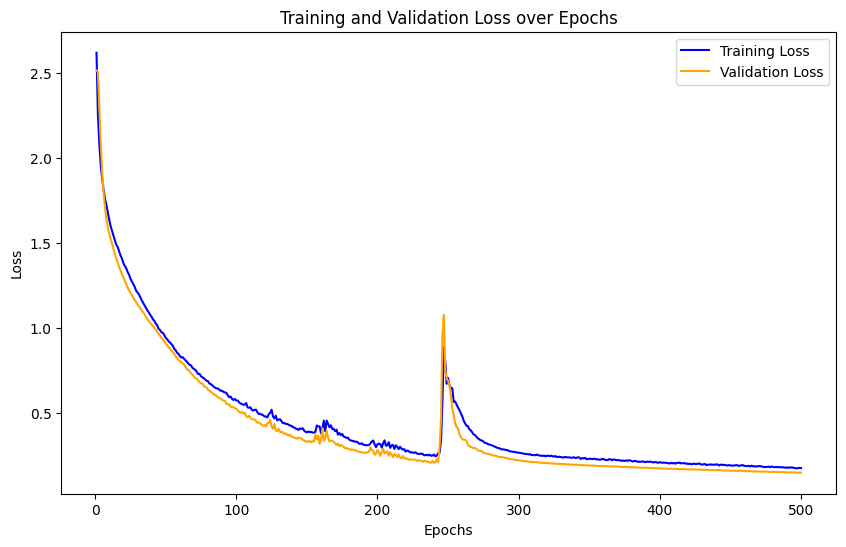

Accuracy: 0.9522, Precision: 0.9525, Recall: 0.9522, F1 Score: 0.9511


In [ ]:
import os
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GMMConv, BatchNorm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import NearestNeighbors
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Encode labels
le = LabelEncoder()
le.fit(df_balanced['Diagnosis'])
df_balanced['label'] = le.transform(df_balanced["Diagnosis"])

# Check the consistency of the data
print(f"Number of samples in df_balanced: {len(df_balanced)}")
print(f"Number of unique images: {len(df_balanced['Image'])}")

# Prepare features and labels
X = np.array(df_balanced['Image'].tolist())
y = df_balanced['label'].values

# Ensure the number of samples in X and y are consistent
if X.shape[0] != len(y):
    print("Inconsistent number of samples between X and y.")
    min_samples = min(X.shape[0], len(y))
    X = X[:min_samples]
    y = y[:min_samples]
    print(f"Adjusted shape of X: {X.shape}")
    print(f"Adjusted length of y: {len(y)}")

# Flatten the images
X_flat = X.reshape(X.shape[0], -1)
print(f"Shape of X_flat: {X_flat.shape}")

# Normalize the features
scaler = StandardScaler()
X_flat = scaler.fit_transform(X_flat)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=0.2, random_state=42)

# Create edge index and pseudo-coordinates using k-nearest neighbors
def create_edge_index_and_pseudo(X, k=5):
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='auto').fit(X)
    distances, indices = nbrs.kneighbors(X)
    edge_index = []
    pseudo_coords = []
    for i, neighbors in enumerate(indices):
        for neighbor in neighbors[1:]:  # Skip the first neighbor (the node itself)
            edge_index.append([i, neighbor])
            edge_index.append([neighbor, i])  # Add both directions (i -> neighbor and neighbor -> i)
            pseudo_coords.append(distances[i][neighbors.tolist().index(neighbor)])
            pseudo_coords.append(distances[i][neighbors.tolist().index(neighbor)])
    edge_index = np.array(edge_index).T
    pseudo_coords = np.array(pseudo_coords)
    return torch.tensor(edge_index, dtype=torch.long), torch.tensor(pseudo_coords, dtype=torch.float).view(-1, 1)

edge_index_train, pseudo_train = create_edge_index_and_pseudo(X_train)
edge_index_test, pseudo_test = create_edge_index_and_pseudo(X_test)

# Prepare PyTorch Geometric data
train_data = Data(x=torch.tensor(X_train, dtype=torch.float), edge_index=edge_index_train, edge_attr=pseudo_train, y=torch.tensor(y_train, dtype=torch.long))
test_data = Data(x=torch.tensor(X_test, dtype=torch.float), edge_index=edge_index_test, edge_attr=pseudo_test, y=torch.tensor(y_test, dtype=torch.long))

# Define the GMMConv model
class GMMNet(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, num_classes, dim=1, kernel_size=3):
        super(GMMNet, self).__init__()
        self.conv1 = GMMConv(num_node_features, hidden_channels, dim, kernel_size)
        self.bn1 = BatchNorm(hidden_channels)
        self.conv2 = GMMConv(hidden_channels, hidden_channels, dim, kernel_size)
        self.bn2 = BatchNorm(hidden_channels)
        self.conv3 = GMMConv(hidden_channels, num_classes, dim, kernel_size)
        self.dropout = torch.nn.Dropout(p=0.5)

    def forward(self, data):
        x, edge_index, pseudo = data.x, data.edge_index, data.edge_attr
        x = self.conv1(x, edge_index, pseudo)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index, pseudo)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv3(x, edge_index, pseudo)
        return F.log_softmax(x, dim=1)

# Train GMMNet model with early stopping and learning rate scheduler
def train_gmmnet_model(train_data, test_data, hidden_channels, lr, weight_decay, epochs=500, patience=100, scheduler_patience=30, factor=0.5, min_lr=1e-5, batch_size=32, device='cpu'):
    model = GMMNet(num_node_features=train_data.num_features, hidden_channels=hidden_channels, num_classes=train_data.y.max().item() + 1).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=factor, patience=scheduler_patience, min_lr=min_lr)

    best_loss = float('inf')
    best_model = None
    patience_counter = 0

    train_loader = DataLoader([train_data], batch_size=batch_size, shuffle=True)
    test_loader = DataLoader([test_data], batch_size=batch_size, shuffle=False)

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        for data in train_loader:
            optimizer.zero_grad()
            data = data.to(device)
            out = model(data)
            loss = F.nll_loss(out, data.y)
            loss.backward()
            optimizer.step()

        # Evaluate on validation set
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data in test_loader:
                data = data.to(device)
                val_out = model(data)
                val_loss += F.nll_loss(val_out, data.y).item()
        val_loss /= len(test_loader)

        scheduler.step(val_loss)

        train_losses.append(loss.item())
        val_losses.append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}, Val Loss: {val_loss}, LR: {optimizer.param_groups[0]["lr"]}')

        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

    # Load the best model
    model.load_state_dict(best_model)
    return model, train_losses, val_losses

# Train the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model, train_losses, val_losses = train_gmmnet_model(train_data, test_data, hidden_channels=128, lr=0.001, weight_decay=5e-4, epochs=500, patience=100, scheduler_patience=30, factor=0.5, min_lr=1e-5, batch_size=32, device=device)

# Plot training and validation loss
def plot_losses(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, 'b', label='Training Loss')
    plt.plot(epochs, val_losses, 'orange', label='Validation Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Plot the losses
plot_losses(train_losses, val_losses)

# Evaluate the model
def evaluate_model(model, test_data, device='cpu'):
    model.eval()
    test_loader = DataLoader([test_data], batch_size=32, shuffle=False)
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            out = model(data)
            pred = out.argmax(dim=1)
            all_preds.append(pred.cpu().numpy())
            all_labels.append(data.y.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='macro')
    rec = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    print(f'Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1 Score: {f1:.4f}')

# Evaluate the trained model
evaluate_model(model, test_data, device=device)


In [ ]:
import os
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GMMConv, BatchNorm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import NearestNeighbors
import numpy as np
import pandas as pd

# Encode labels
le = LabelEncoder()
le.fit(df_balanced['Diagnosis'])
df_balanced['label'] = le.transform(df_balanced["Diagnosis"])

# Check the consistency of the data
print(f"Number of samples in df_balanced: {len(df_balanced)}")
print(f"Number of unique images: {len(df_balanced['Image'])}")

# Prepare features and labels
X = np.array(df_balanced['Image'].tolist())
y = df_balanced['label'].values

# Ensure the number of samples in X and y are consistent
if X.shape[0] != len(y):
    print("Inconsistent number of samples between X and y.")
    min_samples = min(X.shape[0], len(y))
    X = X[:min_samples]
    y = y[:min_samples]
    print(f"Adjusted shape of X: {X.shape}")
    print(f"Adjusted length of y: {len(y)}")

# Flatten the images
X_flat = X.reshape(X.shape[0], -1)
print(f"Shape of X_flat: {X_flat.shape}")

# Normalize the features
scaler = StandardScaler()
X_flat = scaler.fit_transform(X_flat)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=0.2, random_state=42)

# Create edge index and pseudo-coordinates using k-nearest neighbors
def create_edge_index_and_pseudo(X, k=5):
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='auto').fit(X)
    distances, indices = nbrs.kneighbors(X)
    edge_index = []
    pseudo_coords = []
    for i, neighbors in enumerate(indices):
        for neighbor in neighbors[1:]:  # Skip the first neighbor (the node itself)
            edge_index.append([i, neighbor])
            edge_index.append([neighbor, i])  # Add both directions (i -> neighbor and neighbor -> i)
            pseudo_coords.append(distances[i][neighbors.tolist().index(neighbor)])
            pseudo_coords.append(distances[i][neighbors.tolist().index(neighbor)])
    edge_index = np.array(edge_index).T
    pseudo_coords = np.array(pseudo_coords)
    return torch.tensor(edge_index, dtype=torch.long), torch.tensor(pseudo_coords, dtype=torch.float).view(-1, 1)

edge_index_train, pseudo_train = create_edge_index_and_pseudo(X_train)
edge_index_test, pseudo_test = create_edge_index_and_pseudo(X_test)

# Prepare PyTorch Geometric data
train_data = Data(x=torch.tensor(X_train, dtype=torch.float), edge_index=edge_index_train, edge_attr=pseudo_train, y=torch.tensor(y_train, dtype=torch.long))
test_data = Data(x=torch.tensor(X_test, dtype=torch.float), edge_index=edge_index_test, edge_attr=pseudo_test, y=torch.tensor(y_test, dtype=torch.long))

# Define the GMMConv model
class GMMNet(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, num_classes, dim=1, kernel_size=3):
        super(GMMNet, self).__init__()
        self.conv1 = GMMConv(num_node_features, hidden_channels, dim, kernel_size)
        self.bn1 = BatchNorm(hidden_channels)
        self.conv2 = GMMConv(hidden_channels, hidden_channels, dim, kernel_size)
        self.bn2 = BatchNorm(hidden_channels)
        self.conv3 = GMMConv(hidden_channels, num_classes, dim, kernel_size)
        self.dropout = torch.nn.Dropout(p=0.5)

    def forward(self, data):
        x, edge_index, pseudo = data.x, data.edge_index, data.edge_attr
        x = self.conv1(x, edge_index, pseudo)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index, pseudo)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv3(x, edge_index, pseudo)
        return F.log_softmax(x, dim=1)

# Train GMMNet model with early stopping and learning rate scheduler
def train_gmmnet_model(train_data, test_data, hidden_channels, lr, weight_decay, epochs=500, patience=100, scheduler_patience=30, factor=0.5, min_lr=1e-5, batch_size=32, device='cpu'):
    model = GMMNet(num_node_features=train_data.num_features, hidden_channels=hidden_channels, num_classes=train_data.y.max().item() + 1).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=factor, patience=scheduler_patience, min_lr=min_lr)

    best_loss = float('inf')
    best_model = None
    patience_counter = 0

    train_loader = DataLoader([train_data], batch_size=batch_size, shuffle=True)
    test_loader = DataLoader([test_data], batch_size=batch_size, shuffle=False)

    for epoch in range(epochs):
        model.train()
        for data in train_loader:
            optimizer.zero_grad()
            data = data.to(device)
            out = model(data)
            loss = F.nll_loss(out, data.y)
            loss.backward()
            optimizer.step()

        # Evaluate on validation set
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data in test_loader:
                data = data.to(device)
                val_out = model(data)
                val_loss += F.nll_loss(val_out, data.y).item()
        val_loss /= len(test_loader)

        scheduler.step(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}, Val Loss: {val_loss}, LR: {optimizer.param_groups[0]["lr"]}')

        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

    # Load the best model
    model.load_state_dict(best_model)
    return model

# Train the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = train_gmmnet_model(train_data, test_data, hidden_channels=128, lr=0.001, weight_decay=5e-4, epochs=500, patience=100, scheduler_patience=30, factor=0.5, min_lr=1e-5, batch_size=32, device=device)

from sklearn.metrics import confusion_matrix

# Evaluate the model
def evaluate_model(model, test_data, device='cpu'):
    model.eval()
    test_loader = DataLoader([test_data], batch_size=32, shuffle=False)
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            out = model(data)
            pred = out.argmax(dim=1)
            all_preds.append(pred.cpu().numpy())
            all_labels.append(data.y.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='macro')
    rec = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    # Calculate and print the confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(cm)

    print(f'Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1 Score: {f1:.4f}')

# Evaluate the trained model
evaluate_model(model, test_data, device=device)



# f. GIN (Graph Isomorphism Network)

In [ ]:
import os
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GINConv, BatchNorm, global_add_pool
from torch_geometric.utils import subgraph
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import NearestNeighbors
import numpy as np
import pandas as pd

# Encode labels
le = LabelEncoder()
le.fit(df_balanced['Diagnosis'])
df_balanced['label'] = le.transform(df_balanced["Diagnosis"])

# Check the consistency of the data
print(f"Number of samples in df_balanced: {len(df_balanced)}")
print(f"Number of unique images: {len(df_balanced['Image'])}")

# Prepare features and labels
X = np.array(df_balanced['Image'].tolist())
y = df_balanced['label'].values

# Ensure the number of samples in X and y are consistent
if X.shape[0] != len(y):
    print("Inconsistent number of samples between X and y.")
    min_samples = min(X.shape[0], len(y))
    X = X[:min_samples]
    y = y[:min_samples]
    print(f"Adjusted shape of X: {X.shape}")
    print(f"Adjusted length of y: {len(y)}")

# Flatten the images
X_flat = X.reshape(X.shape[0], -1)
print(f"Shape of X_flat: {X_flat.shape}")

# Normalize the features
scaler = StandardScaler()
X_flat = scaler.fit_transform(X_flat)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=0.2, random_state=42)

# Create edge index using k-nearest neighbors
def create_edge_index(X, k=5):
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='auto').fit(X)
    distances, indices = nbrs.kneighbors(X)
    edge_index = []
    for i, neighbors in enumerate(indices):
        for neighbor in neighbors[1:]:  # Skip the first neighbor (the node itself)
            edge_index.append([i, neighbor])
            edge_index.append([neighbor, i])  # Add both directions (i -> neighbor and neighbor -> i)
    edge_index = np.array(edge_index).T
    return torch.tensor(edge_index, dtype=torch.long)

edge_index = create_edge_index(X_train)

# Prepare PyTorch Geometric data
train_data = Data(x=torch.tensor(X_train, dtype=torch.float), edge_index=edge_index, y=torch.tensor(y_train, dtype=torch.long))
test_data = Data(x=torch.tensor(X_test, dtype=torch.float), edge_index=create_edge_index(X_test), y=torch.tensor(y_test, dtype=torch.long))

# Define the GIN model
class GIN(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, num_classes):
        super(GIN, self).__init__()
        self.conv1 = GINConv(torch.nn.Sequential(
            torch.nn.Linear(num_node_features, hidden_channels),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_channels, hidden_channels),
        ))
        self.bn1 = BatchNorm(hidden_channels)
        self.conv2 = GINConv(torch.nn.Sequential(
            torch.nn.Linear(hidden_channels, hidden_channels),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_channels, hidden_channels),
        ))
        self.bn2 = BatchNorm(hidden_channels)
        self.conv3 = GINConv(torch.nn.Sequential(
            torch.nn.Linear(hidden_channels, hidden_channels),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_channels, num_classes),
        ))
        self.dropout = torch.nn.Dropout(p=0.5)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)

# Train GIN model with early stopping and learning rate scheduler
def train_gin_model(train_data, test_data, hidden_channels, lr, weight_decay, epochs=500, patience=100, scheduler_patience=30, factor=0.5, min_lr=1e-5, batch_size=32, device='cpu'):
    model = GIN(num_node_features=train_data.num_features, hidden_channels=hidden_channels, num_classes=train_data.y.max().item() + 1).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=factor, patience=scheduler_patience, min_lr=min_lr)

    best_loss = float('inf')
    best_model = None
    patience_counter = 0

    train_loader = DataLoader([train_data], batch_size=batch_size, shuffle=True)
    test_loader = DataLoader([test_data], batch_size=batch_size, shuffle=False)

    for epoch in range(epochs):
        model.train()
        for data in train_loader:
            optimizer.zero_grad()
            data = data.to(device)
            out = model(data)
            loss = F.nll_loss(out, data.y)
            loss.backward()
            optimizer.step()

        # Evaluate on validation set
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data in test_loader:
                data = data.to(device)
                val_out = model(data)
                val_loss += F.nll_loss(val_out, data.y).item()
        val_loss /= len(test_loader)

        scheduler.step(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}, Val Loss: {val_loss}, LR: {optimizer.param_groups[0]["lr"]}')

        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

    # Load the best model
    model.load_state_dict(best_model)
    return model

# Train the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = train_gin_model(train_data, test_data, hidden_channels=128, lr=0.001, weight_decay=5e-4, epochs=500, patience=100, scheduler_patience=30, factor=0.5, min_lr=1e-5, batch_size=32, device=device)

# Evaluate the model
def evaluate_model(model, test_data, device='cpu'):
    model.eval()
    test_loader = DataLoader([test_data], batch_size=32, shuffle=False)
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            out = model(data)
            pred = out.argmax(dim=1)
            all_preds.append(pred.cpu().numpy())
            all_labels.append(data.y.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='macro')
    rec = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    print(f'Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1 Score: {f1:.4f}')

# Evaluate the trained model
evaluate_model(model, test_data, device=device)


Number of samples in df_balanced: 46935
Number of unique images: 46935
Shape of X_flat: (46935, 3072)
Epoch 10/500, Loss: 1.4688003063201904, Val Loss: 1.9364551305770874, LR: 0.001
Epoch 20/500, Loss: 1.1744463443756104, Val Loss: 1.1343342065811157, LR: 0.001
Epoch 30/500, Loss: 0.9396490454673767, Val Loss: 0.8978456258773804, LR: 0.001
Epoch 40/500, Loss: 0.7451831698417664, Val Loss: 0.7635533213615417, LR: 0.001
Epoch 50/500, Loss: 0.5848818421363831, Val Loss: 0.6258626580238342, LR: 0.001
Epoch 60/500, Loss: 0.4677029550075531, Val Loss: 0.5783425569534302, LR: 0.001
Epoch 70/500, Loss: 0.3968234360218048, Val Loss: 0.581447184085846, LR: 0.001
Epoch 80/500, Loss: 0.3408766984939575, Val Loss: 0.5212492346763611, LR: 0.001
Epoch 90/500, Loss: 0.28836387395858765, Val Loss: 0.5037739276885986, LR: 0.001
Epoch 100/500, Loss: 0.2673645615577698, Val Loss: 0.5155625343322754, LR: 0.001
Epoch 110/500, Loss: 0.23480306565761566, Val Loss: 0.5274859666824341, LR: 0.001
Epoch 120/500, 

#### With Plot

Number of samples in df_balanced: 46935
Number of unique images: 46935
Shape of X_flat: (46935, 3072)
Epoch 10/500, Loss: 1.5554618835449219, Val Loss: 2.0942513942718506, LR: 0.001
Epoch 20/500, Loss: 1.3084710836410522, Val Loss: 1.3284591436386108, LR: 0.001
Epoch 30/500, Loss: 1.0885562896728516, Val Loss: 1.0257409811019897, LR: 0.001
Epoch 40/500, Loss: 0.8625664114952087, Val Loss: 0.8251859545707703, LR: 0.001
Epoch 50/500, Loss: 0.6812232732772827, Val Loss: 0.7110421061515808, LR: 0.001
Epoch 60/500, Loss: 0.5444965362548828, Val Loss: 0.6328064203262329, LR: 0.001
Epoch 70/500, Loss: 0.4412482678890228, Val Loss: 0.5808265209197998, LR: 0.001
Epoch 80/500, Loss: 0.3518827259540558, Val Loss: 0.5180659890174866, LR: 0.001
Epoch 90/500, Loss: 0.3662702143192291, Val Loss: 0.5875492691993713, LR: 0.001
Epoch 100/500, Loss: 0.28892752528190613, Val Loss: 0.5344101786613464, LR: 0.001
Epoch 110/500, Loss: 0.24334190785884857, Val Loss: 0.4939875304698944, LR: 0.001
Epoch 120/500,

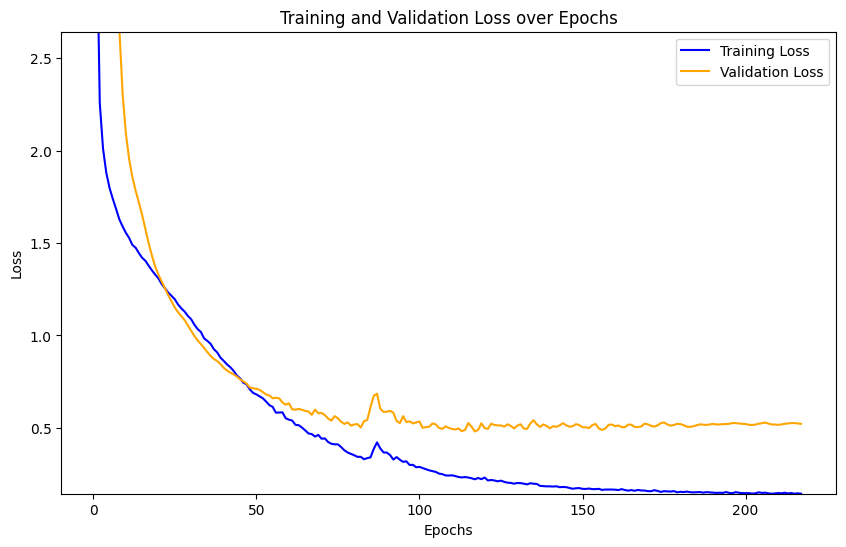

Accuracy: 0.8265, Precision: 0.8363, Recall: 0.8253, F1 Score: 0.8256


In [ ]:
import os
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GINConv, BatchNorm, global_add_pool
from torch_geometric.utils import subgraph
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import NearestNeighbors
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Encode labels
le = LabelEncoder()
le.fit(df_balanced['Diagnosis'])
df_balanced['label'] = le.transform(df_balanced["Diagnosis"])

# Check the consistency of the data
print(f"Number of samples in df_balanced: {len(df_balanced)}")
print(f"Number of unique images: {len(df_balanced['Image'])}")

# Prepare features and labels
X = np.array(df_balanced['Image'].tolist())
y = df_balanced['label'].values

# Ensure the number of samples in X and y are consistent
if X.shape[0] != len(y):
    print("Inconsistent number of samples between X and y.")
    min_samples = min(X.shape[0], len(y))
    X = X[:min_samples]
    y = y[:min_samples]
    print(f"Adjusted shape of X: {X.shape}")
    print(f"Adjusted length of y: {len(y)}")

# Flatten the images
X_flat = X.reshape(X.shape[0], -1)
print(f"Shape of X_flat: {X_flat.shape}")

# Normalize the features
scaler = StandardScaler()
X_flat = scaler.fit_transform(X_flat)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=0.2, random_state=42)

# Create edge index using k-nearest neighbors
def create_edge_index(X, k=5):
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='auto').fit(X)
    distances, indices = nbrs.kneighbors(X)
    edge_index = []
    for i, neighbors in enumerate(indices):
        for neighbor in neighbors[1:]:  # Skip the first neighbor (the node itself)
            edge_index.append([i, neighbor])
            edge_index.append([neighbor, i])  # Add both directions (i -> neighbor and neighbor -> i)
    edge_index = np.array(edge_index).T
    return torch.tensor(edge_index, dtype=torch.long)

edge_index = create_edge_index(X_train)

# Prepare PyTorch Geometric data
train_data = Data(x=torch.tensor(X_train, dtype=torch.float), edge_index=edge_index, y=torch.tensor(y_train, dtype=torch.long))
test_data = Data(x=torch.tensor(X_test, dtype=torch.float), edge_index=create_edge_index(X_test), y=torch.tensor(y_test, dtype=torch.long))

# Define the GIN model
class GIN(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, num_classes):
        super(GIN, self).__init__()
        self.conv1 = GINConv(torch.nn.Sequential(
            torch.nn.Linear(num_node_features, hidden_channels),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_channels, hidden_channels),
        ))
        self.bn1 = BatchNorm(hidden_channels)
        self.conv2 = GINConv(torch.nn.Sequential(
            torch.nn.Linear(hidden_channels, hidden_channels),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_channels, hidden_channels),
        ))
        self.bn2 = BatchNorm(hidden_channels)
        self.conv3 = GINConv(torch.nn.Sequential(
            torch.nn.Linear(hidden_channels, hidden_channels),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_channels, num_classes),
        ))
        self.dropout = torch.nn.Dropout(p=0.5)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)

# Train GIN model with early stopping and learning rate scheduler
def train_gin_model(train_data, test_data, hidden_channels, lr, weight_decay, epochs=500, patience=100, scheduler_patience=30, factor=0.5, min_lr=1e-5, batch_size=32, device='cpu'):
    model = GIN(num_node_features=train_data.num_features, hidden_channels=hidden_channels, num_classes=train_data.y.max().item() + 1).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=factor, patience=scheduler_patience, min_lr=min_lr)

    best_loss = float('inf')
    best_model = None
    patience_counter = 0

    train_loader = DataLoader([train_data], batch_size=batch_size, shuffle=True)
    test_loader = DataLoader([test_data], batch_size=batch_size, shuffle=False)

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        for data in train_loader:
            optimizer.zero_grad()
            data = data.to(device)
            out = model(data)
            loss = F.nll_loss(out, data.y)
            loss.backward()
            optimizer.step()

        # Evaluate on validation set
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data in test_loader:
                data = data.to(device)
                val_out = model(data)
                val_loss += F.nll_loss(val_out, data.y).item()
        val_loss /= len(test_loader)

        scheduler.step(val_loss)

        train_losses.append(loss.item())
        val_losses.append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}, Val Loss: {val_loss}, LR: {optimizer.param_groups[0]["lr"]}')

        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

    # Load the best model
    model.load_state_dict(best_model)
    return model, train_losses, val_losses

# Train the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model, train_losses, val_losses = train_gin_model(train_data, test_data, hidden_channels=128, lr=0.001, weight_decay=5e-4, epochs=500, patience=100, scheduler_patience=30, factor=0.5, min_lr=1e-5, batch_size=32, device=device)

# Function to plot training and validation loss with specified y-axis width
def plot_losses(train_losses, val_losses, y_width):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, 'b', label='Training Loss')
    plt.plot(epochs, val_losses, 'orange', label='Validation Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(min(min(train_losses), min(val_losses)), min(min(train_losses), min(val_losses)) + y_width)
    plt.legend()
    plt.show()

# Call the function with the specified y-axis width
y_width = 2.5  # Define the y_width value as per your requirement
plot_losses(train_losses, val_losses, y_width)


# Evaluate the model
def evaluate_model(model, test_data, device='cpu'):
    model.eval()
    test_loader = DataLoader([test_data], batch_size=32, shuffle=False)
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            out = model(data)
            pred = out.argmax(dim=1)
            all_preds.append(pred.cpu().numpy())
            all_labels.append(data.y.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='macro')
    rec = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    print(f'Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1 Score: {f1:.4f}')

# Evaluate the trained model
evaluate_model(model, test_data, device=device)


#### Confusion Matrix

In [ ]:
import os
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GINConv, BatchNorm, global_add_pool
from torch_geometric.utils import subgraph
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.neighbors import NearestNeighbors
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Encode labels
le = LabelEncoder()
le.fit(df_balanced['Diagnosis'])
df_balanced['label'] = le.transform(df_balanced["Diagnosis"])

# Check the consistency of the data
print(f"Number of samples in df_balanced: {len(df_balanced)}")
print(f"Number of unique images: {len(df_balanced['Image'])}")

# Prepare features and labels
X = np.array(df_balanced['Image'].tolist())
y = df_balanced['label'].values

# Ensure the number of samples in X and y are consistent
if X.shape[0] != len(y):
    print("Inconsistent number of samples between X and y.")
    min_samples = min(X.shape[0], len(y))
    X = X[:min_samples]
    y = y[:min_samples]
    print(f"Adjusted shape of X: {X.shape}")
    print(f"Adjusted length of y: {len(y)}")

# Flatten the images
X_flat = X.reshape(X.shape[0], -1)
print(f"Shape of X_flat: {X_flat.shape}")

# Normalize the features
scaler = StandardScaler()
X_flat = scaler.fit_transform(X_flat)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=0.2, random_state=42)

# Create edge index using k-nearest neighbors
def create_edge_index(X, k=5):
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='auto').fit(X)
    distances, indices = nbrs.kneighbors(X)
    edge_index = []
    for i, neighbors in enumerate(indices):
        for neighbor in neighbors[1:]:  # Skip the first neighbor (the node itself)
            edge_index.append([i, neighbor])
            edge_index.append([neighbor, i])  # Add both directions (i -> neighbor and neighbor -> i)
    edge_index = np.array(edge_index).T
    return torch.tensor(edge_index, dtype=torch.long)

edge_index = create_edge_index(X_train)

# Prepare PyTorch Geometric data
train_data = Data(x=torch.tensor(X_train, dtype=torch.float), edge_index=edge_index, y=torch.tensor(y_train, dtype=torch.long))
test_data = Data(x=torch.tensor(X_test, dtype=torch.float), edge_index=create_edge_index(X_test), y=torch.tensor(y_test, dtype=torch.long))

# Define the GIN model
class GIN(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, num_classes):
        super(GIN, self).__init__()
        self.conv1 = GINConv(torch.nn.Sequential(
            torch.nn.Linear(num_node_features, hidden_channels),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_channels, hidden_channels),
        ))
        self.bn1 = BatchNorm(hidden_channels)
        self.conv2 = GINConv(torch.nn.Sequential(
            torch.nn.Linear(hidden_channels, hidden_channels),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_channels, hidden_channels),
        ))
        self.bn2 = BatchNorm(hidden_channels)
        self.conv3 = GINConv(torch.nn.Sequential(
            torch.nn.Linear(hidden_channels, hidden_channels),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_channels, num_classes),
        ))
        self.dropout = torch.nn.Dropout(p=0.5)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)

# Train GIN model with early stopping and learning rate scheduler
def train_gin_model(train_data, test_data, hidden_channels, lr, weight_decay, epochs=500, patience=100, scheduler_patience=30, factor=0.5, min_lr=1e-5, batch_size=32, device='cpu'):
    model = GIN(num_node_features=train_data.num_features, hidden_channels=hidden_channels, num_classes=train_data.y.max().item() + 1).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=factor, patience=scheduler_patience, min_lr=min_lr)

    best_loss = float('inf')
    best_model = None
    patience_counter = 0

    train_loader = DataLoader([train_data], batch_size=batch_size, shuffle=True)
    test_loader = DataLoader([test_data], batch_size=batch_size, shuffle=False)

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        for data in train_loader:
            optimizer.zero_grad()
            data = data.to(device)
            out = model(data)
            loss = F.nll_loss(out, data.y)
            loss.backward()
            optimizer.step()

        # Evaluate on validation set
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data in test_loader:
                data = data.to(device)
                val_out = model(data)
                val_loss += F.nll_loss(val_out, data.y).item()
        val_loss /= len(test_loader)

        scheduler.step(val_loss)

        train_losses.append(loss.item())
        val_losses.append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}, Val Loss: {val_loss}, LR: {optimizer.param_groups[0]["lr"]}')

        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

    # Load the best model
    model.load_state_dict(best_model)
    return model, train_losses, val_losses

# Train the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model, train_losses, val_losses = train_gin_model(train_data, test_data, hidden_channels=128, lr=0.001, weight_decay=5e-4, epochs=500, patience=100, scheduler_patience=30, factor=0.5, min_lr=1e-5, batch_size=32, device=device)

# Function to plot training and validation loss with specified y-axis width
def plot_losses(train_losses, val_losses, y_width=0.5):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, 'b', label='Training Loss')
    plt.plot(epochs, val_losses, 'orange', label='Validation Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(min(min(train_losses), min(val_losses)), min(min(train_losses), min(val_losses)) + y_width)
    plt.legend()
    plt.show()

# Call the function with the specified y-axis width
plot_losses(train_losses, val_losses)

# Evaluate the model
def evaluate_model(model, test_data, device='cpu'):
    model.eval()
    test_loader = DataLoader([test_data], batch_size=32, shuffle=False)
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            out = model(data)
            pred = out.argmax(dim=1)
            all_preds.append(pred.cpu().numpy())
            all_labels.append(data.y.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='macro')
    rec = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    print(f'Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1 Score: {f1:.4f}')

    return all_labels, all_preds

# Evaluate the trained model
all_labels, all_preds = evaluate_model(model, test_data, device=device)

# Function to plot confusion matrix
def plot_confusion_matrix(all_labels, all_preds, classes):
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Call the function to plot the confusion matrix
plot_confusion_matrix(all_labels, all_preds, classes=le.classes_)


# g. CNN

Epoch 1, Batch 100, Loss: 1.474
Epoch 1, Batch 200, Loss: 1.128
Epoch 1, Batch 300, Loss: 0.958
Epoch 1, Batch 400, Loss: 0.851
Epoch 1, Batch 500, Loss: 0.731
Epoch 1, Batch 600, Loss: 0.694
Epoch 1, Batch 700, Loss: 0.601
Epoch 1, Batch 800, Loss: 0.599
Epoch 1, Batch 900, Loss: 0.541
Epoch 1, Batch 1000, Loss: 0.469
Epoch 1, Batch 1100, Loss: 0.484
Epoch 2, Batch 100, Loss: 0.381
Epoch 2, Batch 200, Loss: 0.364
Epoch 2, Batch 300, Loss: 0.365
Epoch 2, Batch 400, Loss: 0.319
Epoch 2, Batch 500, Loss: 0.336
Epoch 2, Batch 600, Loss: 0.337
Epoch 2, Batch 700, Loss: 0.327
Epoch 2, Batch 800, Loss: 0.281
Epoch 2, Batch 900, Loss: 0.268
Epoch 2, Batch 1000, Loss: 0.262
Epoch 2, Batch 1100, Loss: 0.256
Epoch 3, Batch 100, Loss: 0.245
Epoch 3, Batch 200, Loss: 0.209
Epoch 3, Batch 300, Loss: 0.205
Epoch 3, Batch 400, Loss: 0.181
Epoch 3, Batch 500, Loss: 0.187
Epoch 3, Batch 600, Loss: 0.212
Epoch 3, Batch 700, Loss: 0.202
Epoch 3, Batch 800, Loss: 0.229
Epoch 3, Batch 900, Loss: 0.195
Epoc

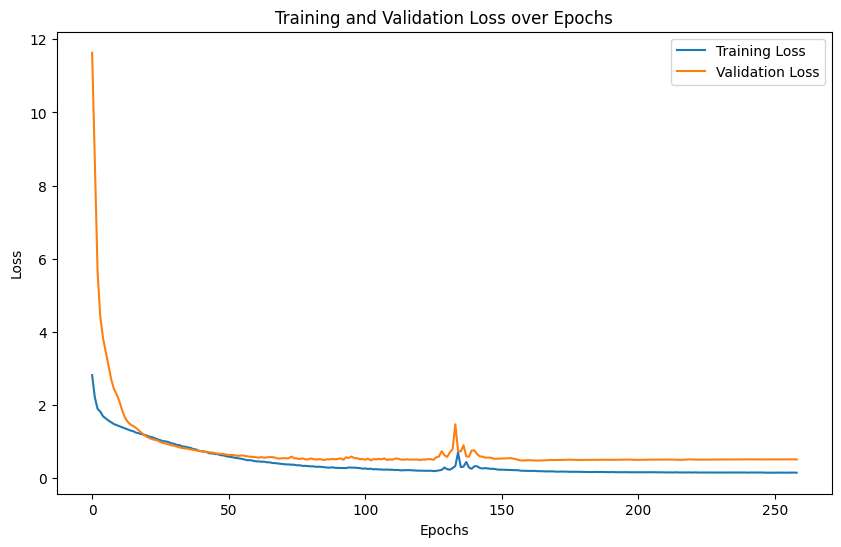

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Define the CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)  # Adjust the input size according to the image size
        self.fc2 = nn.Linear(512, 7)  # Assuming 7 classes for skin cancer

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)  # Adjust according to the image size
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# Assuming df_balanced is already defined and contains the data
# Encode labels
le = LabelEncoder()
le.fit(df_balanced['Diagnosis'])
df_balanced['label'] = le.transform(df_balanced["Diagnosis"])

# Prepare features and labels
X = np.array(df_balanced['Image'].tolist())
y = df_balanced['label'].values

# Normalize the features
scaler = StandardScaler()
X = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Transform data to tensor
class CustomDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].astype(np.float32)
        label = self.labels[idx]
        return torch.tensor(image).permute(2, 0, 1), torch.tensor(label)

train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Create the model
model = CNN()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:    # Print every 100 mini-batches
            print(f'Epoch {epoch+1}, Batch {i+1}, Loss: {running_loss / 100:.3f}')
            running_loss = 0.0

print('Finished Training')

# Evaluate the model
correct = 0
total = 0
all_preds = []
all_labels = []
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds, average='macro')
rec = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

print(f'Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1 Score: {f1:.4f}')

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

### GCN, adjust batch method

Number of samples in df_balanced: 46935
Number of unique images: 46935
Shape of X_flat: (46935, 3072)
Epoch 10/500, Loss: 1.371, Val Loss: 1.391, LR: 0.001
Epoch 20/500, Loss: 1.132, Val Loss: 1.173, LR: 0.001
Epoch 30/500, Loss: 0.934, Val Loss: 0.983, LR: 0.001
Epoch 40/500, Loss: 0.782, Val Loss: 0.850, LR: 0.001
Epoch 50/500, Loss: 0.659, Val Loss: 0.761, LR: 0.001
Epoch 60/500, Loss: 0.561, Val Loss: 0.693, LR: 0.001
Epoch 70/500, Loss: 0.480, Val Loss: 0.623, LR: 0.001
Epoch 80/500, Loss: 0.462, Val Loss: 0.577, LR: 0.001
Epoch 90/500, Loss: 0.404, Val Loss: 0.540, LR: 0.001
Epoch 100/500, Loss: 0.350, Val Loss: 0.506, LR: 0.001
Epoch 110/500, Loss: 0.360, Val Loss: 0.500, LR: 0.001
Epoch 120/500, Loss: 0.307, Val Loss: 0.488, LR: 0.001
Epoch 130/500, Loss: 0.270, Val Loss: 0.465, LR: 0.001
Epoch 140/500, Loss: 0.266, Val Loss: 0.456, LR: 0.001
Epoch 150/500, Loss: 0.320, Val Loss: 0.551, LR: 0.001
Epoch 160/500, Loss: 0.274, Val Loss: 0.479, LR: 0.001
Epoch 170/500, Loss: 0.246,

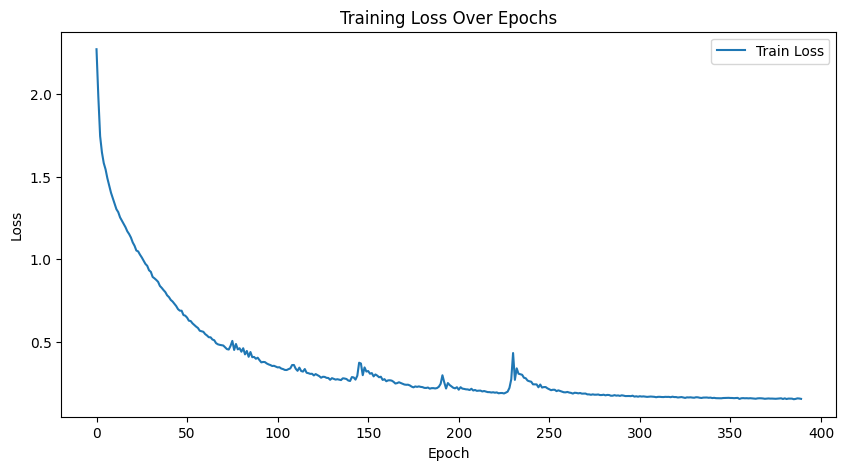

Accuracy: 0.8385, Precision: 0.8520, Recall: 0.8376, F1 Score: 0.8386


In [ ]:
import os
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, BatchNorm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import NearestNeighbors
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Encode labels
le = LabelEncoder()
le.fit(df_balanced['Diagnosis'])
df_balanced['label'] = le.transform(df_balanced["Diagnosis"])

# Check the consistency of the data
print(f"Number of samples in df_balanced: {len(df_balanced)}")
print(f"Number of unique images: {len(df_balanced['Image'])}")

# Prepare features and labels
X = np.array(df_balanced['Image'].tolist())
y = df_balanced['label'].values

# Ensure the number of samples in X and y are consistent
if X.shape[0] != len(y):
    print("Inconsistent number of samples between X and y.")
    min_samples = min(X.shape[0], len(y))
    X = X[:min_samples]
    y = y[:min_samples]
    print(f"Adjusted shape of X: {X.shape}")
    print(f"Adjusted length of y: {len(y)}")

# Flatten the images
X_flat = X.reshape(X.shape[0], -1)
print(f"Shape of X_flat: {X_flat.shape}")

# Normalize the features
scaler = StandardScaler()
X_flat = scaler.fit_transform(X_flat)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=0.2, random_state=42)

# Create edge index using k-nearest neighbors
def create_edge_index(X, k=5):
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='auto').fit(X)
    distances, indices = nbrs.kneighbors(X)
    edge_index = []
    for i, neighbors in enumerate(indices):
        for neighbor in neighbors[1:]:  # Skip the first neighbor (the node itself)
            edge_index.append([i, neighbor])
            edge_index.append([neighbor, i])  # Add both directions (i -> neighbor and neighbor -> i)
    edge_index = np.array(edge_index).T
    return torch.tensor(edge_index, dtype=torch.long)

edge_index_train = create_edge_index(X_train)
edge_index_test = create_edge_index(X_test)

# Prepare PyTorch Geometric data
train_data = Data(x=torch.tensor(X_train, dtype=torch.float), edge_index=edge_index_train, y=torch.tensor(y_train, dtype=torch.long))
test_data = Data(x=torch.tensor(X_test, dtype=torch.float), edge_index=edge_index_test, y=torch.tensor(y_test, dtype=torch.long))

# Create DataLoader
train_loader = DataLoader([train_data], batch_size=32, shuffle=True)
test_loader = DataLoader([test_data], batch_size=32, shuffle=False)

# Define improved GCN model with dropout and batch normalization
class ImprovedGCN(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, num_classes):
        super(ImprovedGCN, self).__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.bn1 = BatchNorm(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.bn2 = BatchNorm(hidden_channels)
        self.conv3 = GCNConv(hidden_channels, num_classes)
        self.dropout = torch.nn.Dropout(p=0.5)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)

# Train improved GCN model with early stopping and learning rate scheduler
def train_improved_gcn_model(train_loader, test_loader, hidden_channels, lr, weight_decay, epochs=500, patience=100, scheduler_patience=30, factor=0.5, min_lr=1e-5, device='cpu'):
    train_losses = []
    model = ImprovedGCN(num_node_features=train_data.num_features, hidden_channels=hidden_channels, num_classes=train_data.y.max().item() + 1).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=factor, patience=scheduler_patience, min_lr=min_lr)

    best_loss = float('inf')
    best_model = None
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for batch in train_loader:
            optimizer.zero_grad()
            out = model(batch.to(device))
            loss = F.nll_loss(out, batch.y.to(device))
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)

        # Evaluate on validation set
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in test_loader:
                val_out = model(batch.to(device))
                val_loss += F.nll_loss(val_out, batch.y.to(device)).item()
        val_loss /= len(test_loader)

        scheduler.step(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.3f}, Val Loss: {val_loss:.3f}, LR: {optimizer.param_groups[0]["lr"]}')

        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

    # Load the best model
    model.load_state_dict(best_model)

    # Plotting the loss
    plt.figure(figsize=(10,5))
    plt.title("Training Loss Over Epochs")
    plt.plot(train_losses, label="Train Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    return model

# Train the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = train_improved_gcn_model(train_loader, test_loader, hidden_channels=128, lr=0.001, weight_decay=5e-4, epochs=500, patience=100, scheduler_patience=30, factor=0.5, min_lr=1e-5, device=device)

# Evaluate the model
def evaluate_model(model, test_loader, device='cpu'):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in test_loader:
            out = model(batch.to(device))
            pred = out.argmax(dim=1)
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(batch.y.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='macro')
    rec = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    print(f'Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1 Score: {f1:.4f}')

# Evaluate the trained model
evaluate_model(model, test_loader, device=device)


### CNN+GCN

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from skimage.segmentation import slic
from skimage.future import graph
from skimage.color import rgb2lab
import networkx as nx
import matplotlib.pyplot as plt
from PIL import Image
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming df_balanced is already defined and contains the data
# Label encoding to numeric values from text
le = LabelEncoder()
le.fit(df_balanced['Diagnosis'])
df_balanced['label'] = le.transform(df_balanced["Diagnosis"])

# Prepare features and labels
X = np.array(df_balanced['Image'].tolist())
y = df_balanced['label'].values

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].astype(np.float32)
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_dataset = CustomDataset(X_train, y_train, transform=transform)
test_dataset = CustomDataset(X_test, y_test, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class HybridCNNGCN(nn.Module):
    def __init__(self, num_classes):
        super(HybridCNNGCN, self).__init__()
        # CNN part (using a pre-trained model)
        self.cnn = models.resnet18(pretrained=True)
        self.cnn.fc = nn.Identity()  # Remove the final classification layer

        # GCN part
        self.gcn_conv1 = GCNConv(512, 256)
        self.gcn_conv2 = GCNConv(256, num_classes)

    def forward(self, x, edge_index):
        # CNN forward pass
        x = self.cnn(x)

        # GCN forward pass
        x = self.gcn_conv1(x, edge_index)
        x = F.relu(x)
        x = self.gcn_conv2(x, edge_index)

        return x

# Instantiate the model
model = HybridCNNGCN(num_classes=len(le.classes_))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(model, train_loader, test_loader, criterion, optimizer, device, num_epochs=10):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            # Generate graph structure (for simplicity, using a fixed edge_index)
            edge_index = ...  # Define the edge index for the GCN

            outputs = model(images, edge_index)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        train_losses.append(running_loss / len(train_loader))
        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {running_loss / len(train_loader)}")

        # Validation loss
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)

                # Generate graph structure (for simplicity, using a fixed edge_index)
                edge_index = ...  # Define the edge index for the GCN

                outputs = model(images, edge_index)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        val_losses.append(val_loss / len(test_loader))
        print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss / len(test_loader)}")

    return train_losses, val_losses

train_losses, val_losses = train_model(model, train_loader, test_loader, criterion, optimizer, device)

def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Generate graph structure (for simplicity, using a fixed edge_index)
            edge_index = ...  # Define the edge index for the GCN

            outputs = model(images, edge_index)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='macro')
    rec = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    print(f'Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1 Score: {f1:.4f}')

evaluate_model(model, test_loader, device)

# Plotting the training and validation losses
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


ImportError: cannot import name 'graph' from 'skimage.future' (/usr/local/lib/python3.10/dist-packages/skimage/future/__init__.py)

# Hypothesis Test

In [ ]:
df

Lesion_Id      Image_Id  Diagnosis Confirmation_Method  Age  Sex  \
0      HAM_0000118  ISIC_0027419          2               histo   80    1   
1      HAM_0000118  ISIC_0025030          2               histo   80    1   
2      HAM_0002730  ISIC_0026769          2               histo   80    1   
3      HAM_0002730  ISIC_0025661          2               histo   80    1   
4      HAM_0001466  ISIC_0031633          2               histo   75    1   
...            ...           ...        ...                 ...  ...  ...   
10010  HAM_0002867  ISIC_0033084          0               histo   40    1   
10011  HAM_0002867  ISIC_0033550          0               histo   40    1   
10012  HAM_0002867  ISIC_0033536          0               histo   40    1   
10013  HAM_0000239  ISIC_0032854          0               histo   80    1   
10014  HAM_0003521  ISIC_0032258          4               histo   70    0   

       Region_Of_Disease  Dataset  
0                     11        1  
1                     11        1  
2                     11        1  
3                     11        1  
4                      4        1  
...                  ...      ...  
10010                  0        1  
10011                  0        1  
10012                  0        1  
10013                  5        1  
10014                  2        1  

[10015 rows x 8 columns]

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from scipy.stats import ttest_ind, chi2_contingency, kruskal
import time


# Preprocess data
# Encoding categorical variables
df['Sex'] = df['Sex'].astype('category').cat.codes
df['Region_Of_Disease'] = df['Region_Of_Disease'].astype('category').cat.codes
df['Dataset'] = df['Dataset'].astype('category').cat.codes
df['Diagnosis'] = df['Diagnosis'].astype('category').cat.codes
df['Confirmation_Method'] = df['Confirmation_Method'].astype('category').cat.codes


# Splitting data into features and target variable
X = df.drop(columns=['Diagnosis', 'Lesion_Id', 'Image_Id'])
y = df['Diagnosis']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest for feature importance
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# Feature importance
feature_importances = rf.feature_importances_
important_features = pd.Series(feature_importances, index=X_train.columns).sort_values(ascending=False)

# Display feature importance
print("Feature Importance:\n", important_features)

# Statistical tests
# t-test for numerical features
t_test_results = {}
for feature in ['Age']:  # List all numerical features here
    t_stat, p_value = ttest_ind(X_train[feature], y_train)
    t_test_results[feature] = (t_stat, p_value)

# Chi-Square test for categorical features
chi2_results = {}
for feature in ['Sex', 'Region_Of_Disease', 'Dataset']:  # List all categorical features here
    contingency_table = pd.crosstab(X_train[feature], y_train)
    chi2, p, dof, ex = chi2_contingency(contingency_table)
    chi2_results[feature] = (chi2, p)

# Display t-test and chi-square test results
print("T-Test Results:\n", t_test_results)
print("Chi-Square Test Results:\n", chi2_results)


Feature Importance:
 Age                    0.333630
Region_Of_Disease      0.242428
Confirmation_Method    0.213214
Dataset                0.173694
Sex                    0.037034
dtype: float64
T-Test Results:
 {'Age': (249.6457715263417, 0.0)}
Chi-Square Test Results:
 {'Sex': (86.1931163803543, 2.6827398019614686e-13), 'Region_Of_Disease': (2303.2011717079085, 0.0), 'Dataset': (2752.2011716580705, 0.0)}
